# 一.导入原始数据

## 1.1 数据导入和格式化

In [5]:
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
from torch.nn.parallel import DataParallel
import torch.nn.functional as F
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 新数据
# 读取所有数据
paths = [
    './data/clean/clean_processed_data_1500_1.csv', './data/clean/clean_processed_data_1500_2.csv', './data/clean/clean_processed_data_1500_3.csv',
    './data/clean/clean_processed_data_1500_4.csv', './data/clean/clean_processed_data_1500_5.csv', './data/clean/clean_processed_data_1500_6.csv',
    './data/new1/clean_processed_data_1500_1.csv', './data/new1/clean_processed_data_1500_2.csv', './data/new1/clean_processed_data_1500_3.csv',
    './data/new1/clean_processed_data_1500_4.csv', './data/new1/clean_processed_data_1500_5.csv', './data/new1/clean_processed_data_1500_6.csv',
    './data/new2/clean_processed_data_1500_1.csv', './data/new2/clean_processed_data_1500_2.csv', './data/new2/clean_processed_data_1500_3.csv',
    './data/new2/clean_processed_data_1500_4.csv', './data/new2/clean_processed_data_1500_5.csv', './data/new2/clean_processed_data_1500_6.csv',
    './data/new3/clean_processed_data_1500_1.csv', './data/new3/clean_processed_data_1500_2.csv', './data/new3/clean_processed_data_1500_3.csv',
    './data/new3/clean_processed_data_1500_4.csv', './data/new3/clean_processed_data_1500_5.csv', './data/new3/clean_processed_data_1500_6.csv'   
]

all_data = []
for path in paths:
    data = pd.read_csv(path,header=None)
    data = np.array(data)
    all_data.append(data)
all_data = np.concatenate(all_data, axis=0)

# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data) 
processed = np.array(processed, dtype=object)
print(processed.shape)
print(processed[3][:5])

(10632,)
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO3' '2']
 ['MoO2' '96']
 ['MoO2S2' '2']]


In [2]:
import numpy as np
processed = np.concatenate(processed)
print('X.shape', processed.shape)  # 输入的形状

X.shape (1648646, 2)


## 1.2.原始数据(processed)统计分析

#### 统计所有物种类型

In [3]:
# 统计所有物种类型
unique_species = set()

for record in processed:
    for element in record:
        # element 是一个包含 ['物种名称', '停留时间'] 的数组
        mol = element[0]  # 获取物种名称
        unique_species.add(mol)

# 输出所有物种类型的名称
print(len(unique_species))
#print(unique_species)

10


#### 统计每个物种的总出现次数以及停留时间小于等于n的次数

In [4]:
from collections import Counter
import numpy as np
import pandas as pd

def count_species_with_time(processed, n):
    """
    统计每个物种的总出现次数以及停留时间小于等于n的次数。

    参数:
    - processed (np.array): 处理后的数据数组，元素为每条记录的物种及停留时间。
    - n (int): 停留时间的阈值。

    返回:
    - species_counter (Counter): 每个物种的总出现次数。
    - species_counter_le_n (Counter): 每个物种停留时间小于等于n的出现次数。
    """
    species_counter = Counter()
    species_counter_le_n = Counter()
    
    for record in processed:
        for element in record:
            mol = element[0]
            try:
                count = int(element[1])
            except ValueError:
                print(f"无法将停留时间转换为整数: {element[1]}，跳过该元素。")
                continue  # 跳过无法转换的元素
            
            species_counter[mol] += 1
            if count <= n:
                species_counter_le_n[mol] += 1
    
    return species_counter, species_counter_le_n

def print_species_statistics(species_counts, species_counts_le_n, n):
    """
    打印每种物种的总出现次数、停留时间小于等于n的出现次数以及停留时间大于n的出现次数，
    按总出现次数降序排列。

    参数:
    - species_counts (Counter): 每个物种的总出现次数。
    - species_counts_le_n (Counter): 每个物种停留时间小于等于n的出现次数。
    - n (int): 停留时间的阈值。
    """
    # 获取按总出现次数降序排列的物种列表
    sorted_species = species_counts.most_common()
    
    # 打印表头
    print(f"\n{'物种类型':<20} {'总出现次数':<15} {'停留时间<= ' + str(n) + ' 次数':<20} {'停留时间> ' + str(n) + ' 次数':<20}")
    print("-" * 75)
    
    # 打印每种物种的统计数据
    for mol, total in sorted_species:
        le_n = species_counts_le_n.get(mol, 0)
        gt_n = total - le_n  # 计算停留时间 > n 的次数
        print(f"{mol:<20} {total:<15} {le_n:<20} {gt_n:<20}")


# 示例调用
if __name__ == "__main__":

    n = 3  # 设定阈值
    
    # 统计物种出现次数和停留时间小于等于n的出现次数
    species_counts, species_counts_le_n = count_species_with_time(processed_deleted, n) #########################修改
    
    # 打印统计结果，按总出现次数降序排列
    print_species_statistics(species_counts, species_counts_le_n, n)

NameError: name 'processed_deleted' is not defined

#### 统计每个物种的最大、最小和平均停留时间

In [ ]:
from collections import Counter, defaultdict
# -----------------------------------------------
# 统计每个物种的最大、最小和平均停留时间
# -----------------------------------------------

# 使用 defaultdict 存储每个物种的最小、最大停留时间及总停留时间
species_time_stats = defaultdict(lambda: {'min': None, 'max': None, 'total': 0, 'count': 0})

for record in processed_deleted: ########################filtered_processed，processed_deleted
    for element in record:
        mol, count = element[0], int(element[1])
        if species_time_stats[mol]['min'] is None or count < species_time_stats[mol]['min']:
            species_time_stats[mol]['min'] = count
        if species_time_stats[mol]['max'] is None or count > species_time_stats[mol]['max']:
            species_time_stats[mol]['max'] = count
        species_time_stats[mol]['total'] += count
        species_time_stats[mol]['count'] += 1

# 计算平均停留时间并准备输出列表
species_time_list = sorted(
    [
        (
            stats['total'] / stats['count'] if stats['count'] > 0 else 0,
            stats['max'],
            stats['min'],
            mol
        )
        for mol, stats in species_time_stats.items()
    ],
    key=lambda x: x[0]
)

# 输出统计结果
print("\n每种物种类型的最大、最小和平均停留时间：")
for avg_time, max_time,min_time,mol in species_time_list:
    print(f"{mol}: 最小停留时间 = {min_time}, 最大停留时间 = {max_time}, 平均停留时间 = {avg_time:.2f}")


每种物种类型的最大、最小和平均停留时间：
Mo2O4: 最小停留时间 = 1, 最大停留时间 = 69, 平均停留时间 = 4.61
MoO3: 最小停留时间 = 1, 最大停留时间 = 482, 平均停留时间 = 7.94
Mo3O9S2: 最小停留时间 = 1, 最大停留时间 = 68, 平均停留时间 = 10.72
MoO2S2: 最小停留时间 = 1, 最大停留时间 = 730, 平均停留时间 = 13.33
MoO2S: 最小停留时间 = 1, 最大停留时间 = 604, 平均停留时间 = 15.14
MoO2S4: 最小停留时间 = 1, 最大停留时间 = 820, 平均停留时间 = 21.98
MoOS4: 最小停留时间 = 1, 最大停留时间 = 1341, 平均停留时间 = 31.89
MoO2S5: 最小停留时间 = 1, 最大停留时间 = 1381, 平均停留时间 = 33.52
MoOS2: 最小停留时间 = 1, 最大停留时间 = 1325, 平均停留时间 = 38.79
MoOS3: 最小停留时间 = 1, 最大停留时间 = 1566, 平均停留时间 = 39.81
MoO2: 最小停留时间 = 1, 最大停留时间 = 880, 平均停留时间 = 46.31
MoS: 最小停留时间 = 1, 最大停留时间 = 901, 平均停留时间 = 51.94
MoOS5: 最小停留时间 = 1, 最大停留时间 = 1649, 平均停留时间 = 55.45
MoO: 最小停留时间 = 1, 最大停留时间 = 737, 平均停留时间 = 56.77
MoS2: 最小停留时间 = 1, 最大停留时间 = 1575, 平均停留时间 = 60.88
Mo2S5: 最小停留时间 = 1, 最大停留时间 = 854, 平均停留时间 = 67.04
Mo3O9: 最小停留时间 = 1, 最大停留时间 = 684, 平均停留时间 = 72.19
MoS4: 最小停留时间 = 1, 最大停留时间 = 2320, 平均停留时间 = 72.29
MoOS: 最小停留时间 = 1, 最大停留时间 = 999, 平均停留时间 = 72.83
MoS5: 最小停留时间 = 1, 最大停留时间 = 1975, 平均停留时间 = 72.83
Mo2S6: 最小停留时间 = 1, 

## 2.深度处理原始数据(processed)

### 2.1.删除停留时间小于 min_time 的状态 (处理processed，得到new_processed)

In [6]:
import numpy as np

def filter_and_merge_one_record(record, min_time=5):
    """
    对单条记录进行过滤和合并操作：
    1. 删除停留时间小于 min_time 的状态。
    2. 将删除后连续且相同物种的状态合并为一个状态（停留时间累加）。
    
    参数：
    - record: 形如 array([['MoO','33'], ['MoS','251'], ['MoS','254'], ...]) 的数组
    - min_time: 停留时间的阈值，删除停留时间小于该值的状态
    
    返回：
    - 处理后的 NumPy 数组，满足以上两步操作
    """
    # 1) 过滤：删除停留时间 =< min_time 的状态
    filtered = [row for row in record if int(row[1]) > min_time]
    
    # 2) 合并连续相同物种的状态
    merged = []
    for mol, time_str in filtered:
        time_val = int(time_str)
        if merged and merged[-1][0] == mol:
            # 若与上一个物种相同，则合并（累加停留时间）
            merged[-1][1] = str(int(merged[-1][1]) + time_val)
        else:
            # 否则添加新的物种状态
            merged.append([mol, str(time_val)])
    
    return np.array(merged)

def filter_and_merge_processed(processed, min_time=5):
    """
    对完整的 processed 数据进行过滤和合并操作：
    对 processed 每个元素（单条记录）调用 filter_and_merge_one_record
    
    参数：
    - processed: 形如 [record_1, record_2, ...] 的对象数组（dtype=object）
    - min_time: 停留时间的阈值
    
    返回：
    - 处理后的 NumPy 对象数组
    """
    new_processed = []
    for idx, record in enumerate(processed):
        merged_record = filter_and_merge_one_record(record, min_time=min_time)
        new_processed.append(merged_record)
    
    return np.array(new_processed, dtype=object)

# -------------------- 测试示例 --------------------
if __name__ == "__main__":    
    # 设定阈值，比如 n=5
    n = 0
    
    # 调用过滤和合并函数
    new_processed = filter_and_merge_processed(processed, min_time=n)
    
    # 打印过滤前和过滤后的结果
    print("过滤前 (原始数据) ：")
    print(processed[4][:30])
    
    print("\n过滤后 (删除停留时间 < 0 并合并相邻相同状态) ：")
    print(new_processed[4][:30])

过滤前 (原始数据) ：
[['Mo3O9' '26']
 ['Mo3O9S2' '7']
 ['MoO2' '52']
 ['MoO' '4']
 ['MoO2' '25']
 ['MoO2S2' '1']
 ['MoOS2' '118']
 ['MoS' '5']
 ['MoOS2' '7']
 ['MoS' '2']
 ['MoOS2' '7']
 ['MoS' '292']
 ['MoOS2' '9']
 ['MoS' '240']
 ['MoOS2' '2']
 ['MoS' '3']
 ['MoOS2' '11']
 ['MoOS' '9']
 ['Mo' '22']
 ['MoOS' '247']
 ['MoS' '145']
 ['MoOS2' '13']
 ['MoS' '121']
 ['MoOS2' '2']
 ['MoS' '236']
 ['MoOS2' '19']
 ['MoS' '141']
 ['MoS3' '5']
 ['MoS' '14']
 ['MoS3' '11']]

过滤后 (删除停留时间 < 0 并合并相邻相同状态) ：
[['Mo3O9' '26']
 ['Mo3O9S2' '7']
 ['MoO2' '52']
 ['MoO' '4']
 ['MoO2' '25']
 ['MoO2S2' '1']
 ['MoOS2' '118']
 ['MoS' '5']
 ['MoOS2' '7']
 ['MoS' '2']
 ['MoOS2' '7']
 ['MoS' '292']
 ['MoOS2' '9']
 ['MoS' '240']
 ['MoOS2' '2']
 ['MoS' '3']
 ['MoOS2' '11']
 ['MoOS' '9']
 ['Mo' '22']
 ['MoOS' '247']
 ['MoS' '145']
 ['MoOS2' '13']
 ['MoS' '121']
 ['MoOS2' '2']
 ['MoS' '236']
 ['MoOS2' '19']
 ['MoS' '141']
 ['MoS3' '5']
 ['MoS' '14']
 ['MoS3' '11']]


### 2.3.截断长序列到终产物（new_processed，得到filtered_processed和record_lengths）

In [7]:
import numpy as np
from collections import Counter

# 定义产物列表
product_list = ['MoS6', 'MoS7']

def filter_by_product_list_with_n(new_processed, product_list, n=0):
    """
    对序列进行过滤：
    当遇到 product_list 中的物种时，保留该物种及其之前的内容，并额外保留其后的 n 个状态。
    
    参数：
    - new_processed: 输入数据，形如 [record_1, record_2, ...] 的对象数组（dtype=object）
    - product_list: 需要检查的产物列表，例如 ['MoS6', 'MoS7']
    - n: 额外保留的后续状态数目，默认为 0
    
    返回：
    - 过滤后的 NumPy 对象数组
    """
    filtered_records = []
    record_lengths = []  # 记录每个过滤后记录的长度
    
    # 遍历每一行记录
    for record in new_processed:
        # 初始化截断后的记录
        truncated_record = []
        found_product = False
        extra_count = 0
        
        # 遍历当前记录中的每一对 [物种, 时间]
        for i, (mol, time) in enumerate(record):
            if found_product:
                # 如果已经遇到 product_list 中的物种，额外保留 n 个状态
                if extra_count < n:
                    truncated_record.append([mol, time])
                    extra_count += 1
                else:
                    break
            else:
                # 添加当前 [mol, time]
                truncated_record.append([mol, time])
                # 如果当前物种在 product_list 中，标记 found_product
                if mol in product_list:
                    found_product = True
                    # 如果 n=0，立即停止
                    if n == 0:
                        break
        
        # 如果整行没有遇到 product_list 中的物种，保留整行
        if not found_product:
            truncated_record = record
        
        # 将截断后的记录转换为 NumPy 数组并添加到结果列表
        filtered_records.append(np.array(truncated_record))
        record_lengths.append(len(truncated_record))  # 记录长度
    
    # 转换为 NumPy 对象数组
    return np.array(filtered_records, dtype=object), record_lengths

# 假设 processed 已由之前的代码生成
# 调用函数进行过滤，n=0
filtered_processed, record_lengths = filter_by_product_list_with_n(new_processed, product_list, n=0) #######################new_processed

# 统计每个长度出现的次数
length_counts = Counter(record_lengths)

# 获取按长度排序的结果
sorted_length_counts = sorted(length_counts.items())

# 输出最小长度

min_length = sorted_length_counts[0][0]
second_min_length = sorted_length_counts[1][0] if len(sorted_length_counts) > 1 else None
third_min_length = sorted_length_counts[2][0] if len(sorted_length_counts) > 2 else None
forth_min_length = sorted_length_counts[3][0] if len(sorted_length_counts) > 3 else None
fifth_min_length = sorted_length_counts[4][0] if len(sorted_length_counts) > 4 else None

print("\n最小长度:", min_length, "总行数:", length_counts[min_length])
if second_min_length is not None:
    print("第二小长度:", second_min_length, "总行数:", length_counts[second_min_length])
if third_min_length is not None:
    print("第三小长度:", third_min_length, "总行数:", length_counts[third_min_length])
if forth_min_length is not None:
    print("第四小长度:", forth_min_length, "总行数:", length_counts[forth_min_length])
if fifth_min_length is not None:
    print("第五小长度:", fifth_min_length, "总行数:", length_counts[fifth_min_length])    
    
# 打印示例结果
print("\n过滤前：")
print(new_processed[1][:30])
print("\n过滤后 (删除 product_list 中的物种及其之后的内容)：")
print(filtered_processed[1][:30])


最小长度: 5 总行数: 3
第二小长度: 6 总行数: 8
第三小长度: 7 总行数: 32
第四小长度: 8 总行数: 94
第五小长度: 9 总行数: 180

过滤前：
[['Mo3O9' '55']
 ['MoO2' '128']
 ['MoOS' '3']
 ['MoOS2' '2']
 ['MoS' '2']
 ['MoOS2' '75']
 ['MoS4' '366']
 ['MoS6' '196']
 ['Mo2S8' '24']
 ['MoS4' '66']
 ['Mo2S7' '6']
 ['MoS4' '90']
 ['MoS6' '90']
 ['MoS8' '6']
 ['MoS6' '13']
 ['MoS8' '2']
 ['MoS6' '6']
 ['MoS8' '2']
 ['MoS6' '838']
 ['MoS8' '20']
 ['MoS6' '283']
 ['Mo2S7' '52']
 ['Mo2S6' '11']
 ['MoS6' '149']
 ['MoS4' '2']
 ['MoS6' '51']
 ['MoS8' '2']
 ['MoS6' '331']
 ['MoS8' '4']
 ['MoS6' '409']]

过滤后 (删除 product_list 中的物种及其之后的内容)：
[['Mo3O9' '55']
 ['MoO2' '128']
 ['MoOS' '3']
 ['MoOS2' '2']
 ['MoS' '2']
 ['MoOS2' '75']
 ['MoS4' '366']
 ['MoS6' '196']]


删除指定

In [8]:
import numpy as np
from collections import Counter

def filter_by_length(filtered_processed, record_lengths, s=None, l=None):
    """
    删除过滤后数据中长度小于等于 s 或大于等于 l 的行
    
    参数：
    - filtered_processed: 过滤后的数据，NumPy对象数组
    - record_lengths: 各行的长度列表
    - s: 删除长度小于等于 s 的行（默认为 None，不启用）
    - l: 删除长度大于等于 l 的行（默认为 None，不启用）
    
    返回：
    - new_filtered: 过滤后的新数据（NumPy对象数组）
    - new_lengths: 新数据对应的长度列表
    """
    # 初始化掩码为 True（保留所有行）
    mask = [True] * len(record_lengths)
    
    # 根据 s 和 l 更新掩码
    if s is not None:
        mask = [mask[i] and (length > s) for i, length in enumerate(record_lengths)]
    if l is not None:
        mask = [mask[i] and (length < l) for i, length in enumerate(record_lengths)]
    
    # 过滤数据
    new_filtered = filtered_processed[mask]
    # 过滤对应的长度列表
    new_lengths = [length for length, keep in zip(record_lengths, mask) if keep]
    
    return new_filtered, new_lengths


# 调用新函数，删除长度 <=6 和长度 >=100 的行
s_threshold = 6  # 删除长度 <=6 的行
l_threshold = 80  # 删除长度 >=100 的行
new_filtered, new_lengths = filter_by_length(filtered_processed, record_lengths, s=s_threshold, l=l_threshold)

# 统计新数据的长度分布
length_counts = Counter(new_lengths)
sorted_length_counts = sorted(length_counts.items())
print("\n过滤后各长度统计（6 < 长度 < 100 的行）:")
for length, count in sorted_length_counts:
    print(f"长度 {length}: {count} 行")


过滤后各长度统计（6 < 长度 < 100 的行）:
长度 7: 32 行
长度 8: 94 行
长度 9: 180 行
长度 10: 205 行
长度 11: 246 行
长度 12: 273 行
长度 13: 345 行
长度 14: 366 行
长度 15: 351 行
长度 16: 348 行
长度 17: 347 行
长度 18: 354 行
长度 19: 369 行
长度 20: 396 行
长度 21: 345 行
长度 22: 295 行
长度 23: 343 行
长度 24: 306 行
长度 25: 321 行
长度 26: 304 行
长度 27: 305 行
长度 28: 269 行
长度 29: 249 行
长度 30: 238 行
长度 31: 202 行
长度 32: 227 行
长度 33: 217 行
长度 34: 165 行
长度 35: 165 行
长度 36: 167 行
长度 37: 179 行
长度 38: 166 行
长度 39: 154 行
长度 40: 125 行
长度 41: 165 行
长度 42: 117 行
长度 43: 107 行
长度 44: 92 行
长度 45: 97 行
长度 46: 86 行
长度 47: 78 行
长度 48: 84 行
长度 49: 73 行
长度 50: 79 行
长度 51: 58 行
长度 52: 57 行
长度 53: 53 行
长度 54: 36 行
长度 55: 38 行
长度 56: 52 行
长度 57: 61 行
长度 58: 33 行
长度 59: 42 行
长度 60: 17 行
长度 61: 34 行
长度 62: 25 行
长度 63: 26 行
长度 64: 27 行
长度 65: 25 行
长度 66: 18 行
长度 67: 32 行
长度 68: 11 行
长度 69: 25 行
长度 70: 13 行
长度 71: 15 行
长度 72: 22 行
长度 73: 9 行
长度 74: 13 行
长度 75: 9 行
长度 76: 6 行
长度 77: 14 行
长度 78: 10 行
长度 79: 8 行


输出指定长度行的内容

In [9]:
import numpy as np

def get_rows_by_length(filtered_processed, record_lengths, target_length):
    """
    获取指定长度的行内容
    
    参数：
    - filtered_processed: 过滤后的数据，NumPy对象数组
    - record_lengths: 各行的长度列表
    - target_length: 需要获取的指定长度
    
    返回：
    - NumPy对象数组，包含所有长度等于target_length的行
    """
    # 使用列表推导式筛选出符合长度的行
    selected = [record for record, length in zip(filtered_processed, record_lengths) if length == target_length]
    
    # 转换为与原数据一致的NumPy对象数组格式
    return np.array(selected, dtype=object)



# 获取所有长度为100的行
target_len = 587
matching_rows = get_rows_by_length(filtered_processed, record_lengths, target_len)

# 打印结果（带统计信息）
print(f"\n找到 {len(matching_rows)} 行长度为 {target_len} 的记录：")
# for i, row in enumerate(matching_rows, 1):
#     print(f"\n第 {i} 行数据（总长度 {len(row)}）:")
#     for record in row:
#         print(record)


找到 0 行长度为 587 的记录：


### 2.3.删除出现物种数量很少的物种(处理filtered_processed，得到processed_deleted)

In [10]:
# 待删除的目标物种列表
target_deleted_species_list = ['MoO4','MoO2S6','Mo2O3','MoS9','Mo2S3','Mo2OS8','Mo2O2','Mo2OS','Mo2O4','Mo3S10','Mo2S11','MoS8','Mo2S4']
#target_deleted_species_list = ['MoO2S3','MoOS7', 'Mo2S4', 'Mo2O3', 'MoS8', 'Mo2S11', 'Mo2O2','Mo3S10','Mo2OS','Mo2OS8','Mo2S3','MoS9','MoO4','MoO2S6','Mo','Mo2S5','Mo2S6','Mo2S7','Mo2S8','Mo2S9','Mo2S10']

def merge_states(record, target_deleted_species_list):
    """
    对单条记录进行处理：
    1. 删除目标物种。
    2. 合并连续相同物种的状态，累加停留时间。
    
    参数：
    - record: numpy数组，形如 [['物种' '时间'], ...]
    - target_deleted_species_list: 需要删除的物种列表
    
    返回：
    - 合并处理后的 numpy数组，物种名称和累加后的停留时间（以字符串形式）。
    """
    # 过滤掉需要删除的物种，同时将时间转为整数（方便累加）
    filtered = []
    for species, time_str in record:
        if species not in target_deleted_species_list:
            filtered.append((species, int(time_str)))
    
    # 如果过滤后为空，则返回空数组
    if not filtered:
        return np.array([])
    
    # 合并连续相同物种的状态
    merged = [filtered[0]]
    for species, time_val in filtered[1:]:
        if species == merged[-1][0]:
            # 如果当前物种与前一个相同，则累加停留时间
            merged[-1] = (species, merged[-1][1] + time_val)
        else:
            merged.append((species, time_val))
    
    # 如果需要保持与原数据一致的字符串格式，将停留时间转换为字符串
    merged_str = [(sp, str(t)) for sp, t in merged]
    return np.array(merged_str)

# 对所有记录应用 merge_states 函数，得到处理后的数据
processed_deleted = [merge_states(record, target_deleted_species_list) for record in filtered_processed] ##########filtered_processed

# 示例：打印第4条记录原始和处理后的前几个状态
print("原始数据示例:")
print(filtered_processed[2][:30])
print("处理后数据示例:")
print(processed_deleted[2][:30])


原始数据示例:
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO2' '97']
 ['MoO2S2' '9']
 ['MoOS' '2']
 ['MoOS3' '9']
 ['MoS2' '6']
 ['MoS3' '2']
 ['MoS' '18']
 ['MoO' '33']
 ['MoOS2' '5']
 ['MoS' '251']
 ['MoOS2' '2']
 ['MoS' '254']
 ['MoS3' '465']
 ['MoS5' '32']
 ['MoS4' '23']
 ['MoOS5' '6']
 ['MoS4' '412']
 ['MoS6' '387']]
处理后数据示例:
[['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO2' '97']
 ['MoO2S2' '9']
 ['MoOS' '2']
 ['MoOS3' '9']
 ['MoS2' '6']
 ['MoS3' '2']
 ['MoS' '18']
 ['MoO' '33']
 ['MoOS2' '5']
 ['MoS' '251']
 ['MoOS2' '2']
 ['MoS' '254']
 ['MoS3' '465']
 ['MoS5' '32']
 ['MoS4' '23']
 ['MoOS5' '6']
 ['MoS4' '412']
 ['MoS6' '387']]


### 2.4删除指定长度的行 (处理processed_deleted，得到new_filtered和new_lengths)

In [11]:
import numpy as np
from collections import Counter

def filter_by_length(filtered_processed, record_lengths, s=None, l=None):
    """
    删除过滤后数据中长度小于等于 s 或大于等于 l 的行
    
    参数：
    - filtered_processed: 过滤后的数据，NumPy对象数组
    - record_lengths: 各行的长度列表
    - s: 删除长度小于等于 s 的行（默认为 None，不启用）
    - l: 删除长度大于等于 l 的行（默认为 None，不启用）
    
    返回：
    - new_filtered: 过滤后的新数据（NumPy对象数组）
    - new_lengths: 新数据对应的长度列表
    """
    # 初始化掩码为 True（保留所有行）
    mask = [True] * len(record_lengths)
    
    # 根据 s 和 l 更新掩码
    if s is not None:
        mask = [mask[i] and (length > s) for i, length in enumerate(record_lengths)]
    if l is not None:
        mask = [mask[i] and (length < l) for i, length in enumerate(record_lengths)]
    
    # 过滤数据
    new_filtered = filtered_processed[mask]
    # 过滤对应的长度列表
    new_lengths = [length for length, keep in zip(record_lengths, mask) if keep]
    
    return new_filtered, new_lengths



#统计processed_deleted的长度和行数
processed_deleted_new, processed_deleted_lengths = filter_by_product_list_with_n(processed_deleted, product_list, n=0)
# 打印示例结果
# print("\n截断前：")
# print(processed_deleted[1][:30])
# print("\n截断后 (删除 product_list 中的物种及其之后的内容)：")
# print(processed_deleted_new[1][:30])


# 调用新函数，删除长度 <=6 和长度 >=100 的行
s_threshold = 10 # 删除长度 <=6 的行
l_threshold = 100 # 删除长度 >=100 的行

new_filtered, new_lengths = filter_by_length(processed_deleted_new, processed_deleted_lengths, s=s_threshold, l=l_threshold)

# 统计新数据的长度分布
length_counts = Counter(new_lengths)
sorted_length_counts = sorted(length_counts.items())
print("\n过滤后各长度统计（10 < 长度 < 100 的行）:")
for length, count in sorted_length_counts:
    print(f"长度 {length}: {count} 行")


过滤后各长度统计（10 < 长度 < 100 的行）:
长度 11: 244 行
长度 12: 301 行
长度 13: 354 行
长度 14: 383 行
长度 15: 348 行
长度 16: 339 行
长度 17: 361 行
长度 18: 374 行
长度 19: 373 行
长度 20: 384 行
长度 21: 341 行
长度 22: 310 行
长度 23: 350 行
长度 24: 303 行
长度 25: 311 行
长度 26: 292 行
长度 27: 310 行
长度 28: 232 行
长度 29: 254 行
长度 30: 252 行
长度 31: 180 行
长度 32: 230 行
长度 33: 214 行
长度 34: 167 行
长度 35: 155 行
长度 36: 178 行
长度 37: 165 行
长度 38: 154 行
长度 39: 168 行
长度 40: 136 行
长度 41: 137 行
长度 42: 113 行
长度 43: 118 行
长度 44: 83 行
长度 45: 98 行
长度 46: 76 行
长度 47: 79 行
长度 48: 80 行
长度 49: 73 行
长度 50: 75 行
长度 51: 65 行
长度 52: 53 行
长度 53: 44 行
长度 54: 36 行
长度 55: 37 行
长度 56: 59 行
长度 57: 47 行
长度 58: 41 行
长度 59: 30 行
长度 60: 20 行
长度 61: 32 行
长度 62: 19 行
长度 63: 28 行
长度 64: 29 行
长度 65: 18 行
长度 66: 27 行
长度 67: 30 行
长度 68: 14 行
长度 69: 15 行
长度 70: 16 行
长度 71: 15 行
长度 72: 20 行
长度 73: 11 行
长度 74: 9 行
长度 75: 9 行
长度 76: 11 行
长度 77: 9 行
长度 78: 12 行
长度 79: 8 行
长度 80: 4 行
长度 81: 2 行
长度 82: 7 行
长度 83: 15 行
长度 84: 7 行
长度 85: 11 行
长度 86: 6 行
长度 87: 6 行
长度 88: 7 行
长度 89: 5 行
长度

## dataset

### 处理成prompt

In [ ]:
new_filtered.shape, new_filtered[0]

((9020,),
 array([['Mo3O9', '26'],
        ['Mo3O9S2', '11'],
        ['MoO2', '97'],
        ['MoO2S2', '9'],
        ['MoOS', '2'],
        ['MoOS3', '9'],
        ['MoS2', '6'],
        ['MoS3', '2'],
        ['MoS', '18'],
        ['MoO', '33'],
        ['MoOS2', '5'],
        ['MoS', '251'],
        ['MoOS2', '2'],
        ['MoS', '254'],
        ['MoS3', '465'],
        ['MoS5', '32'],
        ['MoS4', '23'],
        ['MoOS5', '6'],
        ['MoS4', '412'],
        ['MoS6', '387']], dtype='<U7'))

In [12]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3
n_predict_steps = 3  # 预测未来2步

sequences = []
X = []
y = []

for row in new_filtered:
    # 确保序列长度足够进行多步预测
    if len(row) < sequence_length + n_predict_steps:
        continue
        
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    
    # 构建输入X: 除去最后n_predict_steps个序列
    X.append(sequence[:-n_predict_steps])
    
    # 构建输出y: 对于每个输入序列，预测接下来的n_predict_steps个元素
    current_y = []
    for i in range(len(sequence) - n_predict_steps):
        # 从原始数据中获取接下来的n_predict_steps个元素
        start_idx = i + sequence_length  # 当前序列结束位置
        end_idx = start_idx + n_predict_steps  # 预测步数的结束位置
        future_steps = row[start_idx:end_idx]
        current_y.append(future_steps)
    
    y.append(np.array(current_y, dtype=object))

sequences = np.array(sequences, dtype=object)
X = np.array(X, dtype=object)
y = np.array(y, dtype=object)

# 检查生成的序列形状
print('sequences.shape', sequences.shape)
print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状

# 打印示例查看数据结构
if len(X) > 0 and len(X[0]) > 0:
    print('\n示例:')
    print('X[0][0] (第一个样本的第一个输入序列):', X[0][0])
    print('y[0][0] (对应的预测目标):', y[0][0])
    print('X[0][0]的形状:', X[0][0].shape)
    print('y[0][0]的形状:', y[0][0].shape)


sequences.shape (9960,)
X.shape (9960,)
y.shape (9960,)

示例:
X[0][0] (第一个样本的第一个输入序列): [['Mo3O9' '26']
 ['Mo3O9S2' '11']
 ['MoO2' '97']]
y[0][0] (对应的预测目标): [['MoO2S2' '9']
 ['MoOS' '2']
 ['MoOS3' '9']]
X[0][0]的形状: (3, 2)
y[0][0]的形状: (3, 2)


In [ ]:
# import numpy as np
# from tqdm import tqdm

# # 构建数据集
# def create_dataset(data, sequence_length):
#     """
#     将输入数据分割为长度为 sequence_length 的序列。
#     """
#     sequences = []
#     for i in range(len(data) - sequence_length + 1): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
#         # 构建序列
#         sequences.append(data[i:i + sequence_length])
#     return sequences

# # 参数
# sequence_length = 3

# sequences = []
# X = []
# y = []
# for row in new_filtered:
#     sequence = create_dataset(row, sequence_length)
#     sequence = np.array(sequence)
#     sequences.append(sequence)
#     X.append(sequence[:-1])  # 除去最后一个序列
#     y.append(sequence[1:, -1])  # 没有问题，因为连续的sequence之间中间段本来就相同

# sequences = np.array(sequences,dtype=object)
# X = np.array(X,dtype=object)
# y = np.array(y,dtype=object)
# # 检查生成的序列形状
# print('sequences.shape', sequences.shape)

# # 构建输入 X 和输出 y

# print('X.shape', X.shape)  # 输入的形状
# print('y.shape', y.shape)  # 输出的形状


sequences.shape (9960,)
X.shape (9960,)
y.shape (9960,)


In [13]:
X = np.concatenate(X)
y = np.concatenate(y)
print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状

X.shape (237673, 3, 2)
y.shape (237673, 3, 2)


In [ ]:
new_filtered[0][-3:], X[0][-3:], y[0][-3:]

(array([['MoOS5', '6'],
        ['MoS4', '412'],
        ['MoS6', '387']], dtype='<U7'),
 array([[['MoS3', '465'],
         ['MoS5', '32'],
         ['MoS4', '23']],
 
        [['MoS5', '32'],
         ['MoS4', '23'],
         ['MoOS5', '6']],
 
        [['MoS4', '23'],
         ['MoOS5', '6'],
         ['MoS4', '412']]], dtype='<U7'),
 array([['MoOS5', '6'],
        ['MoS4', '412'],
        ['MoS6', '387']], dtype='<U7'))

In [14]:
# 先将第二列（字符串）转换为整数
y_one = y[:, -1, :]  # 物种名
# 去掉y one 的第二个维度
y_one = y_one.reshape(y_one.shape[0], -1)  # 确保 y_one 是二维的
# y_one.shape
y_values = np.array([int(row[1]) for row in y_one])

# # 筛选第二个特征在 10 到 500 之间的索引
mask = (y_values >= 10) & (y_values <= 500)

# 筛选后的 y 和 X
filtered_y = y[mask]
filtered_X = X[mask]

# 打印筛选后的形状
print('筛选后的 y.shape:', filtered_y.shape)
print('筛选后的 X.shape:', filtered_X.shape)

筛选后的 y.shape: (130900, 3, 2)
筛选后的 X.shape: (130900, 3, 2)


In [15]:
# 使用示例
important_test_species = ['MoS7','MoS6','MoS5','MoS4','MoS3','MoS2','MoS',
                         'MoO','MoO2','MoOS','MoOS2','MoOS3','MoOS4','MoOS5',
                         'MoOS6','MoO2S','MoO2S2','MoO2S4','MoO3']

In [ ]:
filtered_y[0]

array([['MoS', '18'],
       ['MoO', '33']], dtype=object)

In [ ]:
# import numpy as np

# def create_balanced_test_set(X, y, important_species, samples_per_species=300, feature_index=1):
#     """
#     为指定物种创建测试集，尽可能平衡 y 的某个特定特征（例如 y[:, 1]）的分布。

#     参数:
#     X: 特征数组，形状 (n_samples, ...)。此函数中 X 主要用于分割，不直接用于物种或特征识别。
#     y: 标签数组，形状 (n_samples, num_y_features)。
#        假设 y[:, 0] 是物种名 (字符串)，y[:, feature_index] 是要平衡的数值 (字符串或可转换为数值的类型)。
#     important_species: 要抽样的物种名列表 (字符串)。
#     samples_per_species: 每个物种抽取的目标样本数量。
#     feature_index: y 中要平衡的特征的列索引 (默认为第2列，即索引1)。

#     返回:
#     X_train, X_test, y_train, y_test
#     """
#     if y.ndim < 2 or y.shape[1] <= feature_index:
#         raise ValueError(
#             f"y 的形状不符合预期。期望形状为 (n_samples, num_features_in_y)，"
#             f"且 num_features_in_y 至少为 {feature_index + 1}。"
#         )

#     test_indices = np.zeros(len(y), dtype=bool)
#     sample_counts = {}

#     # Iterate through each important species to sample
#     for species in important_species:
#         # Find all samples for the current species based on y[:, 0]
#         species_mask = (y[:, 0] == species)
#         species_indices = np.where(species_mask)[0]

#         if len(species_indices) == 0:
#             print(f"⚠️ 警告: 未找到物种 {species} 的样本。")
#             sample_counts[species] = 0
#             continue

#         # Extract feature values to balance from y[:, feature_index]
#         # Ensure it's converted to a numeric type (int, float) for numerical operations
#         try:
#             feature_values = y[species_indices, feature_index].astype(int)
#         except ValueError:
#             raise ValueError(
#                 f"y 的第 {feature_index} 列无法转换为整数。请确保该列包含数值字符串。"
#             )

#         unique_vals, counts = np.unique(feature_values, return_counts=True)

#         n_classes = len(unique_vals)
#         samples_per_class = max(1, samples_per_species // n_classes) # Ensure at least 1 sample per class

#         selected_species_indices = []

#         for val in unique_vals:
#             val_indices = species_indices[feature_values == val]
#             if len(val_indices) <= samples_per_class:
#                 selected_val_indices = val_indices
#             else:
#                 # Randomly select samples_per_class samples for this value
#                 np.random.shuffle(val_indices)
#                 selected_val_indices = val_indices[:samples_per_class]
#             selected_species_indices.extend(selected_val_indices)

#         selected_species_indices = list(set(selected_species_indices)) # Remove duplicates
        
#         # If more samples are still needed, randomly pick from the remaining pool
#         remaining = list(set(species_indices) - set(selected_species_indices))
#         needed = samples_per_species - len(selected_species_indices)
        
#         if needed > 0 and len(remaining) > 0:
#             extra = min(needed, len(remaining))
#             selected_species_indices.extend(np.random.choice(remaining, size=extra, replace=False))

#         # Update test set indices
#         test_indices[selected_species_indices] = True
#         sample_counts[species] = len(selected_species_indices)

#     # Split the dataset
#     X_test = X[test_indices]
#     y_test = y[test_indices]
#     X_train = X[~test_indices]
#     y_train = y[~test_indices]

#     print(f"✅ 测试集共包含 {sum(sample_counts.values())} 个样本。")
#     print("每个物种的样本数量如下：")
#     for species, count in sample_counts.items():
#         print(f"{species}: {count}")

#     return X_train, X_test, y_train, y_test



# # Call the function
# X_train, X_test, y_train, y_test = create_balanced_test_set(
#     filtered_X, filtered_y, important_test_species, samples_per_species=5, feature_index=1
# )

# # Print dataset sizes
# print(f"\n训练集大小: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"测试集大小: X_test: {X_test.shape}, y_test: {y_test.shape}")

⚠️ 警告: 未找到物种 MoS7 的样本。
⚠️ 警告: 未找到物种 MoS6 的样本。


ValueError: y 的第 1 列无法转换为整数。请确保该列包含数值字符串。

In [ ]:
# import numpy as np
# from sklearn.model_selection import train_test_split

# def create_test_set(X, y, important_species, samples_per_species=300):
#     """
#     从数据集中为指定的物种随机抽取样本组成测试集
    
#     参数:
#     X: 特征数据, 形状为 (n_samples, sequence_length, 4)
#     y: 标签数据, 形状为 (n_samples, 3)
#     important_species: 需要抽样的重要物种列表
#     samples_per_species: 每个物种抽取的样本数, 默认为300
    
#     返回:
#     X_train, X_test, y_train, y_test: 训练集和测试集的特征和标签
#     """
#     # 把y转换回物种名称以便匹配
#     # species_names = []
#     # for sample in y[:, :3]:
#     #     mo, o, s = sample
#     #     species_name = 'Mo'
#     #     if o > 0:
#     #         species_name += 'O'
#     #         if o > 1:
#     #             species_name += str(int(o))
#     #     if s > 0:
#     #         species_name += 'S'
#     #         if s > 1:
#     #             species_name += str(int(s))
#     #     species_names.append(species_name)
    
#     # 转换为numpy数组
#     species_names = y # np.array(species_names)
    
#     # 创建掩码跟踪测试集的索引
#     test_indices = np.zeros(len(y), dtype=bool)
    
#     # 统计抽样结果
#     sample_counts = {}
    
#     # 对每个重要物种进行抽样
#     for species in important_species:
#         # 找到这个物种的所有样本
#         species_indices = np.where(species_names == species)[0]
        
#         if len(species_indices) == 0:
#             print(f"警告: 未找到物种 {species} 的数据")
#             sample_counts[species] = 0
#             continue
        
#         # 如果样本数不足300，则全部采用
#         if len(species_indices) <= samples_per_species:
#             selected_indices = species_indices
#             print(f"警告: 物种 {species} 只有 {len(species_indices)} 个样本，全部用于测试集")
#         else:
#             # 随机选择300个样本
#             np.random.shuffle(species_indices)
#             selected_indices = species_indices[:samples_per_species]
        
#         # 更新测试集索引
#         test_indices[selected_indices] = True
        
#         # 记录抽样数量
#         sample_counts[species] = len(selected_indices)
    
#     # 分割数据集
#     X_test = X[test_indices]
#     y_test = y[test_indices]
#     X_train = X[~test_indices]
#     y_train = y[~test_indices]
    
#     # 打印统计信息
#     total_test_samples = sum(sample_counts.values())
#     print(f"测试集中共有 {total_test_samples} 个样本")
#     print("每个物种的样本数量:")
#     for species, count in sample_counts.items():
#         print(f"{species}: {count}")
    
#     return X_train, X_test, y_train, y_test

# # 使用示例
# important_test_species = ['MoS7','MoS6','MoS5','MoS4','MoS3','MoS2','MoS',
#                          'MoO','MoO2','MoOS','MoOS2','MoOS3','MoOS4','MoOS5',
#                          'MoOS6','MoO2S','MoO2S2','MoO2S4','MoO3']

# # 设置随机种子以确保结果可重现
# np.random.seed(42)

# # 调用函数创建测试集
# X_train, X_test, y_train, y_test = create_test_set(X_sampled, y_sampled, important_test_species)

# # 打印数据集大小
# print(f"\n训练集大小: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"测试集大小: X_test: {X_test.shape}, y_test: {y_test.shape}")

警告: 物种 MoO3 只有 244 个样本，全部用于测试集
测试集中共有 5644 个样本
每个物种的样本数量:
MoS7: 300
MoS6: 300
MoS5: 300
MoS4: 300
MoS3: 300
MoS2: 300
MoS: 300
MoO: 300
MoO2: 300
MoOS: 300
MoOS2: 300
MoOS3: 300
MoOS4: 300
MoOS5: 300
MoOS6: 300
MoO2S: 300
MoO2S2: 300
MoO2S4: 300
MoO3: 244

训练集大小: X_train: (11470, 3, 2), y_train: (11470, 2)
测试集大小: X_test: (5644, 3, 2), y_test: (5644, 2)


In [16]:
import numpy as np

def create_balanced_test_set(X, y, important_species, samples_per_species=300, feature_index=1):
    """
    为指定物种创建测试集，尽可能平衡 y 的第二个特征的分布。

    参数:
    X: 特征数组，形状 (n_samples, ...)
    y: 标签数组，形状 (n_samples, 3)，其中 y[:, 0] 是物种名，y[:, 1] 是整数（字符串格式）
    important_species: 要抽样的物种名列表
    samples_per_species: 每个物种抽取的目标样本数量
    feature_index: 要平衡的 y 中的列索引（默认为第2列）

    返回:
    X_train, X_test, y_train, y_test
    """
    y_one = y[:, -1, :]  # 物种名
    # 去掉y one 的第二个维度
    y_one = y_one.reshape(y_one.shape[0], -1)  # 确保 y_one 是二维的
    test_indices = np.zeros(len(y_one), dtype=bool)
    sample_counts = {}

    for species in important_species:
        species_mask = (y_one[:, 0] == species)
        species_indices = np.where(species_mask)[0]

        if len(species_indices) == 0:
            print(f"⚠️ 警告: 未找到物种 {species} 的样本")
            sample_counts[species] = 0
            continue

        feature_values = y_one[species_indices, feature_index].astype(int)
        unique_vals, counts = np.unique(feature_values, return_counts=True)

        n_classes = len(unique_vals)
        samples_per_class = max(1, samples_per_species // n_classes)

        selected_species_indices = []

        for val in unique_vals:
            val_indices = species_indices[feature_values == val]
            if len(val_indices) <= samples_per_class:
                selected_val_indices = val_indices
            else:
                selected_val_indices = np.random.choice(val_indices, size=samples_per_class, replace=False)
            selected_species_indices.extend(selected_val_indices)

        selected_species_indices = list(set(selected_species_indices))  # 去重
        remaining = list(set(species_indices) - set(selected_species_indices))
        needed = samples_per_species - len(selected_species_indices)
        if needed > 0 and len(remaining) > 0:
            extra = min(needed, len(remaining))
            selected_species_indices += list(np.random.choice(remaining, size=extra, replace=False))

        test_indices[selected_species_indices] = True
        sample_counts[species] = len(selected_species_indices)

    X_test = X[test_indices]
    y_test = y[test_indices]
    X_train = X[~test_indices]
    y_train = y[~test_indices]

    print(f"✅ 测试集共包含 {sum(sample_counts.values())} 个样本")
    print("每个物种的样本数量如下：")
    for species, count in sample_counts.items():
        print(f"{species}: {count}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_balanced_test_set(filtered_X, filtered_y, important_test_species)

✅ 测试集共包含 7015 个样本
每个物种的样本数量如下：
MoS7: 300
MoS6: 440
MoS5: 475
MoS4: 478
MoS3: 477
MoS2: 451
MoS: 428
MoO: 400
MoO2: 300
MoOS: 427
MoOS2: 405
MoOS3: 394
MoOS4: 324
MoOS5: 355
MoOS6: 300
MoO2S: 300
MoO2S2: 300
MoO2S4: 300
MoO3: 161


In [ ]:
# import numpy as np

# def create_balanced_test_set(X, y, important_species, samples_per_species=300, feature_index=1):
#     """
#     为指定物种创建测试集，尽可能平衡 y 的指定特征（如第2列）的分布。
#     若某一类样本不够，则只取现有数量，不进行补充。

#     参数:
#     X: 特征数组，形状 (n_samples, ...)
#     y: 标签数组，形状 (n_samples, 3)，其中 y[:, 0] 是物种名，y[:, 1] 是整数（字符串格式）
#     important_species: 要抽样的物种名列表
#     samples_per_species: 每个物种抽取的目标样本数量
#     feature_index: 要平衡的 y 中的列索引（默认为第2列）

#     返回:
#     X_train, X_test, y_train, y_test
#     """
#     test_indices = np.zeros(len(y), dtype=bool)
#     sample_counts = {}

#     for species in important_species:
#         species_mask = (y[:, 0] == species)
#         species_indices = np.where(species_mask)[0]

#         if len(species_indices) == 0:
#             print(f"⚠️ 警告: 未找到物种 {species} 的样本")
#             sample_counts[species] = 0
#             continue

#         feature_values = y[species_indices, feature_index].astype(int)
#         unique_vals, counts = np.unique(feature_values, return_counts=True)

#         n_classes = len(unique_vals)
#         samples_per_class = max(1, samples_per_species // n_classes)

#         selected_species_indices = []

#         for val in unique_vals:
#             val_indices = species_indices[feature_values == val]
#             selected_val_indices = (
#                 val_indices if len(val_indices) <= samples_per_class
#                 else np.random.choice(val_indices, size=samples_per_class, replace=False)
#             )
#             selected_species_indices.extend(selected_val_indices)

#         # 不再补足，只使用已采样到的索引
#         selected_species_indices = list(set(selected_species_indices))  # 去重
#         test_indices[selected_species_indices] = True
#         sample_counts[species] = len(selected_species_indices)

#     X_test = X[test_indices]
#     y_test = y[test_indices]
#     X_train = X[~test_indices]
#     y_train = y[~test_indices]

#     print(f"✅ 测试集共包含 {sum(sample_counts.values())} 个样本")
#     print("每个物种的样本数量如下：")
#     for species, count in sample_counts.items():
#         print(f"{species}: {count}")

#     return X_train, X_test, y_train, y_test
# X_train, X_test, y_train, y_test = create_balanced_test_set(filtered_X, filtered_y, important_test_species)

✅ 测试集共包含 6649 个样本
每个物种的样本数量如下：
MoS7: 244
MoS6: 440
MoS5: 475
MoS4: 478
MoS3: 477
MoS2: 452
MoS: 430
MoO: 427
MoO2: 296
MoOS: 443
MoOS2: 408
MoOS3: 394
MoOS4: 324
MoOS5: 355
MoOS6: 286
MoO2S: 156
MoO2S2: 220
MoO2S4: 195
MoO3: 149


In [17]:
# 划分训练集和测试集
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_test, y_test, test_size=0.1, random_state=42)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((6313, 3, 2), (702, 3, 2), (6313, 3, 2), (702, 3, 2))

In [ ]:
y_test[:, -1, 0]

array(['MoS', 'MoS6', 'MoS', ..., 'MoS', 'MoS5', 'MoO2S'], dtype=object)

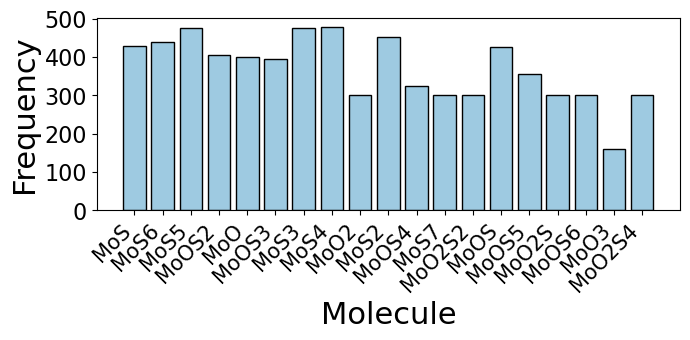

In [18]:
from tkinter import font
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 假设second_feature_int是包含标签的数组
# 例如: second_feature_int = np.array([1, 2, 2, 3, 3, 3, 1, ...])
molecule = np.array([val for val in y_test[:,-1, 0]])
# 统计每个标签的频率
label_counts = Counter(molecule )

# 提取标签和对应的频率
labels = list(label_counts.keys())
counts = list(label_counts.values())

# 绘制条形图
plt.figure(figsize=(7, 3.5))
plt.bar(labels, counts, color='#9ECAE1', edgecolor='black')

# 设置x轴标签倾斜45度
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=16)
# 添加标题和轴标签
# plt.title('Frequency of Each Label')
plt.xlabel('Molecule',fontsize=22)
plt.ylabel('Frequency',fontsize=22)

# 显示网格
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()  # 自动调整布局，避免标签被截断
plt.show()

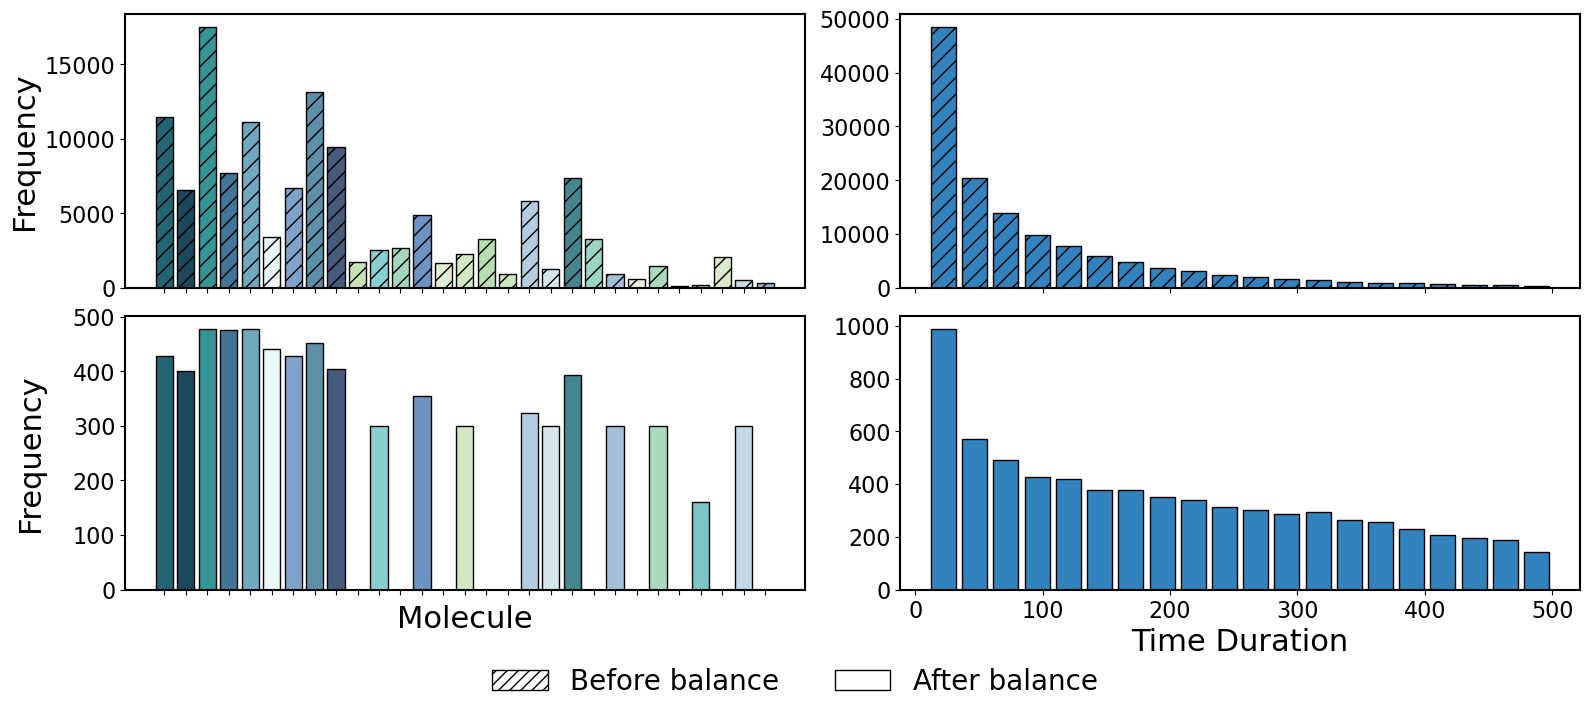

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import matplotlib.patches as mpatches
import seaborn as sns

color1 = '#8DD66B'
color2 = '#3182BD'#'#9ECAE1'

import matplotlib.colors as mcolors

# 原始 color_dict
color_dict_hy = {
    "MoO": "#0077b6",        # 深海蓝
    "MoOS2": "#00b4d8",      # 青蓝
    "MoS": "#48cae4",        # 浅蓝
    "MoS3": "#90e0ef",       # 雾蓝
    "MoS5": "#ade8f4",       # 冰蓝
    "MoO5": "#caf0f8",       # 淡水蓝
    "MoOS3": "#007f5f",      # 深绿
    "MoS2": "#2b9348",       # 海草绿
    "MoS4": "#55a630",       # 青绿
    "Mo3O9S2": "#80b918",    # 青黄
    "MoO3": "#ff7b00",       # 珊瑚橙
    "MoO2": "#ffb703",       # 阳光橙
    "Mo3O9": "#023e8a",      # 宝蓝
    "Mo2S7": "#007f7f",      # 青蓝灰
    "Mo2S8": "#0096c7",      # 天蓝
    "MoO2S": "#00b4d8",      # 再浅蓝
    "Mo2S2": "#48cae4",      # 淡蓝
    "Mo2S6": "#90e0ef",      # 雾蓝
    "MoO5S": "#ade8f4",      # 冰蓝
    "Mo": "#023047",         # 深海蓝
    "Mo2S10": "#219ebc",     # 宝石蓝
    "MoOS6": "#8ecae6",      # 浅海蓝
    "Mo2S5": "#0077b6",      # 海蓝
    "Mo2S9": "#00b4d8",      # 青蓝
    "MoO2S5": "#48cae4",     # 浅蓝
    "Mo2S4": "#90e0ef",      # 雾蓝
    "MoO2S7": "#ade8f4",     # 冰蓝
    "Mo2S3": "#00b4d8",      # 青蓝
    "MoS6": "#48cae4",       # 浅蓝
    "MoS7": "#90e0ef",       # 雾蓝
    "MoO2S4": "#caf0f8",     # 淡水蓝
    "MoOS4": "#007f5f",      # 深绿
    "MoO2S2": "#2b9348",     # 海草绿
    "MoO2S3": "#55a630",     # 青绿
    "MoOS": "#80b918",       # 青黄
    "MoOS5": "#ff7b00",      # 珊瑚橙
    "MoOS7": "#ffb703"       # 阳光橙
}

color_dict = {
    "MoO":     "#003f5c", "MoOS2":   "#2f4b7c", "MoS":     "#005f73",
    "MoS3":    "#0a9396", "MoS5":    "#1d6996", "MoO5":    "#2a9d8f",
    "MoOS3":   "#26828e", "MoS2":    "#3a86a8", "MoS4":    "#4b9fbf",
    "Mo3O9S2": "#57a7b3", "MoO3":    "#5ec4c4", "MoO2":    "#6acfcf",
    "Mo3O9":   "#76d1c4", "Mo2S7":   "#81d4bb", "Mo2S8":   "#8bd7b1",
    "MoO2S":   "#94dab1", "Mo2S2":   "#9bdba4", "Mo2S6":   "#a6de9b",
    "MoO5S":   "#b1e197", "Mo":      "#b8e3a0", "Mo2S10":  "#c0e6a8",
    "MoOS6":   "#c9e8b1", "Mo2S5":   "#d2eabc", "Mo2S9":   "#d9edc6",
    "MoO2S5":  "#e0f0ce", "Mo2S4":   "#e6f2d7", "MoO2S7":  "#ebf4de",
    "Mo2S3":   "#f0f6e4", "MoS6":    "#e0f7f3", "MoS7":    "#cce5ec",
    "MoO2S4":  "#b7d4e7", "MoOS4":   "#a1c3e0", "MoO2S2":  "#8cb3da",
    "MoO2S3":  "#75a1d2", "MoOS":    "#5e90cb", "MoOS5":   "#487fc3",
    "MoOS7":   "#316ebb"
}

color_dict2 = {
    # 蓝系（深→浅）
    "MoO":     "#2F5D8C",
    "Mo2S10":  "#3C6FA3",
    "Mo2S3":   "#4C7FB5",
    "Mo3O9":   "#5E8FC7",
    "MoO2S":   "#7FA6CF",
    "MoS6":    "#94B8D9",
    "MoO2S2":  "#A7C6E0",

    # 绿系（深→浅）
    "MoOS2":   "#2F6F4E",
    "Mo2S7":   "#3E855E",
    "Mo2S6":   "#4E9C6E",
    "MoO5":    "#5FAE7D",
    "Mo2S4":   "#7FBF8F",
    "MoS7":    "#94CDA0",
    "MoO2S3":  "#A8D9B3",

    # 黄系（深→浅）
    "MoS":     "#A0741A",
    "MoO3":    "#B6892C",
    "Mo2S8":   "#CFA63D",
    "MoO2S7":  "#DAB757",
    "MoO2S4":  "#E3C87A",
    "MoO5S":   "#ECD89B",
    "MoOS":    "#F1E1B3",

    # 紫系（深→浅）
    "MoS3":    "#603B8B",
    "Mo2S2":   "#724E9B",
    "MoOS3":   "#8A6FAD",
    "Mo2S9":   "#9A84B8",
    "MoOS5":   "#B09BC8",
    "MoOS7":   "#C3AFD4",
    "MoS4":    "#D2C1DE",

    # 额外分子分配剩余层次（保持色系均衡）
    "MoS5":    "#5687B0",
    "Mo3O9S2": "#65A07C",
    "MoO2":    "#D0B05B",
    "Mo":      "#A687C2",
    "MoOS6":   "#7FB58A",
    "Mo2S5":   "#BE9F43",
    "MoO2S5":  "#C6A64D",
    "MoOS4":   "#B8A0CC"
}

color_dict2 = {
    "MoO":     "#4C8CBF",  # 深蓝
    "MoOS2":   "#5FA8A8",  # 青蓝
    "MoS":     "#7FA9C4",  # 浅蓝
    "MoS3":    "#9AAFCF",  # 灰蓝
    "MoS5":    "#6F9FBF",  # 蓝灰
    "MoO5":    "#A1B8C4",  # 浅灰蓝
    "MoOS3":   "#8CA2B8",  # 青灰
    "MoS2":    "#B0B0B0",  # 中灰
    "MoS4":    "#7F8FB3",  # 灰紫
    "Mo3O9S2": "#5C92A5",  # 深青
    "MoO3":    "#9EB0C2",
    "MoO2":    "#7AA6B5",
    "Mo3O9":   "#6B95A8",
    "Mo2S7":   "#8A9EC0",
    "Mo2S8":   "#6B8FB0",
    "MoO2S":   "#A4BAC4",
    "Mo2S2":   "#7D8FB7",
    "Mo2S6":   "#A9A9A9",
    "MoO5S":   "#7FA7B2",
    "Mo":      "#5F87A2",
    "Mo2S10":  "#6C94AC",
    "MoOS6":   "#93ACBC",
    "Mo2S5":   "#7B8CB0",
    "Mo2S9":   "#6F95A7",
    "MoO2S5":  "#8EA7B7",
    "Mo2S4":   "#5E8DA8",
    "MoO2S7":  "#7C96AB",
    "Mo2S3":   "#4F88C4",
    "MoS6":    "#7E90B8",
    "MoS7":    "#6D9BA8",
    "MoO2S4":  "#90A6B8",
    "MoOS4":   "#8090AA",
    "MoO2S2":  "#9CC0C0",
    "MoO2S3":  "#6C9FB0",
    "MoOS":    "#A0B2B8",
    "MoOS5":   "#8FA1B0",
    "MoOS7":   "#9BA8BA"
}

color_dict0 = {
    "MoO":     "#8DD3C7",
    "MoOS2":   "#FDB462",
    "MoS":     "#B3DE69",
    "MoS3":    "#FB8072",
    "MoS5":    "#80B1D3",
    "MoO5":    "#FFFFB3",
    "MoOS3":   "#FCCDE5",
    "MoS2":    "#D9D9D9",
    "MoS4":    "#BC80BD",
    "Mo3O9S2": "#CCEBC5",
    "MoO3":    "#FFD700",
    "MoO2":    "#FFA07A",
    "Mo3O9":   "#98FB98",
    "Mo2S7":   "#FF69B4",
    "Mo2S8":   "#87CEFA",
    "MoO2S":   "#FFE4B5",
    "Mo2S2":   "#9370DB",
    "Mo2S6":   "#C0C0C0",
    "MoO5S":   "#ADFF2F",
    "Mo":      "#FF6347",
    "Mo2S10":  "#4682B4",
    "MoOS6":   "#FFDAB9",
    "Mo2S5":   "#BA55D3",
    "Mo2S9":   "#9ACD32",
    "MoO2S5":  "#FFA500",
    "Mo2S4":   "#7FFFD4",
    "MoO2S7":  "#FF4500",
    "Mo2S3":   "#1E90FF",
    "MoS6":    "#DA70D6",
    "MoS7":    "#32CD32",
    "MoO2S4":  "#FFB347",
    "MoOS4":   "#FF6961",
    "MoO2S2":  "#77DD77",
    "MoO2S3":  "#AEC6CF",
    "MoOS":    "#FFD1DC",
    "MoOS5":   "#CBAACB",
    "MoOS7":   "#F49AC2"
}
color_dict0 = {
    "MoO":     "#5DA5A4",
    "MoOS2":   "#E0A458",
    "MoS":     "#91B86C",
    "MoS3":    "#D97A7A",
    "MoS5":    "#6C9ACF",
    "MoO5":    "#E6E29B",
    "MoOS3":   "#D8A8C2",
    "MoS2":    "#B7B7B7",
    "MoS4":    "#9D7FB3",
    "Mo3O9S2": "#A5C7B1",
    "MoO3":    "#D5B556",
    "MoO2":    "#E3A88A",
    "Mo3O9":   "#9FCB9F",
    "Mo2S7":   "#DB88B4",
    "Mo2S8":   "#8AB6D6",
    "MoO2S":   "#E2C28C",
    "Mo2S2":   "#8D85C6",
    "Mo2S6":   "#BFBFBF",
    "MoO5S":   "#A7CF78",
    "Mo":      "#D9826A",
    "Mo2S10":  "#5F87A2",
    "MoOS6":   "#E6C5A3",
    "Mo2S5":   "#A882C9",
    "Mo2S9":   "#92B562",
    "MoO2S5":  "#D2A158",
    "Mo2S4":   "#7FBFB5",
    "MoO2S7":  "#D0714F",
    "Mo2S3":   "#4F88C4",
    "MoS6":    "#B58BCB",
    "MoS7":    "#7FB379",
    "MoO2S4":  "#DDA86F",
    "MoOS4":   "#D67F82",
    "MoO2S2":  "#9CCF9C",
    "MoO2S3":  "#94B6C6",
    "MoOS":    "#E4B7C0",
    "MoOS5":   "#B6A3B6",
    "MoOS7":   "#D6A4BE"
}
def desaturate_hex(hex_color, factor=0.5):
    """降低饱和度 factor (0~1)"""
    rgb = mcolors.hex2color(hex_color)
    hsv = mcolors.rgb_to_hsv(rgb)
    hsv[1] *= factor  # 降低饱和度
    rgb_new = mcolors.hsv_to_rgb(hsv)
    return mcolors.to_hex(rgb_new)

# 生成低饱和 color_dict
color_dict = {mol: desaturate_hex(c, factor=0.7) for mol, c in color_dict.items()}




# --------------------------
# 1. 准备分子频率数据
# --------------------------
molecule1 = np.array([val for val in filtered_y[:, -1, 0]])
label_counts1 = Counter(molecule1)
labels1 = list(label_counts1.keys())
counts1 = list(label_counts1.values())

molecule2 = np.array([val for val in y_test[:, -1, 0]])
label_counts2 = Counter(molecule2)
labels2 = list(label_counts2.keys())
counts2 = list(label_counts2.values())

# --------------------------
# 2. 准备时间持续数据
# --------------------------
time1 = np.array([int(val) for val in filtered_y[:, -1, 1]])
time2 = np.array([int(val) for val in y_test[:, -1, 1]])

# --------------------------
# 3. 创建组合图表
# --------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 7))

# 定义色块标签（只加色块边框）
filtered_patch = mpatches.Patch(
    facecolor=color1, edgecolor="black", linewidth=1, label='Origin Data'
)
test_patch = mpatches.Patch(
    facecolor=color2, edgecolor="black", linewidth=1, label='Processed Data'
)

# 假设 labels1 和 labels2 是你的分子列表
colors1 = [color_dict.get(mol, "#D3D3D3") for mol in labels1]  # 如果缺失，默认灰色
colors2 = [color_dict.get(mol, "#D3D3D3") for mol in labels2]

# --------------------------
# 4. 绘制分子频率条形图（上排）
# --------------------------
axes[0, 0].bar(labels1, counts1, color=colors1, hatch='//', edgecolor='black')
# axes[0, 0].set_xlabel('Molecule', fontsize=22)
axes[0, 0].set_ylabel('Frequency', fontsize=22)
# axes[0, 0].tick_params(axis='x', rotation=45, labelsize=13)
axes[0, 0].set_xticklabels([])
axes[0, 0].tick_params(axis='y', labelsize=16)

# axes[1, 0].bar(labels2, counts2, color=colors2, edgecolor='black')
# # axes[1, 0].set_xlabel('Molecule', fontsize=22)
# # axes[1, 0].tick_params(axis='x', rotation=45, labelsize=13)
# axes[1, 0].set_xticklabels([])
# axes[1, 0].tick_params(axis='y', labelsize=16)
# axes[1, 0].set_ylabel('Frequency', fontsize=22)
# 以左上角 labels1 为基准
base_labels = labels1  # 左上角的分子顺序

# 1️⃣ 生成与 base_labels 顺序匹配的下图数据
aligned_counts2 = []
aligned_colors2 = []
for lab in base_labels:
    if lab in label_counts2:                 # 下图有这个分子
        aligned_counts2.append(label_counts2[lab])
        aligned_colors2.append(color_dict.get(lab, "#D3D3D3"))
    else:                                    # 没有数据则补0和默认灰色
        aligned_counts2.append(0)
        aligned_colors2.append("#D3D3D3")

# 2️⃣ 重新绘制左下角条形图
axes[1, 0].cla()  # 清空原图
axes[1, 0].bar(base_labels, aligned_counts2,
               color=aligned_colors2, edgecolor='black', label='origin data')
axes[1, 0].set_xlabel('Molecule', fontsize=22)
axes[1, 0].set_ylabel('Frequency', fontsize=22, labelpad=20)
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=13)
axes[1, 0].tick_params(axis='y', labelsize=16)
axes[1, 0].set_xticklabels([])
# --------------------------
# 5. 绘制时间持续直方图（下排）
# --------------------------
axes[0, 1].hist(time1, bins=20, color=color2, hatch='//', edgecolor='black', rwidth=0.8)
# axes[0, 1].set_xlabel('Time Duration', fontsize=22)
axes[0, 1].tick_params(axis='x', labelsize=16)
axes[0, 1].tick_params(axis='y', labelsize=16)
axes[0, 1].set_xticklabels([])
axes[1, 1].hist(time2, bins=20, color=color2, edgecolor='black', rwidth=0.8)
axes[1, 1].set_xlabel('Time Duration', fontsize=22)
axes[1, 1].tick_params(axis='x', labelsize=16)
axes[1, 1].tick_params(axis='y', labelsize=16)

# --------------------------
# 6. 添加色块标签（只保留色块边框）
# --------------------------
# fig.legend(
#     handles=[filtered_patch, test_patch],
#     loc='lower center',
#     ncol=2, fontsize=20,
#     bbox_to_anchor=(0.5, -0.07),
#     frameon=False  # 去掉整个 legend 外框
# )
for ax in axes.flat:  # 遍历所有子图
    for spine in ax.spines.values():  # spines 包括 'top','bottom','left','right'
        spine.set_linewidth(1.5)     # 设置边框粗细
# ----------- 统一添加图例 -----------
origin_patch    = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Before balance')
processed_patch = mpatches.Patch(facecolor='white', edgecolor='black',  label='After balance')

# 只需要一个总图例即可，放在整张图外或空白处
fig.legend(handles=[origin_patch, processed_patch],
           loc='lower center', bbox_to_anchor=(0.5, -0.07),
           ncol=2, fontsize=20, frameon=False)
# --------------------------
# 7. 布局优化
# --------------------------
plt.tight_layout()
plt.subplots_adjust(top=0.94)

plt.show()


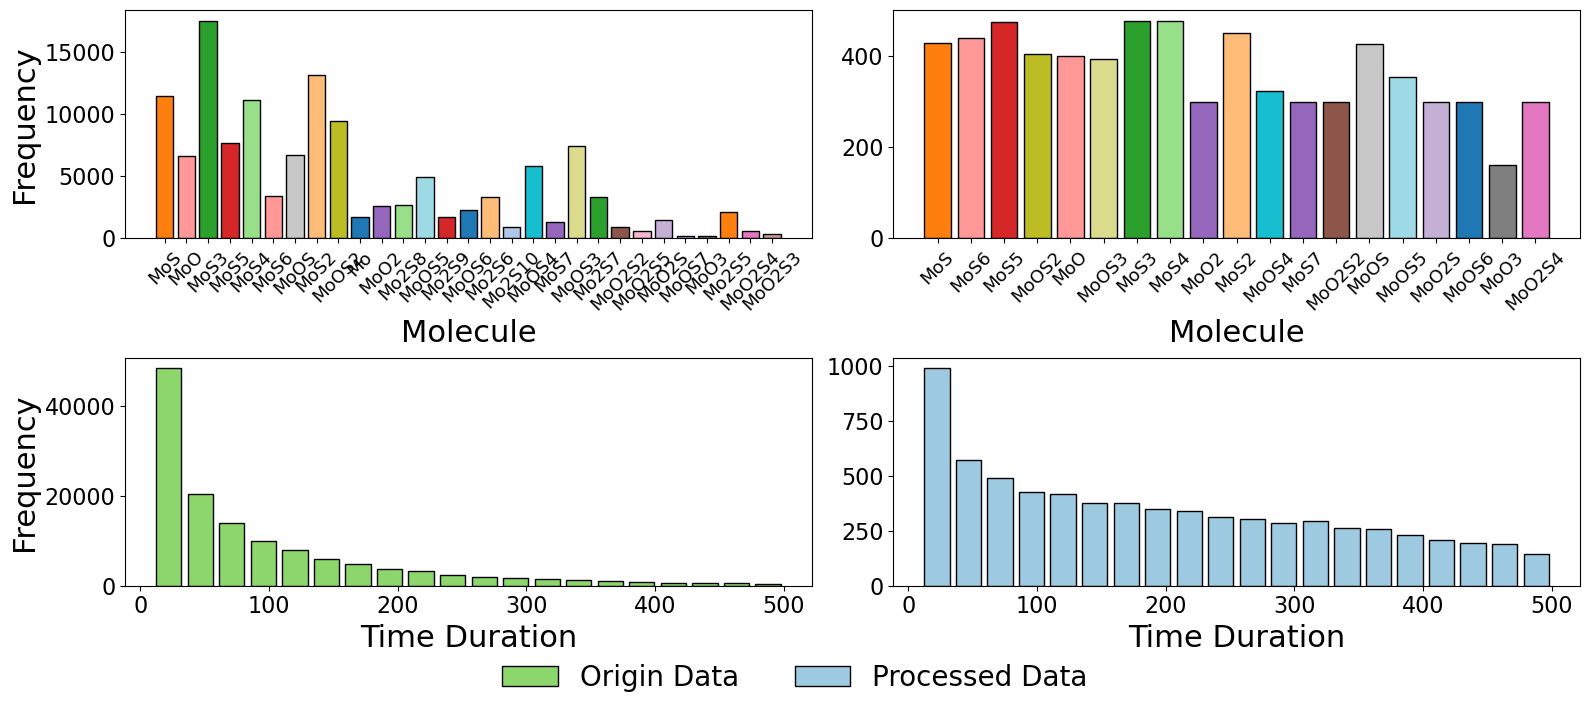

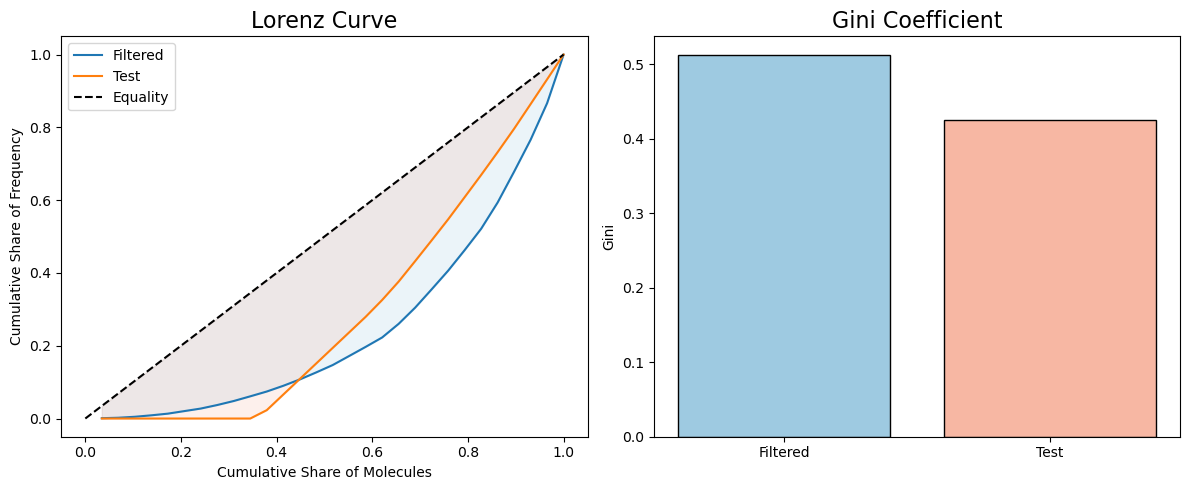

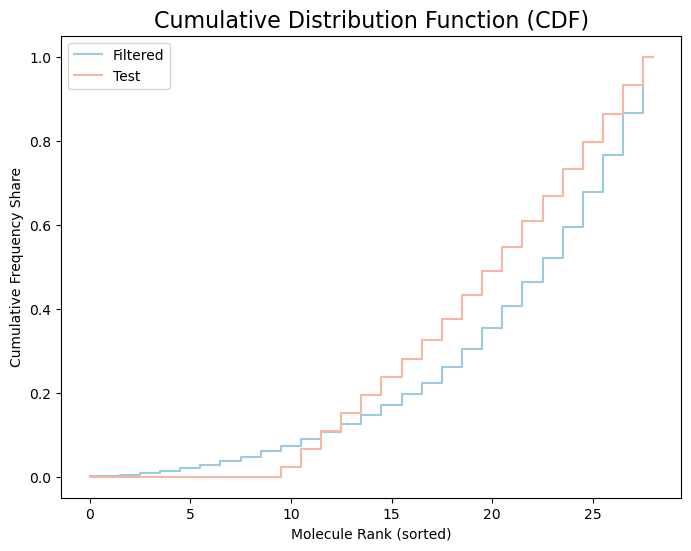

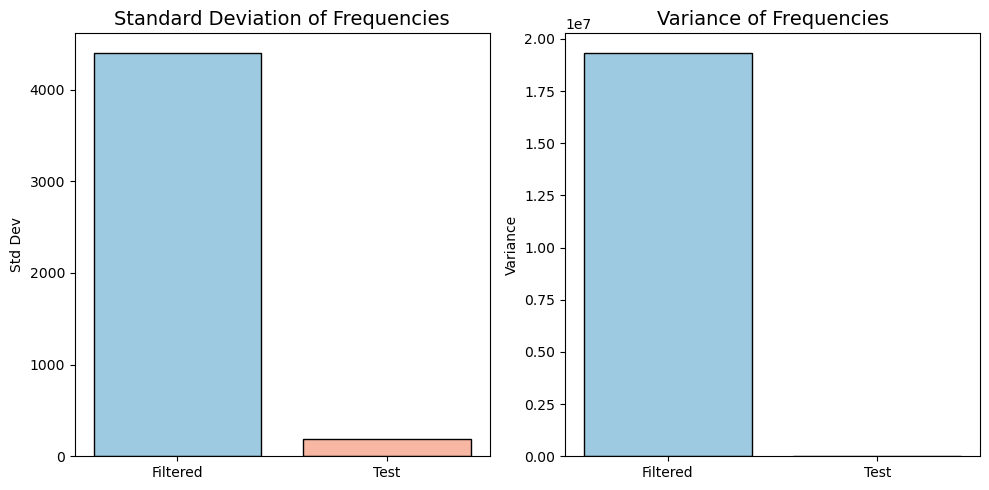

C:\Users\dfgje\AppData\Local\Temp\ipykernel_18052\4122774795.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Filtered", "Test"])


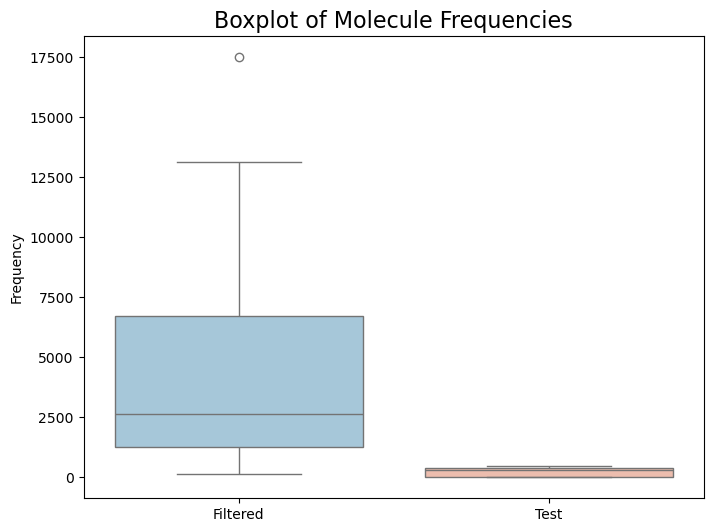

KL(P||Q) = inf
KL(Q||P) = 0.4148
JS Divergence = 0.0966


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy.stats import entropy
import seaborn as sns

# --------------------------
# 1. 准备分子频率数据
# --------------------------
# 从filtered_y提取分子标签并统计频率
molecule1 = np.array([val for val in filtered_y[:, -1, 0]])
label_counts1 = Counter(molecule1)
labels1 = list(label_counts1.keys())
counts1 = np.array(list(label_counts1.values()))

# 从y_test提取分子标签并统计频率
molecule2 = np.array([val for val in y_test[:, -1, 0]])
label_counts2 = Counter(molecule2)
labels2 = list(label_counts2.keys())
counts2 = np.array(list(label_counts2.values()))

# 确保顺序一致（按分子名称排序）
labels = sorted(set(labels1) | set(labels2))
counts1 = np.array([label_counts1.get(l, 0) for l in labels])
counts2 = np.array([label_counts2.get(l, 0) for l in labels])

# --------------------------
# 2. Gini 系数 & Lorenz 曲线
# --------------------------
def gini_coefficient(x):
    """计算 Gini 系数"""
    x = np.sort(x)
    n = len(x)
    cumx = np.cumsum(x)
    gini = (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    return gini

gini1 = gini_coefficient(counts1)
gini2 = gini_coefficient(counts2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for counts, color, name in [(counts1, "#9ECAE1", "Filtered"), (counts2, "#F7B7A3", "Test")]:
    sorted_counts = np.sort(counts)
    cum_counts = np.cumsum(sorted_counts) / np.sum(sorted_counts)
    cum_pop = np.arange(1, len(counts) + 1) / len(counts)
    ax[0].plot(cum_pop, cum_counts, label=f"{name}")
    ax[0].fill_between(cum_pop, cum_counts, cum_pop, alpha=0.2, color=color)
ax[0].plot([0, 1], [0, 1], 'k--', label="Equality")
ax[0].set_title("Lorenz Curve", fontsize=16)
ax[0].set_xlabel("Cumulative Share of Molecules")
ax[0].set_ylabel("Cumulative Share of Frequency")
ax[0].legend()

ax[1].bar(["Filtered", "Test"], [gini1, gini2], color=["#9ECAE1", "#F7B7A3"], edgecolor="black")
ax[1].set_title("Gini Coefficient", fontsize=16)
ax[1].set_ylabel("Gini")

plt.tight_layout()
plt.show()

# --------------------------
# 3. 累积分布函数 (CDF)
# --------------------------
fig, ax = plt.subplots(figsize=(8, 6))
for counts, color, name in [(counts1, "#9ECAE1", "Filtered"), (counts2, "#F7B7A3", "Test")]:
    sorted_counts = np.sort(counts)
    cdf = np.cumsum(sorted_counts) / np.sum(sorted_counts)
    ax.step(range(len(sorted_counts)), cdf, where="mid", label=name, color=color)
ax.set_title("Cumulative Distribution Function (CDF)", fontsize=16)
ax.set_xlabel("Molecule Rank (sorted)")
ax.set_ylabel("Cumulative Frequency Share")
ax.legend()
plt.show()

# --------------------------
# 4. 方差/标准差对比
# --------------------------
std1, std2 = np.std(counts1), np.std(counts2)
var1, var2 = np.var(counts1), np.var(counts2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(["Filtered", "Test"], [std1, std2], color=["#9ECAE1", "#F7B7A3"], edgecolor="black")
ax[0].set_title("Standard Deviation of Frequencies", fontsize=14)
ax[0].set_ylabel("Std Dev")

ax[1].bar(["Filtered", "Test"], [var1, var2], color=["#9ECAE1", "#F7B7A3"], edgecolor="black")
ax[1].set_title("Variance of Frequencies", fontsize=14)
ax[1].set_ylabel("Variance")

plt.tight_layout()
plt.show()

# --------------------------
# 5. 箱线图 (Boxplot)
# --------------------------
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=[counts1, counts2], palette=["#9ECAE1", "#F7B7A3"])
ax.set_xticklabels(["Filtered", "Test"])
ax.set_title("Boxplot of Molecule Frequencies", fontsize=16)
ax.set_ylabel("Frequency")
plt.show()

# --------------------------
# 6. KL 散度 / JS 散度
# --------------------------
# 转换为概率分布
p = counts1 / counts1.sum()
q = counts2 / counts2.sum()

kl_pq = entropy(p, q)  # KL(P||Q)
kl_qp = entropy(q, p)  # KL(Q||P)
js = 0.5 * (entropy(p, (p+q)/2) + entropy(q, (p+q)/2))

print(f"KL(P||Q) = {kl_pq:.4f}")
print(f"KL(Q||P) = {kl_qp:.4f}")
print(f"JS Divergence = {js:.4f}")


C:\Users\dfgje\AppData\Local\Temp\ipykernel_18052\1061740225.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\dfgje\AppData\Local\Temp\ipykernel_18052\1061740225.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


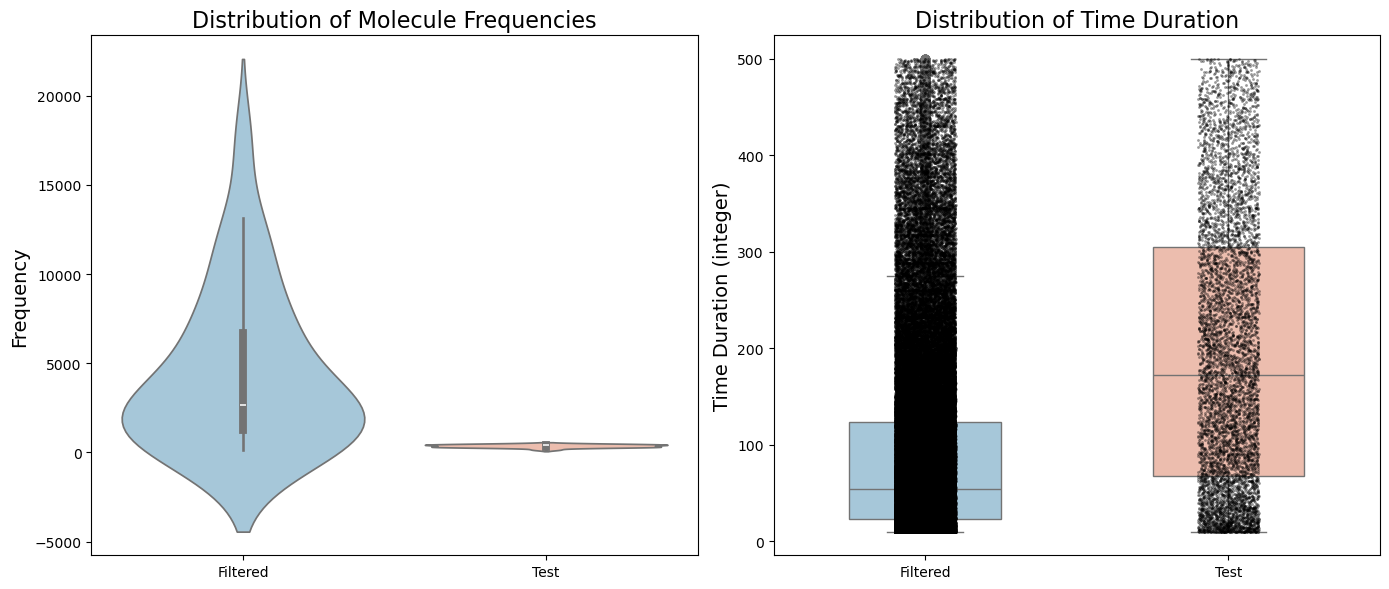

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --------------------------
# 1. Molecule Frequency 数据
# --------------------------
df_freq1 = pd.DataFrame({"Value": counts1, "Dataset": "Filtered"})
df_freq2 = pd.DataFrame({"Value": counts2, "Dataset": "Test"})
df_freq = pd.concat([df_freq1, df_freq2])
df_freq["Type"] = "Molecule Frequency"

# --------------------------
# 2. Time Duration 数据（整数）
# --------------------------
df_time1 = pd.DataFrame({"Value": time1, "Dataset": "Filtered"})
df_time2 = pd.DataFrame({"Value": time2, "Dataset": "Test"})
df_time = pd.concat([df_time1, df_time2])
df_time["Type"] = "Time Duration"

# --------------------------
# 3. 绘制子图：左边 Molecule，右边 Time
# --------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=False)

# Molecule Frequency：用 Violin + Boxplot
sns.violinplot(
    x="Dataset", y="Value", data=df_freq,
    palette=["#9ECAE1", "#F7B7A3"], inner="box", ax=axes[0]
)
axes[0].set_title("Distribution of Molecule Frequencies", fontsize=16)
axes[0].set_xlabel("")
axes[0].set_ylabel("Frequency", fontsize=14)

# Time Duration：用 Boxplot + stripplot
sns.boxplot(
    x="Dataset", y="Value", data=df_time,
    palette=["#9ECAE1", "#F7B7A3"], width=0.5, ax=axes[1]
)
sns.stripplot(
    x="Dataset", y="Value", data=df_time,
    color="black", alpha=0.4, size=2, jitter=True, ax=axes[1]
)
axes[1].set_title("Distribution of Time Duration", fontsize=16)
axes[1].set_xlabel("")
axes[1].set_ylabel("Time Duration (integer)", fontsize=14)

# 调整布局
plt.tight_layout()
plt.show()


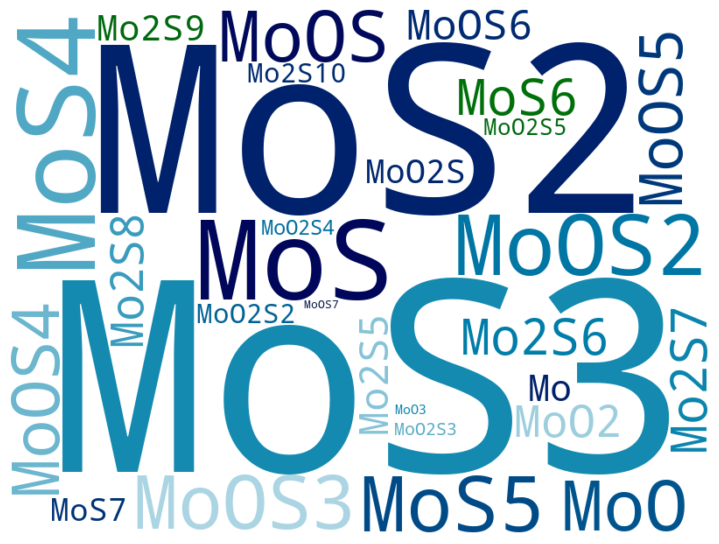

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 假设second_feature_int是包含整数标签的数组
# 将整数标签转换为字符串
# str_labels = [str(label) for label in second_feature_int]

# 统计每个标签的频率
label_counts = Counter(molecule1)

# 转换为词云所需的字典格式 {标签: 频率}
word_freq = dict(label_counts)

# 创建词云对象，设置参数
wordcloud = WordCloud(
    width=800,            # 宽度
    height=600,           # 高度
    background_color='white',  # 背景色
    colormap='ocean',     # 颜色方案
    max_words=50,         # 最大显示词数
    contour_width=1,      # 轮廓宽度
    contour_color='steelblue'  # 轮廓颜色
).generate_from_frequencies(word_freq)

# 绘制词云图
plt.figure(figsize=(7, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
# plt.title('Frequency of Molecules', fontsize=20)
plt.tight_layout(pad=0)  # 调整布局
plt.show()

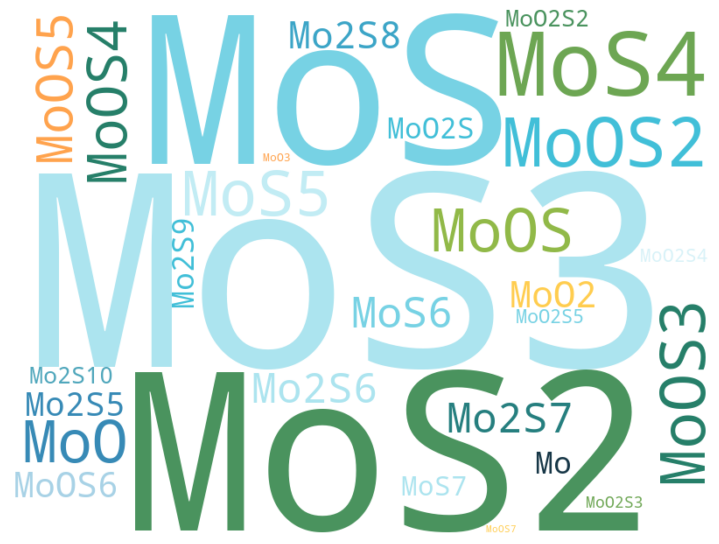

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 假设 molecule1 是你的分子标签列表
label_counts = Counter(molecule1)
word_freq = dict(label_counts)

# 自定义 color_func
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # 如果字典里没有该分子，默认黑色
    return color_dict.get(word, "#000000")  

# 创建词云对象
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    max_words=50,
    contour_width=1,
    contour_color='steelblue'
).generate_from_frequencies(word_freq)

# 将自定义颜色应用到词云
wordcloud.recolor(color_func=color_func)

# 绘制词云
plt.figure(figsize=(7, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

def balanced_sampling_for_y(X, y, bins=10, samples_per_formula=300, seed=42):
    """
    分别对 y 的两个维度独立平衡：
    - y[:, 0]：字符串标签（如分子式）等量采样
    - y[:, 1]：整数（持续时间）标签分箱后平衡

    参数：
    - X: numpy array, shape (n_samples, 3, 2)
    - y: numpy array, shape (n_samples, 2)
    - bins: int, 用于持续时间的分箱数量
    - samples_per_formula: int，每种化学式最多采样数量
    - seed: int, 随机种子

    返回：
    - X_sampled, y_sampled
    """
    np.random.seed(seed)

    # 将 y 转换为 DataFrame
    formula = y[:, 0]
    durations = y[:, 1].astype(int)
    df = pd.DataFrame({
        "formula": formula,
        "duration": durations
    })

    # ===== 1. 平衡 duration：按 bins 分箱后每组取最小样本数 =====
    df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=False)
    min_count_duration = df['duration_bin'].value_counts().min()
    duration_sampled_idx = pd.concat([
        group.sample(min_count_duration, random_state=seed)
        for _, group in df.groupby('duration_bin')
    ]).index

    # ===== 2. 平衡 formula：每类取 samples_per_formula 个 =====
    formula_sampled_idx = []
    for _, group in df.groupby("formula"):
        if len(group) <= samples_per_formula:
            sampled = group.index.tolist()
        else:
            sampled = group.sample(samples_per_formula, random_state=seed).index.tolist()
        formula_sampled_idx.extend(sampled)

    # ===== 3. 合并索引（取并集）=====
    combined_indices = sorted(set(duration_sampled_idx).union(set(formula_sampled_idx)))

    # ===== 4. 获取采样后的 X 和 y =====
    X_sampled = X[combined_indices]
    y_sampled = y[combined_indices]

    # ===== 5. 打印采样后分布 =====
    print(f"\n最终样本数: {len(y_sampled)}")
    print("\n📊 持续时间（分箱后）分布:")
    print(pd.cut(df.loc[combined_indices, 'duration'], bins=bins, labels=False).value_counts().sort_index())
    print("\n🔬 化学式分布:")
    print(df.loc[combined_indices, 'formula'].value_counts())

    return X_sampled, y_sampled

# ===== 示例调用 =====
X_sampled, y_sampled = balanced_sampling_for_y(
    filtered_X, filtered_y,
    bins=10,
    samples_per_formula=300,
    seed=42
)


ValueError: invalid literal for int() with base 10: 'MoS3'

In [ ]:
import numpy as np
import pandas as pd

# 处理 X 数据，每一行转换为指定格式
X_str = [";".join([f"({item[0]},{item[1]})" for item in row]) for row in X_test]
# X_str = [";".join([f"{str(item[0])}, {str(item[1])}, {str(item[2])}" for item in row]) for row in X]
# 处理 y 数据，每一行转换为指定格式
# y_str = [f"({str(row[0])},{str(row[1])})" for row in y]
y_str = [";".join([f"({item[0]},{item[1]})" for item in row]) for row in y_test]
# y_str = [f"({item[0]},{item[1]})" for item in y_test] 
# 创建 DataFrame
# X_str = np.concatenate(X_str)
# y_str = np.concatenate(y_str)
# # y_str = np.concatenate(y_str)
df = pd.DataFrame({"X": X_str, "y": y_str})
print(len(X_str), len(y_str))
# # 导出 CSV

df.to_csv("average_data_s3.csv", index=False)

print("CSV 文件已导出")


7015 7015
CSV 文件已导出


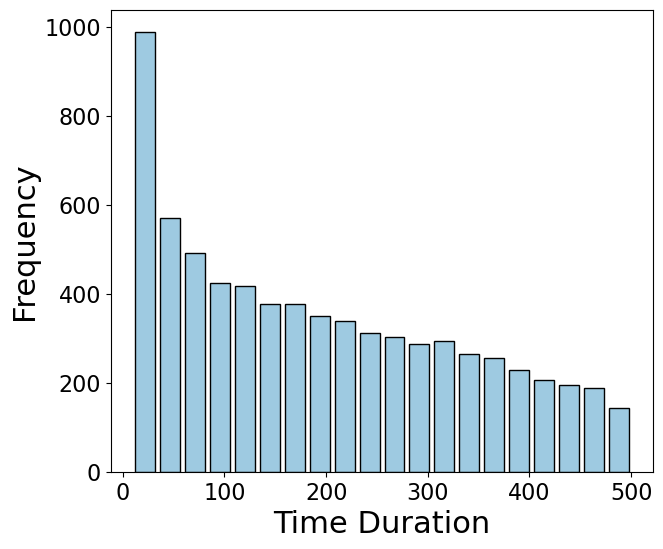

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# second_feature_int = np.array([int(val) for val in y[:, 1]])
second_feature_int = np.array([int(val) for val in y_test[:,-1, 1]])
# 使用Matplotlib绘制直方图
plt.figure(figsize=(7, 6))
plt.hist(second_feature_int, bins=20, color='#9ECAE1', edgecolor='black', rwidth=0.8)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('Histogram of y_train')
plt.xlabel('Time Duration', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
# plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# 转换成 DataFrame 方便处理
y_df = pd.DataFrame(filtered_y, columns=['formula', 'label'])  # 'label' 是 y 的第二列
y_df['label'] = y_df['label'].astype(int)  # 确保是整数

# 查看每个类别的样本数
label_counts = y_df['label'].value_counts()
print("原始各类别样本数：")
print(label_counts)

# 确定可以抽样的最大样本数（例如每个 label 至少有 500 个，我们就能从每个里抽 500 个）
min_count = label_counts.min()
print(f"\n将从每类中抽取 {min_count} 个样本使分布尽量平衡")

# 收集抽样的索引
sampled_indices = []

for label_value in label_counts.index:
    indices = y_df[y_df['label'] == label_value].index
    sampled = np.random.choice(indices, min_count, replace=False)
    sampled_indices.extend(sampled)

# 得到平衡后的样本
X_balanced = filtered_X[sampled_indices]
y_balanced = filtered_y[sampled_indices]


原始各类别样本数：
label
10     3086
11     3027
12     2630
13     2531
14     2208
       ... 
486       8
485       8
491       8
429       8
479       2
Name: count, Length: 491, dtype: int64

将从每类中抽取 2 个样本使分布尽量平衡


In [ ]:
y_balanced.shape

(982, 2)

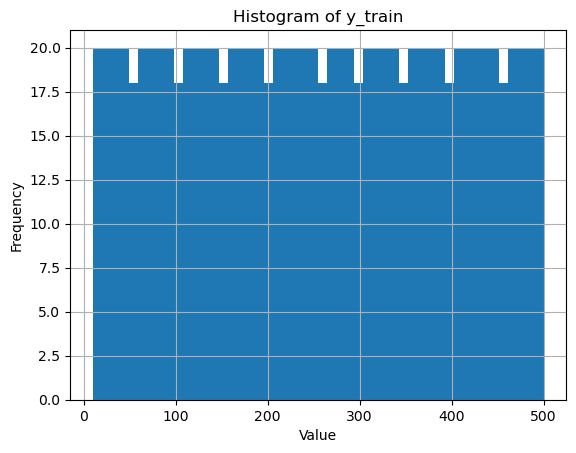

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
second_feature_int = np.array([int(val) for val in y_balanced[:, 1]])
# 使用Matplotlib绘制直方图
plt.hist(second_feature_int, bins=50)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

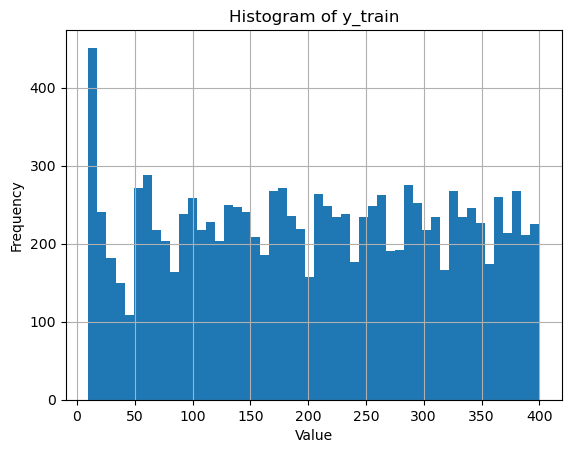

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
second_feature_int = np.array([int(val) for val in y_sampled[:, 1]])
# 使用Matplotlib绘制直方图
plt.hist(second_feature_int, bins=50)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# 构建 DataFrame
y_df = pd.DataFrame(filtered_y, columns=['formula', 'label'])
y_df['label'] = y_df['label'].astype(int)  # 确保是整数

# 使用 pd.cut 分成 10 组
y_df['group'] = pd.cut(y_df['label'], bins=10, labels=False)
# y_df['group'] = pd.qcut(y_df['label'], q=10, labels=False, duplicates='drop')
# 查看每组的样本数量
group_counts = y_df['group'].value_counts().sort_index()
print("每组原始样本数量：")
print(group_counts)

# 决定每组可以抽取的最小数量
min_count = group_counts.min()
print(f"\n每组将抽取 {min_count} 个样本")

# 抽样
sampled_indices = []

for group_id in range(10):
    indices = y_df[y_df['group'] == group_id].index
    sampled = np.random.choice(indices, min_count, replace=False)
    sampled_indices.extend(sampled)

# 得到均匀抽样后的数据
X_sampled = filtered_X[sampled_indices]
y_sampled = filtered_y[sampled_indices]

# 检查平衡情况
print("\n平衡后每组样本数：")
print(pd.DataFrame(y_sampled, columns=['formula', 'label']).assign(
    group=pd.cut(pd.to_numeric(y_sampled[:, 1]), bins=10, labels=False)
)['group'].value_counts().sort_index())


每组原始样本数量：
group
0    52861
1    19704
2    12310
3     8201
4     5562
5     4035
6     2750
7     2126
8     1601
9     1146
Name: count, dtype: int64

每组将抽取 1146 个样本

平衡后每组样本数：
group
0    1146
1    1146
2    1146
3    1146
4    1146
5    1146
6    1146
7    1146
8    1146
9    1146
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd

# 构建 DataFrame
y_df = pd.DataFrame(y_test, columns=['formula', 'label'])
y_df['label'] = y_df['label'].astype(int)

# 分成最多 10 组，避免重复边界报错
y_df['group'] = pd.qcut(y_df['label'], q=10, labels=False, duplicates='drop')

# 统计每组样本数
group_counts = y_df['group'].value_counts().sort_index()
print("每组原始样本数量：")
print(group_counts)

# 取最小组作为基准抽样数
min_count = group_counts.min()
print(f"\n每组将抽取 {min_count} 个样本")

# 抽样
sampled_indices = []

for group_id in group_counts.index:
    indices = y_df[y_df['group'] == group_id].index
    sampled = np.random.choice(indices, min_count, replace=False)
    sampled_indices.extend(sampled)

# 得到均匀抽样后的数据
X_sampled = X_test[sampled_indices]
y_sampled = y_test[sampled_indices]


每组原始样本数量：
group
0    1322
1     408
2     732
3     407
4     600
5     528
6     573
7     564
8     566
Name: count, dtype: int64

每组将抽取 407 个样本


In [ ]:
# 得到分组标签和区间边界
group_labels, bin_edges = pd.qcut(y_df['label'], q=10, labels=False, duplicates='drop', retbins=True)

# 替换 group 列
y_df['group'] = group_labels

# 打印区间边界
print("每组的数值区间（闭区间左开右闭）:")
for i in range(len(bin_edges)-1):
    print(f"组 {i}: ({bin_edges[i]:.2f}, {bin_edges[i+1]:.2f}]")


每组的数值区间（闭区间左开右闭）:
组 0: (1.00, 2.00]
组 1: (2.00, 3.00]
组 2: (3.00, 6.00]
组 3: (6.00, 9.00]
组 4: (9.00, 17.00]
组 5: (17.00, 31.00]
组 6: (31.00, 67.00]
组 7: (67.00, 139.00]
组 8: (139.00, 2082.00]


In [ ]:
X_test.shape

(6138, 3, 2)

In [ ]:
import numpy as np
import pandas as pd

# 处理 X 数据，每一行转换为指定格式
X_str = [";".join([f"{item[0]}" for item in row]) for row in X_test]
# X_str = [";".join([f"{str(item[0])}, {str(item[1])}, {str(item[2])}" for item in row]) for row in X_test]
# 处理 y 数据，每一行转换为指定格式
# y_str = [f"({str(row[0])},{str(row[1])})" for row in y_test]
# y_str = [f"{item[0]}" for item in y_test] 
y_str = [";".join([f"{item[0]}" for item in row]) for row in y_test]
# 创建 DataFrame
# X_str = np.concatenate(X_str)
# y_str = np.concatenate(y_str)
# # y_str = np.concatenate(y_str)
df = pd.DataFrame({"X": X_str, "y": y_str})
print(len(X_str), len(y_str))
# # 导出 CSV

df.to_csv("average_data_s2.csv", index=False)

print("CSV 文件已导出")


6407 6407
CSV 文件已导出


In [ ]:
import numpy as np
import pandas as pd

# 示例数据
# X = np.array([
#     [["Mo3O9", "26"], ["Mo3O9S2", "11"], ["MoO2", "97"]],
#     [["Mo3O9S2", "11"], ["MoO2", "97"], ["MoO2S2", "9"]],
#     [["MoO2", "97"], ["MoO2S2", "9"], ["MoOS", "2"]]
# ])

# y = np.array([
#     ["MoO2S2", "9"],
#     ["MoOS", "2"],
#     ["MoOS3", "9"]
# ])

# 处理 X 数据，每一行转换为指定格式
X_str = [[";".join([f"({item[0]}, {item[1]})" for item in items]) for items in row] for row in X]
# X_str = [";".join([f"{str(item[0])}, {str(item[1])}, {str(item[2])}" for item in row]) for row in X]
# 处理 y 数据，每一行转换为指定格式
# y_str = [f"({str(row[0])},{str(row[1])})" for row in y]
y_str = [[f"({item[0]}, {item[1]})" for item in row] for row in y]
# 创建 DataFrame
X_str = np.concatenate(X_str)
y_str = np.concatenate(y_str)
# y_str = np.concatenate(y_str)
df = pd.DataFrame({"X": X_str, "y": y_str})

# 导出 CSV

df.to_csv("train_data.csv", index=False)

print("CSV 文件已导出： train_data.csv")


IndexError: string index out of range

#### 查看指定长度行的内容

In [ ]:
import numpy as np

def get_rows_by_length(filtered_processed, record_lengths, target_length):
    """
    获取指定长度的行内容
    
    参数：
    - filtered_processed: 过滤后的数据，NumPy对象数组
    - record_lengths: 各行的长度列表
    - target_length: 需要获取的指定长度
    
    返回：
    - NumPy对象数组，包含所有长度等于target_length的行
    """
    # 使用列表推导式筛选出符合长度的行
    selected = [record for record, length in zip(filtered_processed, record_lengths) if length == target_length]
    
    # 转换为与原数据一致的NumPy对象数组格式
    return np.array(selected, dtype=object)

# 获取所有长度为100的行
target_len = 11
matching_rows = get_rows_by_length(new_filtered, new_lengths, target_len)

# 打印结果（带统计信息）
print(f"\n找到 {len(matching_rows)} 行长度为 {target_len} 的记录：")
for i, row in enumerate(matching_rows, 1):
    print(f"\n第 {i} 行数据（总长度 {len(row)}）:")
    for record in row:
        print(record)


找到 244 行长度为 11 的记录：

第 1 行数据（总长度 11）:
['Mo3O9' '154']
['MoO2' '1']
['MoO3' '4']
['MoO' '1']
['MoOS2' '6']
['MoS' '24']
['MoS3' '70']
['MoS5' '2']
['MoS3' '8']
['MoS4' '78']
['MoS6' '91']

第 2 行数据（总长度 11）:
['Mo3O9' '47']
['MoO2' '36']
['MoO' '2']
['MoO2' '12']
['MoO' '4']
['MoO2' '4']
['MoOS' '101']
['MoOS3' '2']
['MoS2' '9']
['MoS4' '10']
['MoS6' '2']

第 3 行数据（总长度 11）:
['Mo3O9' '106']
['MoO3' '10']
['MoO2' '2']
['MoO2S2' '1']
['MoOS' '126']
['MoOS3' '2']
['MoS2' '7']
['MoS4' '2']
['MoS2' '20']
['MoS4' '19']
['MoS6' '3']

第 4 行数据（总长度 11）:
['Mo3O9' '243']
['MoO2' '59']
['MoO' '1']
['MoO2S2' '1']
['MoOS2' '19']
['MoS2' '7']
['MoS4' '10']
['MoS2' '27']
['MoS4' '21']
['MoS2' '36']
['MoS6' '1']

第 5 行数据（总长度 11）:
['Mo3O9' '31']
['Mo3O9S2' '28']
['MoO2' '8']
['MoO' '126']
['MoOS2' '5']
['MoS' '43']
['MoS3' '2']
['MoS' '97']
['MoS2' '114']
['MoS4' '160']
['MoS6' '10']

第 6 行数据（总长度 11）:
['Mo3O9' '62']
['MoO3' '11']
['MoO2' '76']
['MoO2S2' '2']
['MoOS' '431']
['MoS' '75']
['MoOS2' '28']
['MoOS4'

### 3.(可选择执行)物种转变---图形化

#### 3.1.统计所有基元反应和相应的转变次数

In [ ]:
from collections import defaultdict
import pandas as pd

def build_reaction_network(processed_data):
    """
    构建反应网络图并统计反应次数
    Args:
        processed_data: 处理后的反应路径数据，形状为(N,)的数组，每个元素是[ [物种1, 时间1], [物种2, 时间2], ... ]
    Returns:
        nodes: 所有物种节点列表
        edges: 字典，键为元组 (source, target)，值为反应次数
    """
    # 使用defaultdict自动初始化未出现的键值为0
    reaction_counter = defaultdict(int)
    
    # 遍历所有反应路径
    for path in processed_data:
        # 遍历路径中的每个状态转换 (跳过最后一个状态)
        for i in range(len(path) - 1):
            current_species = path[i][0]  # 当前物种名称
            next_species = path[i+1][0]   # 下一个物种名称
            
            # 忽略同一物种的连续重复出现（无实际反应）
            if current_species != next_species:
                # 记录反应：current -> next
                reaction = (current_species, next_species)
                reaction_counter[reaction] += 1
                
    # 提取所有唯一节点
    nodes = set()
    for reaction in reaction_counter.keys():
        nodes.add(reaction[0])
        nodes.add(reaction[1])
    nodes = sorted(nodes)  # 排序以便后续处理
    
    return nodes, reaction_counter

def save_network_to_csv(nodes, edges, node_file="nodes.csv", edge_file="edges.csv"):
    """
    将网络保存为CSV文件
    Args:
        nodes: 节点列表
        edges: 边字典，格式 {(source, target): count}
        node_file: 节点保存路径
        edge_file: 边保存路径
    """
    # 保存节点信息
    #pd.DataFrame({"Node": nodes}).to_csv(node_file, index=False)
    
    # 保存边信息
    edge_list = [ {"Source": s, "Target": t, "Weight": w} 
                 for (s, t), w in edges.items() ]
    #pd.DataFrame(edge_list).to_csv(edge_file, index=False)

# 示例使用
if __name__ == "__main__":
    # 假设processed是已加载的数据
    # 调用函数构建网络
    species_nodes, reaction_edges = build_reaction_network(processed_deleted)
    
    # 打印统计结果示例
    print(f"发现 {len(species_nodes)} 个唯一物种节点")
    
    # 按反应次数降序排序
    sorted_reactions = sorted(reaction_edges.items(), key=lambda x: -x[1])
    
    print("\n发生次数最多的前5个基元反应：")
    for (s, t), cnt in sorted_reactions[:6]:
        print(f"{s} -> {t}: {cnt}次")
    
    # 保存为CSV文件
    save_network_to_csv(species_nodes, reaction_edges)

发现 28 个唯一物种节点

发生次数最多的前5个基元反应：
MoOS2 -> MoS: 12262次
MoO2 -> MoO: 11329次
MoOS3 -> MoS2: 8913次
MoS3 -> MoS5: 7825次
MoOS4 -> MoS3: 7673次
MoS -> MoS3: 7462次


#### 3.2.统计所有的基元反应和反应次数并归类

In [ ]:
from collections import defaultdict
import pandas as pd

def build_reaction_network(processed_data):
    """
    构建反应网络图并统计反应次数
    Args:
        processed_data: 处理后的反应路径数据，形状为(N,)的数组，每个元素是[ [物种1, 时间1], [物种2, 时间2], ... ]
    Returns:
        nodes: 所有物种节点列表
        edges: 字典，键为元组 (source, target)，值为反应次数
        grouped_edges: 按源物种分组的反应字典
    """
    reaction_counter = defaultdict(int)
    grouped_edges = defaultdict(lambda: defaultdict(int))  # 新增分组字典
    
    for path in processed_data:
        for i in range(len(path) - 1):
            current_species = path[i][0]
            next_species = path[i+1][0]
            if current_species != next_species:
                reaction = (current_species, next_species)
                reaction_counter[reaction] += 1
                # 新增分组统计
                grouped_edges[current_species][next_species] += 1
                
    # 提取所有唯一节点（合并分组字典的keys）
    nodes = set()
    for src, targets in grouped_edges.items():
        nodes.add(src)
        nodes.update(targets.keys())
    nodes = sorted(nodes)
    
    return nodes, reaction_counter, grouped_edges  # 返回新增分组结果

def print_grouped_reactions(grouped_edges, top_n=5):
    """
    按物种分组打印反应信息
    Args:
        grouped_edges: 按源物种分组的反应字典
        top_n: 显示每个物种的前n个主要反应
    """
    print("\n各物种的转变反应汇总：")
    for src in sorted(grouped_edges.keys()):
        targets = grouped_edges[src]
        total = sum(targets.values())
        # 按反应次数降序排序
        sorted_targets = sorted(targets.items(), key=lambda x: -x[1])
        
        print(f"\n{src} (总转变次数: {total})")
        for tgt, cnt in sorted_targets[:top_n]:
            print(f"  └→ {tgt}: {cnt}次 ({cnt/total:.1%})")
        if len(sorted_targets) > top_n:
            print(f"  ...及其他{len(sorted_targets)-top_n}种转变")

# 修改后的主程序
if __name__ == "__main__":
    species_nodes, reaction_edges, grouped_edges = build_reaction_network(processed_deleted)
    

    # 打印基础信息
    print(f"发现 {len(species_nodes)} 个唯一物种节点")
    
    # 打印分组结果
    print_grouped_reactions(grouped_edges, top_n=5)
    
    # 保存原始数据（保持原有函数不变）
    #save_network_to_csv(species_nodes, reaction_edges)

发现 23 个唯一物种节点

各物种的转变反应汇总：

Mo2O4 (总转变次数: 1675)
  └→ MoO2: 977次 (58.3%)
  └→ MoO: 354次 (21.1%)
  └→ MoO3: 306次 (18.3%)
  └→ MoOS2: 11次 (0.7%)
  └→ MoOS: 10次 (0.6%)
  ...及其他4种转变

Mo3O9 (总转变次数: 10679)
  └→ Mo3O9S2: 3882次 (36.4%)
  └→ MoO3: 3397次 (31.8%)
  └→ MoO2: 2411次 (22.6%)
  └→ Mo2O4: 509次 (4.8%)
  └→ MoO: 446次 (4.2%)
  ...及其他5种转变

Mo3O9S2 (总转变次数: 4034)
  └→ MoO2: 1645次 (40.8%)
  └→ MoO3: 1085次 (26.9%)
  └→ Mo2O4: 488次 (12.1%)
  └→ MoO: 470次 (11.7%)
  └→ Mo3O9: 164次 (4.1%)
  ...及其他6种转变

MoO (总转变次数: 20432)
  └→ MoOS2: 7264次 (35.6%)
  └→ MoO2: 6144次 (30.1%)
  └→ MoO2S: 2500次 (12.2%)
  └→ MoOS: 1592次 (7.8%)
  └→ MoS: 1175次 (5.8%)
  ...及其他14种转变

MoO2 (总转变次数: 17345)
  └→ MoO: 11331次 (65.3%)
  └→ MoOS: 1948次 (11.2%)
  └→ MoO2S2: 1592次 (9.2%)
  └→ MoO3: 991次 (5.7%)
  └→ MoO2S: 569次 (3.3%)
  ...及其他12种转变

MoO2S (总转变次数: 5717)
  └→ MoO: 2972次 (52.0%)
  └→ MoS: 1366次 (23.9%)
  └→ MoOS: 416次 (7.3%)
  └→ MoOS2: 394次 (6.9%)
  └→ MoO2: 324次 (5.7%)
  ...及其他11种转变

MoO2S2 (总转变次数: 4240)
  └→ MoOS: 2431

#### 3.3.绘制Reaction network

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

def visualize_chemical_network(species_nodes, reaction_edges, output_path="reaction_network.png"):
    """
    绘制化学反应网络图（静态高分辨率图）
    
    参数:
        species_nodes: 物种列表
        reaction_edges: {(source, target): count} 反应边的次数字典
        output_path: 输出图片路径
    """
    plt.figure(figsize=(30, 25), dpi=300)
    plt.rcParams['font.family'] = 'SimHei'  # 设置中文字体
    
    # 创建有向图
    G = nx.DiGraph()
    G.add_nodes_from(species_nodes)
    
    # 添加带权重的边
    edge_weights = [reaction_edges[e] for e in reaction_edges]
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    
    for (s, t), w in reaction_edges.items():
        G.add_edge(s, t, weight=w)
    
    # 计算布局和节点属性
    pos = nx.kamada_kawai_layout(G)  # 使用更适合化学结构的布局
    degrees = dict(G.degree())
    node_sizes = [300 + 5000 * degrees[n]/max(degrees.values()) for n in G.nodes()]
    
    # 边可视化参数
    edge_widths = [0.5 + 5 * (w - min_weight)/(max_weight - min_weight) 
                   for w in edge_weights]
    edge_colors = [cm.plasma(0.2 + 0.8*(w - min_weight)/(max_weight - min_weight))
                   for w in edge_weights]
    
    # 绘制节点
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color='#2b8cbe',
        alpha=0.9,
        edgecolors='k',
        linewidths=2
    )
    
    # 绘制边
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color=edge_colors,
        alpha=0.7,
        arrows=True,
        arrowsize=30,
        connectionstyle='arc3,rad=0.1'  # 避免边重叠
    )
    
    # 绘制标签
    labels = {n: f"{n}\n({degrees[n]})" for n in G.nodes()}
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=12,
        font_weight='bold',
        verticalalignment='center'
    )
    
    # 添加图例和颜色条
    sm = plt.cm.ScalarMappable(cmap=cm.plasma, 
                             norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
    cbar = plt.colorbar(sm, ax=plt.gca(), shrink=0.3)
    cbar.set_label('reaction times', fontsize=16)
    
    #plt.title("钼基硫氧化反应网络拓扑图", fontsize=24, pad=20)
    plt.axis('off')
    
    # 保存高质量图片
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.5)
    plt.close()
    print(f"已保存可视化结果至 {output_path}")

# 主程序调用示例
if __name__ == "__main__":
    
    # 可视化
    visualize_chemical_network(species_nodes, reaction_edges)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27900\3819798242.py:51: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


已保存可视化结果至 reaction_network.png


#### 3.4.绘制反应网络的桑基图

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.offline import plot
import matplotlib.pyplot as plt
import numpy as np

def plot_sankey(reaction_edges, output_file="sankey.html", min_count=5):
    """
    根据反应边数据绘制交互式桑基图
    Args:
        reaction_edges: {(source, target): count} 反应次数字典
        output_file: 输出HTML文件路径
        min_count: 仅显示次数超过该值的反应
    """
    # 数据预处理
    edges = [ (s, t, c) for (s,t),c in reaction_edges.items() if c >= min_count ]
    
    # 生成唯一节点列表
    unique_nodes = sorted({s for s, t in reaction_edges.keys()} | {t for s, t in reaction_edges.keys()})
    node_indices = {node: i for i, node in enumerate(unique_nodes)}
    
    # 转换边数据
    sources = [node_indices[s] for s, t, _ in edges]
    targets = [node_indices[t] for s, t, _ in edges]
    values = [c for _, _, c in edges]
    
    # 计算颜色映射
    max_value = max(values)
    colorscale = plt.cm.plasma(np.linspace(0.2, 0.8, 256))
    link_colors = [f'rgba({r*255:.0f},{g*255:.0f},{b*255:.0f},{0.7})' 
                   for r,g,b,a in colorscale[np.interp(values, [min(values), max_value], [0, 255]).astype(int)]]

    # 创建桑基图
    fig = go.Figure(data=[go.Sankey(
        arrangement="freeform",
        node=dict(
            pad=30,
            thickness=20,
            line=dict(color="black", width=1.5),
            label=unique_nodes,
            color="#4B8BBE",  # 节点统一颜色
            hovertemplate='%{label}<extra></extra>'
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors,
            hovertemplate="%{source.label} → %{target.label}<br>Count: %{value}<extra></extra>"
        ),
        textfont=dict(size=14)
    )])
    
    # 设置布局
    fig.update_layout(
        title_text="钼基反应路径桑基图（次数≥{}）".format(min_count),
        font_size=14,
        height=1000,
        width=1400,
        margin=dict(t=80, l=50, r=50, b=20)
    )
    
    # 保存交互式HTML
    plot(fig, filename=output_file, auto_open=False)
    print(f"桑基图已保存至 {output_file}")

# 使用示例
if __name__ == "__main__":
    # 假设已通过build_reaction_network获取数据
    species_nodes, reaction_edges, grouped_edges = build_reaction_network(processed_deleted)
    
    # 绘制桑基图（显示次数≥10的反应）
    plot_sankey(reaction_edges, min_count=50)

桑基图已保存至 sankey.html


#### 3.5.查询某反应转变出现的次数 (通过测试条件概率，来判断转变过程是不是马尔可夫的,即某转变受之前转变的影响)

In [ ]:
from tqdm import tqdm  # 用于显示进度条

def count_path_occurrences(target_path, processed_data):
    """
    统计目标路径在整个数据中出现的次数（连续匹配）
    
    参数:
        target_path: 目标分子序列，如 ["Mo3O9", "MoO2", "MoS3"]
        processed_data: 预处理后的反应路径数据
        
    返回:
        匹配次数（精确连续匹配）
    """
    # 将目标路径转换为分子名称列表
    target_mols = [item.strip() for item in target_path]
    n = len(target_mols)
    
    # 如果目标路径长度不足
    if n < 1:
        return 0
    
    count = 0
    
    # 遍历每条反应路径
    for path in tqdm(processed_data, desc="扫描反应路径"):
        # 提取当前路径的分子序列（忽略停留时间）
        current_mols = [step[0].strip() for step in path]
        
        # 检查所有可能的起始位置
        for i in range(len(current_mols) - n + 1):
            # 切片比较当前窗口和目标路径
            if current_mols[i:i+n] == target_mols:
                count += 1

    return count

# 示例使用
if __name__ == "__main__":
    # 用户输入的目标路径（示例）
    user_input = [ "MoO","MoO2", "MoO"]
    
    # 从数据中统计出现次数
    occurrences = count_path_occurrences(user_input, processed_deleted)
    
    # 打印结果
    print(f"\n目标路径: {' → '.join(user_input)}")
    print(f"在全部数据中共出现 {occurrences} 次")
    

扫描反应路径: 100%|██████████| 10632/10632 [00:00<00:00, 68528.73it/s]


目标路径: MoO → MoO2 → MoO
在全部数据中共出现 5180 次


# 二.数据编码

## 编码方式1 - [ 3, 9, 0, 55],得到cy_data

In [22]:
# 编码，转换成向量
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

对processed_deleted进行编码

In [23]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
cy_data = new_filtered #filtered_processed ,new_filtered
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
cy_data = np.array(cy_data,dtype=object)
print(cy_data.shape)
cy_data[2][:]

(9020,)


[array([ 3,  9,  0, 26]),
 array([3, 9, 2, 7]),
 array([ 1,  2,  0, 52]),
 array([1, 1, 0, 4]),
 array([ 1,  2,  0, 25]),
 array([1, 2, 2, 1]),
 array([  1,   1,   2, 118]),
 array([1, 0, 1, 5]),
 array([1, 1, 2, 7]),
 array([1, 0, 1, 2]),
 array([1, 1, 2, 7]),
 array([  1,   0,   1, 292]),
 array([1, 1, 2, 9]),
 array([  1,   0,   1, 240]),
 array([1, 1, 2, 2]),
 array([1, 0, 1, 3]),
 array([ 1,  1,  2, 11]),
 array([1, 1, 1, 9]),
 array([ 1,  0,  0, 22]),
 array([  1,   1,   1, 247]),
 array([  1,   0,   1, 145]),
 array([ 1,  1,  2, 13]),
 array([  1,   0,   1, 121]),
 array([1, 1, 2, 2]),
 array([  1,   0,   1, 236]),
 array([ 1,  1,  2, 19]),
 array([  1,   0,   1, 141]),
 array([1, 0, 3, 5]),
 array([ 1,  0,  1, 14]),
 array([ 1,  0,  3, 11]),
 array([  1,   0,   1, 138]),
 array([ 1,  1,  2, 13]),
 array([1, 0, 1, 3]),
 array([ 1,  1,  2, 93]),
 array([ 1,  0,  1, 23]),
 array([1, 0, 3, 5]),
 array([2, 0, 7, 1]),
 array([  1,   0,   4, 170]),
 array([1, 0, 6, 8])]

## 编码方式2 - [37 55] [类别编号,时间],得到cy_data_encoded --备注:先执行编码方式1

In [8]:
# 在现有代码基础上添加以下部分
from sklearn.preprocessing import LabelEncoder
import joblib  # 用于保存编码器

# ====== 新增函数：将Mo/O/S组合编码为唯一类别 ======
def encode_mo_os_combinations(cy_data):
    """将每个[Mo, O, S]组合编码为唯一整数类别"""
    # 提取所有Mo/O/S组合
    all_combinations = []
    for row in cy_data:
        for state in row:
            mo_os = tuple(state[:3])  # 前三个元素为Mo/O/S原子数
            all_combinations.append(mo_os)
    
    # 训练编码器
    encoder = LabelEncoder()
    # 将组合转换为字符串（例如 (3,9,0) -> "3_9_0"）
    str_combinations = ["_".join(map(str, comb)) for comb in all_combinations]
    encoder.fit(str_combinations)
    
    # 替换原始数据中的前3列为编码后的类别
    encoded_cy_data = []
    for row in cy_data:
        encoded_row = []
        for state in row:
            mo_os_str = "_".join(map(str, state[:3]))
            encoded_label = encoder.transform([mo_os_str])[0]
            # 新数据格式：[encoded_label, time]
            encoded_row.append([encoded_label, state[3]])
        encoded_cy_data.append(np.array(encoded_row))
    
    return np.array(encoded_cy_data, dtype=object), encoder

# 执行编码
cy_data_encoded, state_encoder = encode_mo_os_combinations(cy_data)

# 保存编码器（用于后续推理）
joblib.dump(state_encoder, 'state_encoder.pkl')

# 检查编码后数据格式
print(cy_data_encoded.shape)
print("编码后数据示例：")
print(cy_data_encoded[1][:50])  # 应输出类似 [5, 50]（类别索引, 时间）

(9693,)
编码后数据示例：
[[ 29  26]
 [ 30  11]
 [ 16  96]
 [  9 102]
 [ 11   8]
 [  2  96]
 [  1 227]
 [  2  80]
 [  4  14]
 [  5  18]
 [  3 266]
 [  4 322]
 [  6   8]]


In [9]:
# 输出类别名称及其对应的索引
print("类别索引对应的物种名称：")
for idx, cls in enumerate(state_encoder.classes_):
    print(f"类别 {idx}: {cls}")

类别索引对应的物种名称：
类别 0: 1_0_0
类别 1: 1_0_1
类别 2: 1_0_2
类别 3: 1_0_3
类别 4: 1_0_4
类别 5: 1_0_5
类别 6: 1_0_6
类别 7: 1_0_7
类别 8: 1_1_0
类别 9: 1_1_1
类别 10: 1_1_2
类别 11: 1_1_3
类别 12: 1_1_4
类别 13: 1_1_5
类别 14: 1_1_6
类别 15: 1_1_7
类别 16: 1_2_0
类别 17: 1_2_1
类别 18: 1_2_2
类别 19: 1_2_3
类别 20: 1_2_4
类别 21: 1_2_5
类别 22: 1_3_0
类别 23: 2_0_10
类别 24: 2_0_5
类别 25: 2_0_6
类别 26: 2_0_7
类别 27: 2_0_8
类别 28: 2_0_9
类别 29: 3_9_0
类别 30: 3_9_2


-----------------------------------------------------------------------------------------------(分割线，前面的不需要反复跑)----------------------------------------------------------------------------------------------------

# 三.构建数据集

## 3.1.设计X和y & 划分数据集(对cy_data和cy_data_encoded进行处理)

### 1.1. 针对单输出回归任务设计x和y ,且x,y的特征均为4(针对cy_data进行设计)

In [24]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 没有问题，因为连续的sequence之间中间段本来就相同

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状
print(X[0][:3])
print(y[0][:2])

sequences.shape (9020,)
X.shape (9020,)
y.shape (9020,)
[[[ 3  9  0 26]
  [ 3  9  2 11]
  [ 1  2  0 97]]

 [[ 3  9  2 11]
  [ 1  2  0 97]
  [ 1  2  2  9]]

 [[ 1  2  0 97]
  [ 1  2  2  9]
  [ 1  1  1  2]]]
[[1 2 2 9]
 [1 1 1 2]]


In [25]:
X = np.concatenate(X)
y= np.concatenate(y)

In [ ]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape,'y_test.shape', y_test.shape)
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape,'y_test.shape', y_test.shape)

### 1.2.针对单输出回归任务设计x和y ,且x,y的特征分别为4和1(时间)(针对cy_data进行设计)

In [12]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 没有问题，因为连续的sequence之间中间段本来就相同

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)



# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)


# 将x_train和y_train接起来####################把y原本的特征接到了X上,比sequence多一个维度.
y_train_expanded = np.expand_dims(y_train, axis=1)  # 将 y_train 从 (n, 4) 转换为 (n, 1, 4)
train_data = np.concatenate((X_train, y_train_expanded), axis=1)

# 将x_test和y_test接起来
y_test_expanded = np.expand_dims(y_test, axis=1)  # 将 y_test 从 (n, 4) 转换为 (n, 1, 4)
test_data = np.concatenate((X_test, y_test_expanded), axis=1)


train_data[:, -1, -1] = 0 #将训练数据中的y值中的时间部分转变为0
test_data[:, -1, -1] = 0

X_train = train_data  #输入变成了11维,并且强行将最后一维度的时间变为0
X_test = test_data
print(X_train.shape)
print(X_test.shape)

y_train = y_train[:, 3]#n行，1列，及一个X矩阵预测一个值
y_test = y_test[:, 3]
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(y_train.shape)
print(y_test.shape)

NameError: name 'cy_data' is not defined

### 1.3 针对单输出分类任务设计x和y,并且x和y只包含物种类别一个特征 (针对cy_data_encoded进行设计)¶

设计X和y

原始数据集中每个类别的样本分布:
类别 0: 4570 次
类别 1: 22834 次
类别 2: 23586 次
类别 3: 27964 次
类别 4: 22885 次
类别 5: 18079 次
类别 6: 7364 次
类别 7: 3268 次
类别 8: 209 次
类别 9: 49 次
类别 10: 18331 次
类别 11: 13683 次
类别 12: 21744 次
类别 13: 15681 次
类别 14: 12540 次
类别 15: 9025 次
类别 16: 4978 次
类别 17: 522 次
类别 18: 10411 次
类别 19: 5461 次
类别 20: 4004 次
类别 21: 871 次
类别 22: 1986 次
类别 23: 3562 次
类别 24: 28 次
类别 25: 1706 次
类别 26: 22 次
类别 27: 1960 次
类别 28: 205 次
类别 29: 66 次
类别 30: 494 次
类别 31: 3129 次
类别 32: 4775 次
类别 33: 4987 次
类别 34: 4337 次
类别 35: 3037 次
类别 36: 96 次
类别 37: 77 次
类别 38: 145 次
类别 39: 157 次
类别 40: 469 次
类别 41: 98 次
类别 42: 8 次
类别 43: 27 次


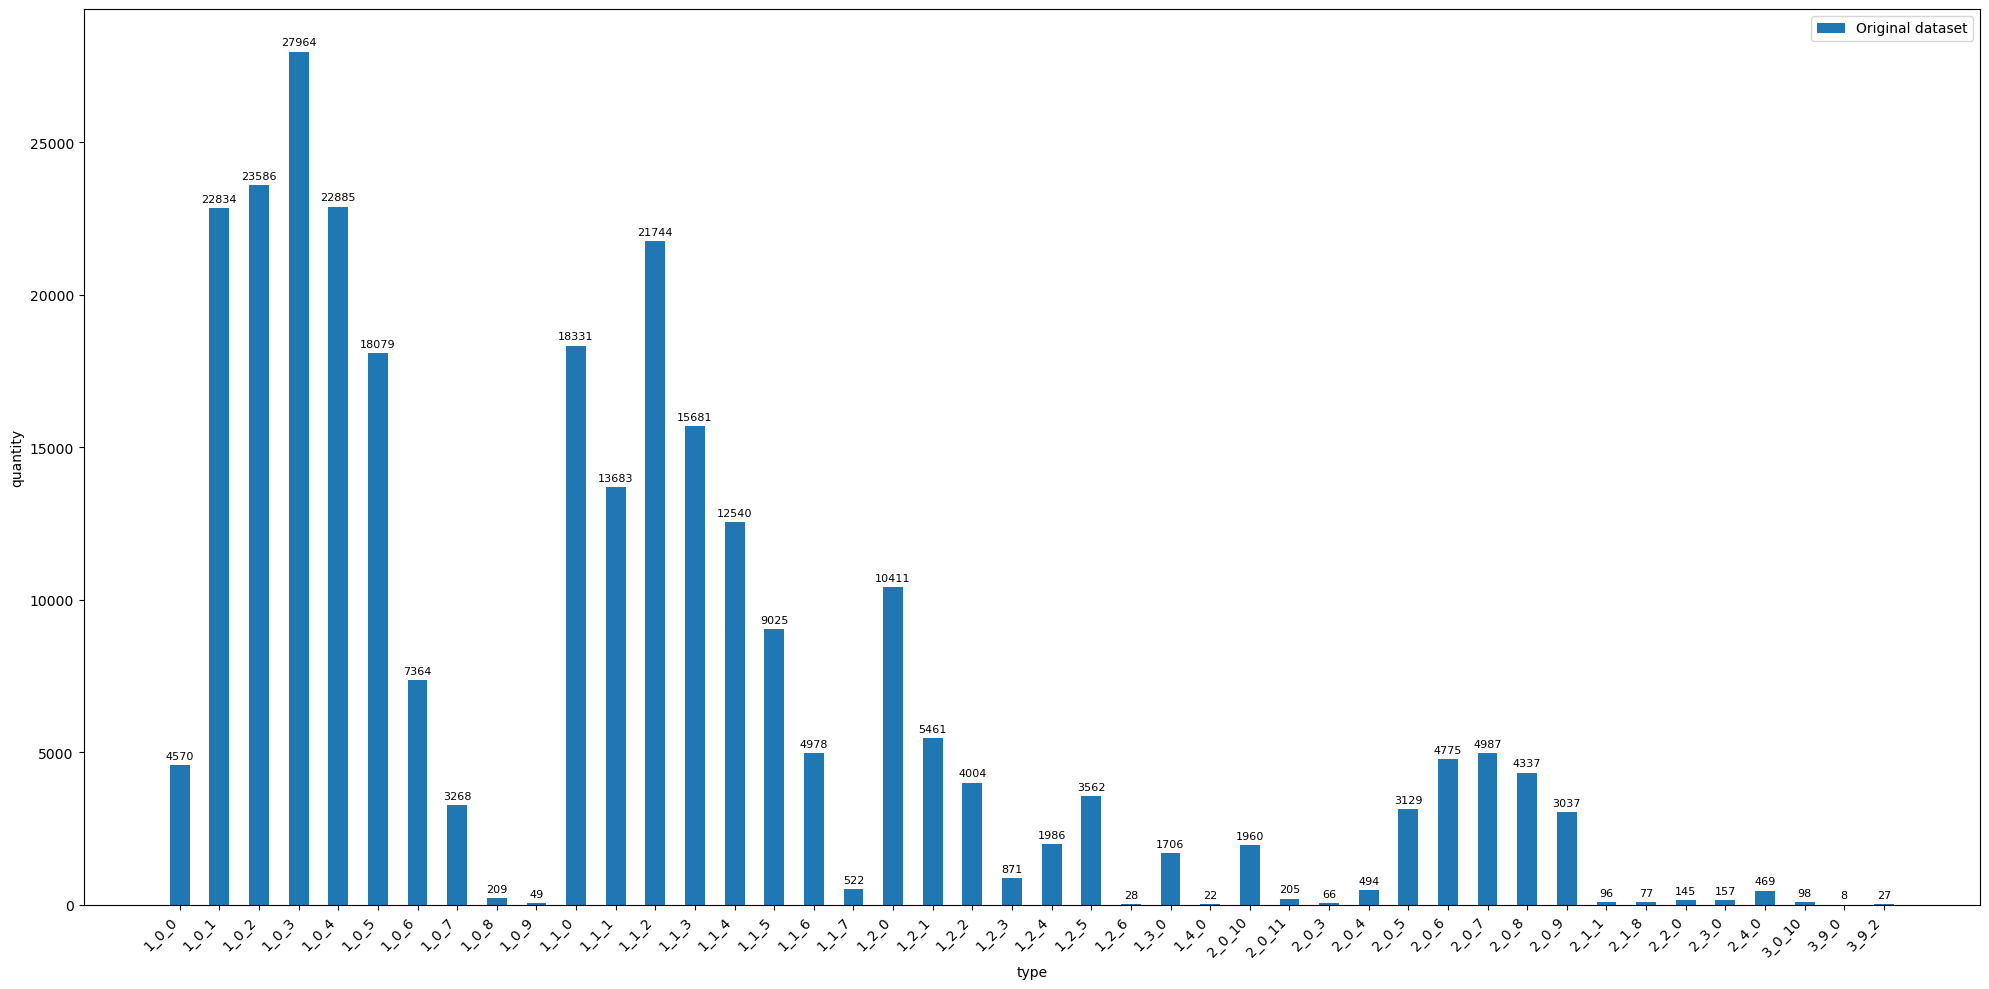

X[0] 形状: (6, 3, 1)
y 形状: (10632,)


In [58]:
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

# 假设 cy_data_encoded 和 state_encoder 已定义
# cy_data_encoded = ...
# state_encoder = ...

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length + 1): 
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
X = []
y = []

for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1,:, 0].reshape(-1, sequence_length, 1))  # 除去最后一个序列,并且只取状态
    y.append(sequence[1:, -1, 0].reshape(-1, 1))   # 除去第一个序列,并且只取状态

sequences = np.array(sequences, dtype=object)
X = np.array(X, dtype=object)
y = np.array(y, dtype=object)

# 将所有 y 数据合并为一个一维数组
y_original = np.concatenate(y).flatten()
X_original = np.concatenate(X, axis=0)

# 统计每个类别的样本数
original_class_counts = Counter(y_original)

# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))

# 转换为 NumPy 数组，按类别顺序排列
original_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    original_class_distribution[cls] = original_class_counts.get(cls, 0)

# 输出结果
print("原始数据集中每个类别的样本分布:")
for cls in total_classes:
    print(f"类别 {cls}: {original_class_distribution[cls]} 次")

# 绘制直方图
x = np.arange(len(total_classes))  # 类别索引
width = 0.5  # 直方图宽度

fig, ax = plt.subplots(figsize=(20, 10))
rects = ax.bar(x, original_class_distribution, width, label='Original dataset')

# 添加标签、标题和图例
ax.set_xlabel('type')
ax.set_ylabel('quantity')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in state_encoder.classes_], rotation=45, ha='right')  # 使用 state_encoder.classes_ 中的类别名称
ax.legend()

# 在柱状图上方显示具体数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects)

# 显示图形
plt.tight_layout()
plt.show()

# 打印 X 和 y 的形状以供调试
print("X[0] 形状:", X[0].shape)
print("y 形状:", y.shape)

统计每种X对应多少种y以及具体的比例

In [59]:
import numpy as np
from collections import defaultdict, Counter

def analyze_y_for_each_x(X, y):
    """
    统计：对给定的 X, y (长度相同)，其中 X[i] 形如 (m_i, 2, 1)，y[i] 形如 (m_i, 1)，
         收集每个子序列 x_seq 对应出现了哪些 y，并且 y 出现了多少次。

    返回：
        x2y_distribution: dict,
            key = x_seq (例如 (42, 43) 的 tuple),
            value = Counter({y_val: freq})，统计该 x_seq 对应的 y_val 及其出现次数
    """
    x2y_distribution = defaultdict(Counter)

    # 遍历所有外层数据
    for i in range(len(X)):
        xi = X[i]  # 形如 (m_i, 2, 1)
        yi = y[i]  # 形如 (m_i, 1)
        # 遍历该条数据里的所有子序列
        for j in range(xi.shape[0]):
            # x_seq 形如 (2,) 的一维数据；转为 tuple 以便做字典键
            seq_tuple = tuple(xi[j, :, 0])
            # y_val 是一个整数
            y_val = yi[j, 0]
            # 累加统计
            x2y_distribution[seq_tuple][y_val] += 1
    
    return x2y_distribution


def print_y_distribution_for_x(x2y_distribution, top_k=10):
    """
    对于 x2y_distribution (由上面函数返回)，打印：
      - 每个 x_seq 的总出现次数
      - 该 x_seq 对应的不同 y 的种类数
      - 不同 y 的出现次数及所占比例

    参数：
    - x2y_distribution: dict,
        key = x_seq, value = Counter({y_val: freq})
    - top_k: 只打印最常出现的前 top_k 个 x_seq，以防止输出过多。
             若为 None 则打印所有 x_seq。
    """
    # 将所有 x_seq 排序（例如，按总出现次数从大到小）。
    # 你也可以改成按 x_seq 的字典顺序或别的排序规则。
    x_freq_list = []
    for x_seq, counter_for_x in x2y_distribution.items():
        total_count = sum(counter_for_x.values())
        x_freq_list.append((x_seq, total_count))
    
    # 按出现总数从大到小排序
    x_freq_list.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        x_freq_list = x_freq_list[:top_k]
    
    # 依次打印
    print(f"一共有 {len(x2y_distribution)} 种不同的 X 序列。")
    for x_seq, freq_sum in x_freq_list:
        counter_for_x = x2y_distribution[x_seq]
        distinct_y_count = len(counter_for_x)
        
        print("=" * 50)
        print(f"X={x_seq}, 总出现次数 {freq_sum}, 对应 {distinct_y_count} 种不同 y")
        
        # 取得各 y 的出现次数，从大到小
        y_most_common = counter_for_x.most_common()
        
        for y_val, freq in y_most_common:
            proportion = freq / freq_sum
            print(f"  y={y_val} 出现 {freq} 次，占比 {proportion:.2%}")


# =====================
# 使用示例
# =====================
# 1) 假设你已有 X, y (长度都是 10632)
#   - X[i].shape = (m_i, 2, 1)
#   - y[i].shape = (m_i, 1)
# 2) 收集 x->y 的分布
x2y_dist = analyze_y_for_each_x(X, y)

# 3) 打印统计信息
#    top_k=10 表示只打印出现总次数最多的前10种 X 序列
#    如果你想打印全部，可以设置 top_k=None
print_y_distribution_for_x(x2y_dist, top_k=4)


一共有 6573 种不同的 X 序列。
X=(12, 1, 12), 总出现次数 5605, 对应 26 种不同 y
  y=1 出现 3853 次，占比 68.74%
  y=14 出现 556 次，占比 9.92%
  y=11 出现 232 次，占比 4.14%
  y=3 出现 223 次，占比 3.98%
  y=2 出现 186 次，占比 3.32%
  y=10 出现 153 次，占比 2.73%
  y=13 出现 132 次，占比 2.36%
  y=19 出现 67 次，占比 1.20%
  y=21 出现 32 次，占比 0.57%
  y=15 出现 30 次，占比 0.54%
  y=31 出现 26 次，占比 0.46%
  y=20 出现 21 次，占比 0.37%
  y=32 出现 19 次，占比 0.34%
  y=4 出现 18 次，占比 0.32%
  y=33 出现 12 次，占比 0.21%
  y=0 出现 8 次，占比 0.14%
  y=30 出现 8 次，占比 0.14%
  y=18 出现 8 次，占比 0.14%
  y=23 出现 6 次，占比 0.11%
  y=16 出现 5 次，占比 0.09%
  y=34 出现 3 次，占比 0.05%
  y=22 出现 2 次，占比 0.04%
  y=5 出现 2 次，占比 0.04%
  y=35 出现 1 次，占比 0.02%
  y=17 出现 1 次，占比 0.02%
  y=37 出现 1 次，占比 0.02%
X=(10, 12, 1), 总出现次数 5243, 对应 27 种不同 y
  y=3 出现 2530 次，占比 48.25%
  y=12 出现 1539 次，占比 29.35%
  y=2 出现 361 次，占比 6.89%
  y=11 出现 245 次，占比 4.67%
  y=0 出现 149 次，占比 2.84%
  y=10 出现 129 次，占比 2.46%
  y=19 出现 64 次，占比 1.22%
  y=4 出现 62 次，占比 1.18%
  y=32 出现 37 次，占比 0.71%
  y=31 出现 28 次，占比 0.53%
  y=14 出现 23 次，占比 0.44%
  y=30 出现 12 次，占

#### 删除指定的噪声类别

In [9]:
# 定义需要查询的类别索引
target_indices = [8,9,17,24,26,28,29,30,36,37,38,39,41,42,43]

# 获取 state_encoder.classes_ 的内容
classes = state_encoder.classes_
print(len(classes))
# 输出对应的物种名称
print("类别索引对应的物种名称：")
for idx in target_indices:
    if idx < len(classes):  # 确保索引在范围内
        print(f"类别 {idx}: {classes[idx]}")
    else:
        print(f"类别 {idx} 超出了范围，无法找到对应物种。")
        

# 创建布尔掩码，标记需要保留的数据
mask = np.isin(y_original, target_indices, invert=True)
# 过滤掉目标类别
filtered_y = y_original[mask]
filtered_X = X_original[mask]
# 输出过滤前后的数据量
print(f"原始数据集中 y 的样本数量: {len(y_original)}")
print(f"过滤后的数据集中 y 的样本数量: {len(filtered_y)}")

# 重构数据，使其与原始格式一致
def restore_dataset_shape(filtered_X, filtered_y, mask, X, y):
    """
    根据原来的 X、y 的形状，将“铺平”并经过过滤的 filtered_X、filtered_y
    恢复到与 X、y 对应的分块结构。
    
    参数：
    --------
    filtered_X : np.ndarray
        过滤后的 X，形状 (M, sequence_length, 1)
    filtered_y : np.ndarray
        过滤后的 y，形状 (M,)
    mask : np.ndarray (bool)
        与 X_original / y_original 同长度的布尔掩码，用于指示哪些子序列保留
    X : np.ndarray(dtype=object)
        原来的 X，X.shape==(n_rows,)，其中 X[i] 的形状是 (num_subseq_i, sequence_length, 1)
    y : np.ndarray(dtype=object)
        原来的 y，y.shape==(n_rows,)，其中 y[i] 的形状是 (num_subseq_i, 1)

    返回：
    --------
    newX : np.ndarray (dtype=object)
        恢复分块后的 X，结构同 X，但只保留了被过滤后的子序列
    newY : np.ndarray (dtype=object)
        恢复分块后的 y，结构同 y，但只保留了被过滤后的子序列
    """
    n_rows = len(X)
    # 需要把每行的结果再以 dtype=object 装起来
    newX = np.empty(n_rows, dtype=object)
    newY = np.empty(n_rows, dtype=object)
    
    # 这两个指针非常重要
    # start_idx 用于在原始mask里“找哪一段对应本行” 
    # filtered_count 用于在“过滤后数组”里“从哪开始拿数据”
    start_idx = 0
    filtered_count = 0

    for i in range(n_rows):
        # 原始第 i 行的子序列数量
        num_subseq_i = X[i].shape[0]

        # 在 mask 里，针对本行的那一段切片
        row_mask = mask[start_idx : start_idx + num_subseq_i]
        # 这一行里保留下来的子序列数
        row_true_count = np.sum(row_mask)
        
        # 从过滤后数组里拿 row_true_count 条子序列
        # 相比之前错误地对 filtered_X[start_idx : ...] 索引，这里改用 filtered_count
        row_filtered_X = filtered_X[filtered_count : filtered_count + row_true_count]
        row_filtered_y = filtered_y[filtered_count : filtered_count + row_true_count]
        # 注意 y 的原形状是 (num_subseq_i, 1)，所以要做 reshape
        row_filtered_y = row_filtered_y.reshape(-1, 1)

        # 填回 newX, newY
        newX[i] = row_filtered_X
        newY[i] = row_filtered_y

        # 更新两个指针
        start_idx += num_subseq_i
        filtered_count += row_true_count

    return newX, newY



# 已经得到 filtered_X, filtered_y, mask, 以及原来的 X, y
newX, newY = restore_dataset_shape(filtered_X, filtered_y, mask, X, y)

# 现在 newX, newY 就是带有分块结构的 np.ndarray(dtype=object),
# 其中 newX[i] 和 newY[i] 分别包含第 i 行过滤后保留下来的所有子序列。


# 输出重构后的数据形状
print("重构后的 X 形状:", newX.shape)
print("重构后的 y 形状:", newY.shape)

44
类别索引对应的物种名称：
类别 8: 1_0_8
类别 9: 1_0_9
类别 17: 1_1_7
类别 24: 1_2_6
类别 26: 1_4_0
类别 28: 2_0_11
类别 29: 2_0_3
类别 30: 2_0_4
类别 36: 2_1_1
类别 37: 2_1_8
类别 38: 2_2_0
类别 39: 2_3_0
类别 41: 3_0_10
类别 42: 3_9_0
类别 43: 3_9_2
原始数据集中 y 的样本数量: 290062
过滤后的数据集中 y 的样本数量: 287557
重构后的 X 形状: (10632,)
重构后的 y 形状: (10632,)


#### 对newX和newY进行类别重新映射

In [10]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def fast_decode_and_reencode(newX, newY, old_state_encoder):
    """
    一次性对 newX、newY 进行解码，创建新的 encoder，并把它们重新编码回来。

    参数
    -------
    newX : np.ndarray(dtype=object)
        过滤后的 X，形状 (n_rows,)
        每个 newX[i] 形如 (num_subseq_i, sequence_length, 1)
    newY : np.ndarray(dtype=object)
        过滤后的 Y，形状 (n_rows,)
        每个 newY[i] 形如 (num_subseq_i, 1)
    old_state_encoder : LabelEncoder
        原先训练好的 state_encoder，用于 inverse_transform()

    返回
    -------
    newX_reencoded : 与 newX 相同 shape，但内容是「新的整数索引」
    newY_reencoded : 与 newY 相同 shape
    filtered_state_encoder : 新的 LabelEncoder，仅包含在过滤后数据中实际出现的 (Mo, O, S) 组合
    """

    # -------------------------
    # (1) 将 newX、newY 扁平化(flatten)到一维
    # -------------------------
    flattened_x = []
    for i in range(len(newX)):
        # newX[i] 的形状 (num_subseq_i, seq_len, 1)，可能有空行
        if newX[i].size > 0:
            flattened_x.append(newX[i].flatten())  # 一维
        else:
            # 空行则 append 空列表即可
            flattened_x.append([])

    # 将所有行拼接为一个一维数组
    flattened_x = (
        np.concatenate(flattened_x, axis=0) if flattened_x else np.array([], dtype=int)
    )

    flattened_y = []
    for i in range(len(newY)):
        # newY[i] 的形状 (num_subseq_i, 1)
        if newY[i].size > 0:
            flattened_y.append(newY[i].flatten())
        else:
            flattened_y.append([])

    flattened_y = (
        np.concatenate(flattened_y, axis=0) if flattened_y else np.array([], dtype=int)
    )

    # all_labels 即所有出现过的整数状态，先拼到一起
    all_labels = np.concatenate([flattened_x, flattened_y], axis=0).astype(int)

    # -------------------------
    # (2) 一次性使用 old_state_encoder 解码
    # -------------------------
    # 得到诸如 ['3_9_0', '2_8_1', ...] 的字符串数组
    str_labels = old_state_encoder.inverse_transform(all_labels)
    # 将 '3_9_0' => (3, 9, 0) tuple
    splitted = [tuple(map(int, s.split('_'))) for s in str_labels]

    # -------------------------
    # (3) 创建新的编码器：只包含过滤后实际出现过的类别
    # -------------------------
    # 去重，以 tuple(Mo,O,S) 形式保留
    unique_tuples = sorted(set(splitted))  
    # 再转为字符串以 fit 到 LabelEncoder
    tuple_strings = [f"{t[0]}_{t[1]}_{t[2]}" for t in unique_tuples]

    filtered_state_encoder = LabelEncoder()
    filtered_state_encoder.fit(tuple_strings)

    # -------------------------
    # (4) 构建「(Mo,O,S)->新索引」的字典，并将所有 splitted 批量转换
    # -------------------------
    splitted_to_new = {}
    for t in unique_tuples:
        t_str = f"{t[0]}_{t[1]}_{t[2]}"
        new_label = filtered_state_encoder.transform([t_str])[0]
        splitted_to_new[t] = new_label

    # 将 splitted 中每个元素 (Mo,O,S) 转为新的整数索引
    reencoded_all = np.array([splitted_to_new[t] for t in splitted], dtype=int)

    # 由于前面 merged x,y (flattened)，现需拆分还原
    x_size = flattened_x.shape[0]
    y_size = flattened_y.shape[0]
    reencoded_x = reencoded_all[:x_size]
    reencoded_y = reencoded_all[x_size:]

    # -------------------------
    # (5) 还原回与 newX、newY 相同形状
    # -------------------------
    newX_reencoded = np.empty_like(newX)
    idx = 0
    for i in range(len(newX)):
        shape_i = newX[i].shape  # (num_subseq_i, seq_len, 1)
        size_i = shape_i[0] * shape_i[1] * shape_i[2] if shape_i[0] > 0 else 0
        newX_reencoded[i] = reencoded_x[idx : idx + size_i].reshape(shape_i)
        idx += size_i

    newY_reencoded = np.empty_like(newY)
    idx = 0
    for i in range(len(newY)):
        shape_i = newY[i].shape  # (num_subseq_i, 1)
        size_i = shape_i[0] * shape_i[1] if shape_i[0] > 0 else 0
        newY_reencoded[i] = reencoded_y[idx : idx + size_i].reshape(shape_i)
        idx += size_i

    return newX_reencoded, newY_reencoded, filtered_state_encoder


# =======================
# 使用示例
# =======================

# 假设已经得到:
#   newX, newY    (过滤后，和原 X, Y 同结构)
#   state_encoder (旧的 LabelEncoder)
# 现在执行:
newX_reencoded, newY_reencoded, filtered_state_encoder = fast_decode_and_reencode(newX, newY, state_encoder)



#### 将删除噪声后的数据分为训练集和测试集

(7442,) (3190,)
(7442,) (3190,)
(195864, 3, 1) (83566, 3, 1)
(195864, 1) (83566, 1)
训练集中包含的类别数量: 44
测试集中包含的类别数量: 44
总类别数量: 44
训练集中没有缺失任何类别。
测试集中没有缺失任何类别。
类别索引对应的物种名称：
类别 8: 1_0_8
类别 9: 1_0_9
类别 17: 1_1_7
类别 24: 1_2_6
类别 26: 1_4_0
类别 28: 2_0_11
类别 29: 2_0_3
类别 30: 2_0_4
类别 36: 2_1_1
类别 37: 2_1_8
类别 38: 2_2_0
类别 39: 2_3_0
类别 41: 3_0_10
类别 42: 3_9_0
类别 43: 3_9_2


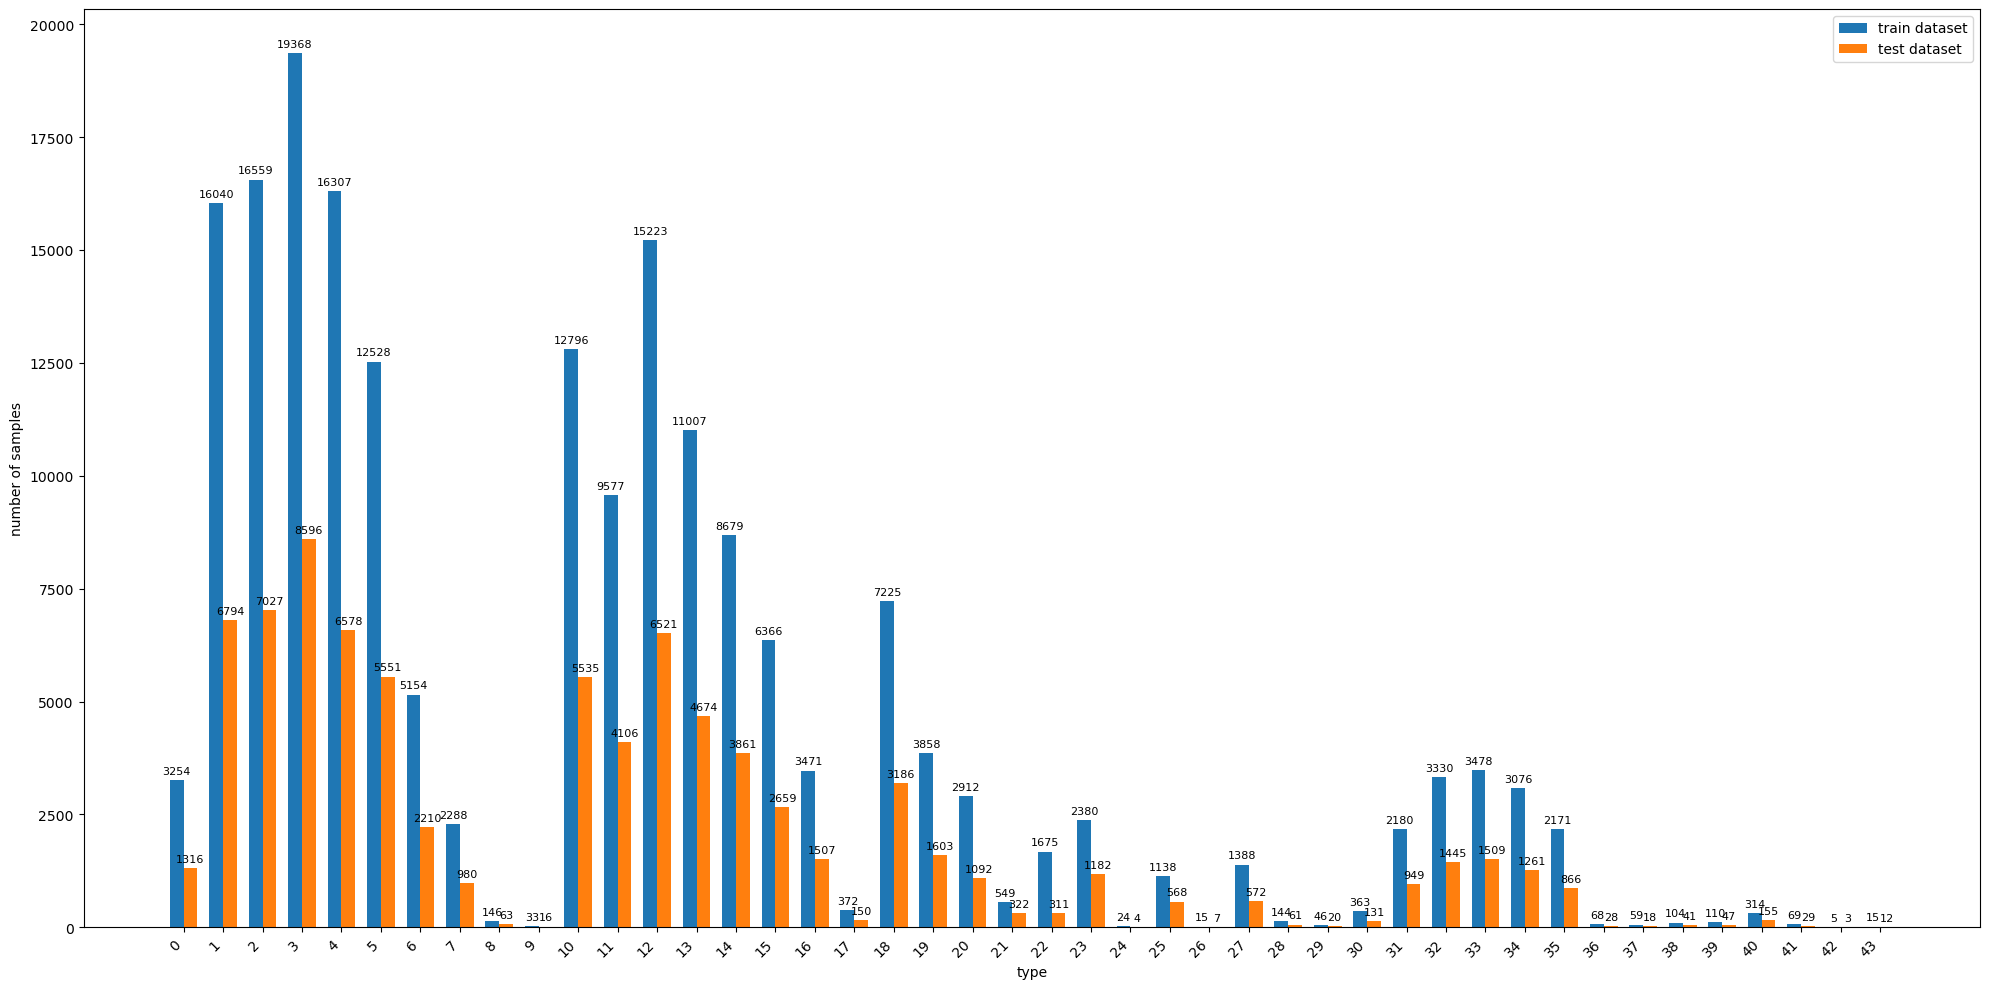

In [55]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


# 获取训练集和测试集中的唯一类别
unique_train_classes = np.unique(y_train)
unique_test_classes = np.unique(y_test)

# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))

# 统计训练集和测试集中的类别数量
num_train_classes = len(unique_train_classes)
num_test_classes = len(unique_test_classes)


# 检查训练集中是否缺少某些类别
missing_classes_in_train = set(total_classes) - set(unique_train_classes)
# 检查测试集中是否缺少某些类别
missing_classes_in_test = set(total_classes) - set(unique_test_classes)



# 输出结果
print(f"训练集中包含的类别数量: {num_train_classes}")
print(f"测试集中包含的类别数量: {num_test_classes}")
print(f"总类别数量: {len(total_classes)}")

if missing_classes_in_train:
    print(f"训练集中缺失的类别: {missing_classes_in_train}")
else:
    print("训练集中没有缺失任何类别。")


if missing_classes_in_test:
    print(f"测试集中缺失的类别: {missing_classes_in_test}")
else:
    print("测试集中没有缺失任何类别。")
    
    
# 获取 state_encoder.classes_ 的内容
classes = state_encoder.classes_

# 定义需要查询的类别索引
target_indices = [8,9,17,24,26,28,29,30,36,37,38,39,41,42,43]

# 输出对应的物种名称
print("类别索引对应的物种名称：")
for idx in target_indices:
    if idx < len(classes):  # 确保索引在范围内
        print(f"类别 {idx}: {classes[idx]}")
    else:
        print(f"类别 {idx} 超出了范围，无法找到对应物种。")
        
        
# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))

# 统计训练集和测试集中每个类别的样本出现次数
train_class_counts = Counter(y_train.flatten())  # 统计训练集中每个类别的出现次数
test_class_counts = Counter(y_test.flatten())    # 统计测试集中每个类别的出现次数

# 转换为 NumPy 数组，按类别顺序排列
train_class_distribution = np.zeros(len(total_classes), dtype=int)
test_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    train_class_distribution[cls] = train_class_counts.get(cls, 0)
    test_class_distribution[cls] = test_class_counts.get(cls, 0)
    
# # 输出结果
# print("训练集中每个类别的样本分布:")
# for cls in total_classes:
#     print(f"类别 {cls}: {train_class_distribution[cls]} 次")

# print("\n测试集中每个类别的样本分布:")
# for cls in total_classes:
#     print(f"类别 {cls}: {test_class_distribution[cls]} 次")    
    
# 绘制直方图
x = np.arange(len(total_classes))  # 类别索引
width = 0.35  # 直方图宽度

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, train_class_distribution, width, label='train dataset')
rects2 = ax.bar(x + width/2, test_class_distribution, width, label='test dataset')

# 添加标签、标题和图例
ax.set_xlabel('type')
ax.set_ylabel('number of samples')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in total_classes], rotation=45, ha='right')
ax.legend()

# 在柱状图上方显示具体数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=8)

autolabel(rects1)
autolabel(rects2)

# 显示图形
plt.tight_layout()
plt.show()

#### 1.3未删除噪声分子的原始代码（备用）

(7442,) (3190,)
(7442,) (3190,)
(203306, 2, 1) (86756, 2, 1)
(203306, 1) (86756, 1)
训练集中包含的类别数量: 44
测试集中包含的类别数量: 44
总类别数量: 44
训练集中没有缺失任何类别。
测试集中没有缺失任何类别。
类别索引对应的物种名称：
类别 8: 1_0_8
类别 9: 1_0_9
类别 17: 1_1_7
类别 24: 1_2_6
类别 26: 1_4_0
类别 28: 2_0_11
类别 29: 2_0_3
类别 30: 2_0_4
类别 36: 2_1_1
类别 37: 2_1_8
类别 38: 2_2_0
类别 39: 2_3_0
类别 41: 3_0_10
类别 42: 3_9_0
类别 43: 3_9_2


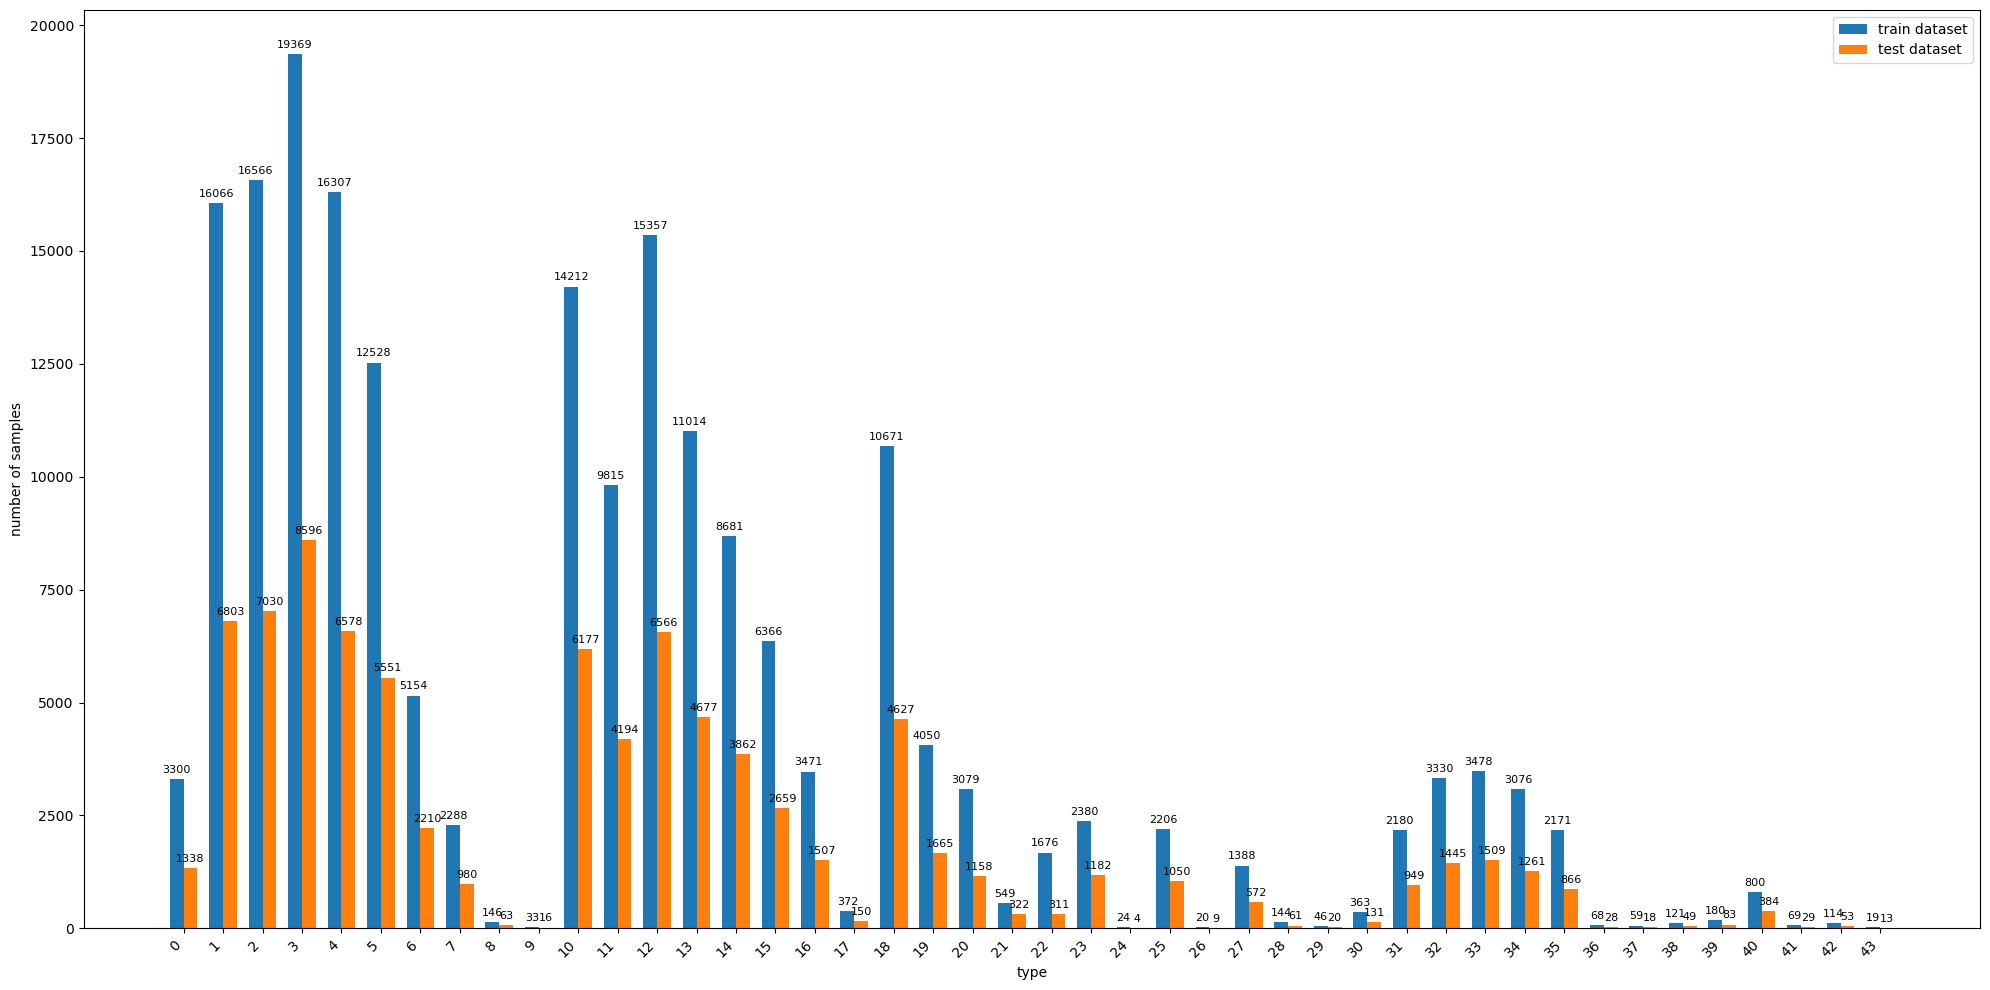

In [30]:
import numpy as np
from tqdm import tqdm
from collections import Counter
# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length +1): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 2

sequences = []
X = []
y = []
for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1,:, 0].reshape(-1,sequence_length,1))  # 除去最后一个序列,并且只取状态
    y.append(sequence[1:, -1,0].reshape(-1,1))   # 除去第一个序列,并且只取状态

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)

# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)




# 获取训练集和测试集中的唯一类别
unique_train_classes = np.unique(y_train)
unique_test_classes = np.unique(y_test)

# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))

# 统计训练集和测试集中的类别数量
num_train_classes = len(unique_train_classes)
num_test_classes = len(unique_test_classes)


# 检查训练集中是否缺少某些类别
missing_classes_in_train = set(total_classes) - set(unique_train_classes)
# 检查测试集中是否缺少某些类别
missing_classes_in_test = set(total_classes) - set(unique_test_classes)



# 输出结果
print(f"训练集中包含的类别数量: {num_train_classes}")
print(f"测试集中包含的类别数量: {num_test_classes}")
print(f"总类别数量: {len(total_classes)}")

if missing_classes_in_train:
    print(f"训练集中缺失的类别: {missing_classes_in_train}")
else:
    print("训练集中没有缺失任何类别。")


if missing_classes_in_test:
    print(f"测试集中缺失的类别: {missing_classes_in_test}")
else:
    print("测试集中没有缺失任何类别。")
    
    
# 获取 state_encoder.classes_ 的内容
classes = state_encoder.classes_

# 定义需要查询的类别索引
target_indices = [8,9,17,24,26,28,29,30,36,37,38,39,41,42,43]

# 输出对应的物种名称
print("类别索引对应的物种名称：")
for idx in target_indices:
    if idx < len(classes):  # 确保索引在范围内
        print(f"类别 {idx}: {classes[idx]}")
    else:
        print(f"类别 {idx} 超出了范围，无法找到对应物种。")
        
        
# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))

# 统计训练集和测试集中每个类别的样本出现次数
train_class_counts = Counter(y_train.flatten())  # 统计训练集中每个类别的出现次数
test_class_counts = Counter(y_test.flatten())    # 统计测试集中每个类别的出现次数

# 转换为 NumPy 数组，按类别顺序排列
train_class_distribution = np.zeros(len(total_classes), dtype=int)
test_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    train_class_distribution[cls] = train_class_counts.get(cls, 0)
    test_class_distribution[cls] = test_class_counts.get(cls, 0)
    
# # 输出结果
# print("训练集中每个类别的样本分布:")
# for cls in total_classes:
#     print(f"类别 {cls}: {train_class_distribution[cls]} 次")

# print("\n测试集中每个类别的样本分布:")
# for cls in total_classes:
#     print(f"类别 {cls}: {test_class_distribution[cls]} 次")    
    
# 绘制直方图
x = np.arange(len(total_classes))  # 类别索引
width = 0.35  # 直方图宽度

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, train_class_distribution, width, label='train dataset')
rects2 = ax.bar(x + width/2, test_class_distribution, width, label='test dataset')

# 添加标签、标题和图例
ax.set_xlabel('type')
ax.set_ylabel('number of samples')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in total_classes], rotation=45, ha='right')
ax.legend()

# 在柱状图上方显示具体数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=8)

autolabel(rects1)
autolabel(rects2)

# 显示图形
plt.tight_layout()
plt.show()

In [7]:
print("所有物种类型的数量：",len(state_encoder.classes_))
#state_encoder.classes_

# 获取 state_encoder.classes_ 的内容
classes = state_encoder.classes_

# 输出每个物种的编号及其对应的名称
print("物种编号及对应的物种名称：")
for idx, class_name in enumerate(classes):
    print(f"类别 {idx}: {class_name}")

所有物种类型的数量： 39
物种编号及对应的物种名称：
类别 0: 1_0_0
类别 1: 1_0_1
类别 2: 1_0_2
类别 3: 1_0_3
类别 4: 1_0_4
类别 5: 1_0_5
类别 6: 1_0_6
类别 7: 1_0_7
类别 8: 1_0_8
类别 9: 1_0_9
类别 10: 1_1_0
类别 11: 1_1_1
类别 12: 1_1_2
类别 13: 1_1_3
类别 14: 1_1_4
类别 15: 1_1_5
类别 16: 1_1_6
类别 17: 1_1_7
类别 18: 1_2_0
类别 19: 1_2_1
类别 20: 1_2_2
类别 21: 1_2_3
类别 22: 1_2_4
类别 23: 1_2_5
类别 24: 1_2_6
类别 25: 1_3_0
类别 26: 2_0_10
类别 27: 2_0_4
类别 28: 2_0_5
类别 29: 2_0_6
类别 30: 2_0_7
类别 31: 2_0_8
类别 32: 2_0_9
类别 33: 2_1_1
类别 34: 2_2_0
类别 35: 2_3_0
类别 36: 2_4_0
类别 37: 3_9_0
类别 38: 3_9_2


### 1.4单输出回归任务:X4维（物种+时间），y3维（物种）

设计X和y

In [10]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length+1): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1][:,:-1])  # 没有问题，因为连续的sequence之间中间段本来就相同

sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y = np.array(y,dtype=object)
print('sequences')
print(sequences[1].shape,sequences[1])
print('shape of X')
print(X[1].shape,X[1])
print('shape of y')
print(y[2].shape,y[2])

sequences
(3, 3, 4) [[[  3   9   0  55]
  [  1   2   0 128]
  [  1   1   2  75]]

 [[  1   2   0 128]
  [  1   1   2  75]
  [  1   0   4 366]]

 [[  1   1   2  75]
  [  1   0   4 366]
  [  1   0   6 196]]]
shape of X
(2, 3, 4) [[[  3   9   0  55]
  [  1   2   0 128]
  [  1   1   2  75]]

 [[  1   2   0 128]
  [  1   1   2  75]
  [  1   0   4 366]]]
shape of y
(12, 3) [[1 2 2]
 [1 1 3]
 [1 0 2]
 [1 0 1]
 [1 1 0]
 [1 0 1]
 [1 0 3]
 [1 0 5]
 [1 0 4]
 [1 1 5]
 [1 0 4]
 [1 0 6]]


统计划分X,y后的样本数量分布

总共有物种种类： 43
各物种类型及其数量：
(1, 0, 3) 18420
(1, 1, 4) 6023
(1, 0, 5) 12194
(1, 0, 7) 3066
(1, 0, 4) 15390
(1, 0, 6) 7564
(1, 2, 2) 1051
(1, 1, 3) 7794
(1, 0, 2) 13947
(1, 0, 1) 12090
(1, 1, 0) 6567
(1, 1, 5) 4304
(1, 1, 1) 6998
(1, 1, 2) 9936
(1, 0, 0) 1959
(1, 2, 0) 1964
(2, 0, 8) 4031
(2, 0, 9) 2775
(1, 1, 6) 1963
(2, 0, 6) 4130
(2, 0, 10) 1770
(1, 2, 1) 1703
(2, 0, 7) 4570
(1, 2, 5) 970
(1, 1, 7) 355
(1, 3, 0) 177
(2, 2, 0) 51
(1, 0, 8) 65
(2, 0, 5) 2668
(1, 2, 4) 679
(2, 3, 0) 15
(3, 9, 0) 2
(1, 0, 9) 11
(2, 0, 4) 380
(2, 1, 1) 34
(1, 2, 6) 20
(2, 4, 0) 22
(1, 2, 3) 255
(2, 0, 3) 46
(2, 0, 11) 196
(1, 4, 0) 2
(3, 0, 10) 89
(2, 1, 8) 63


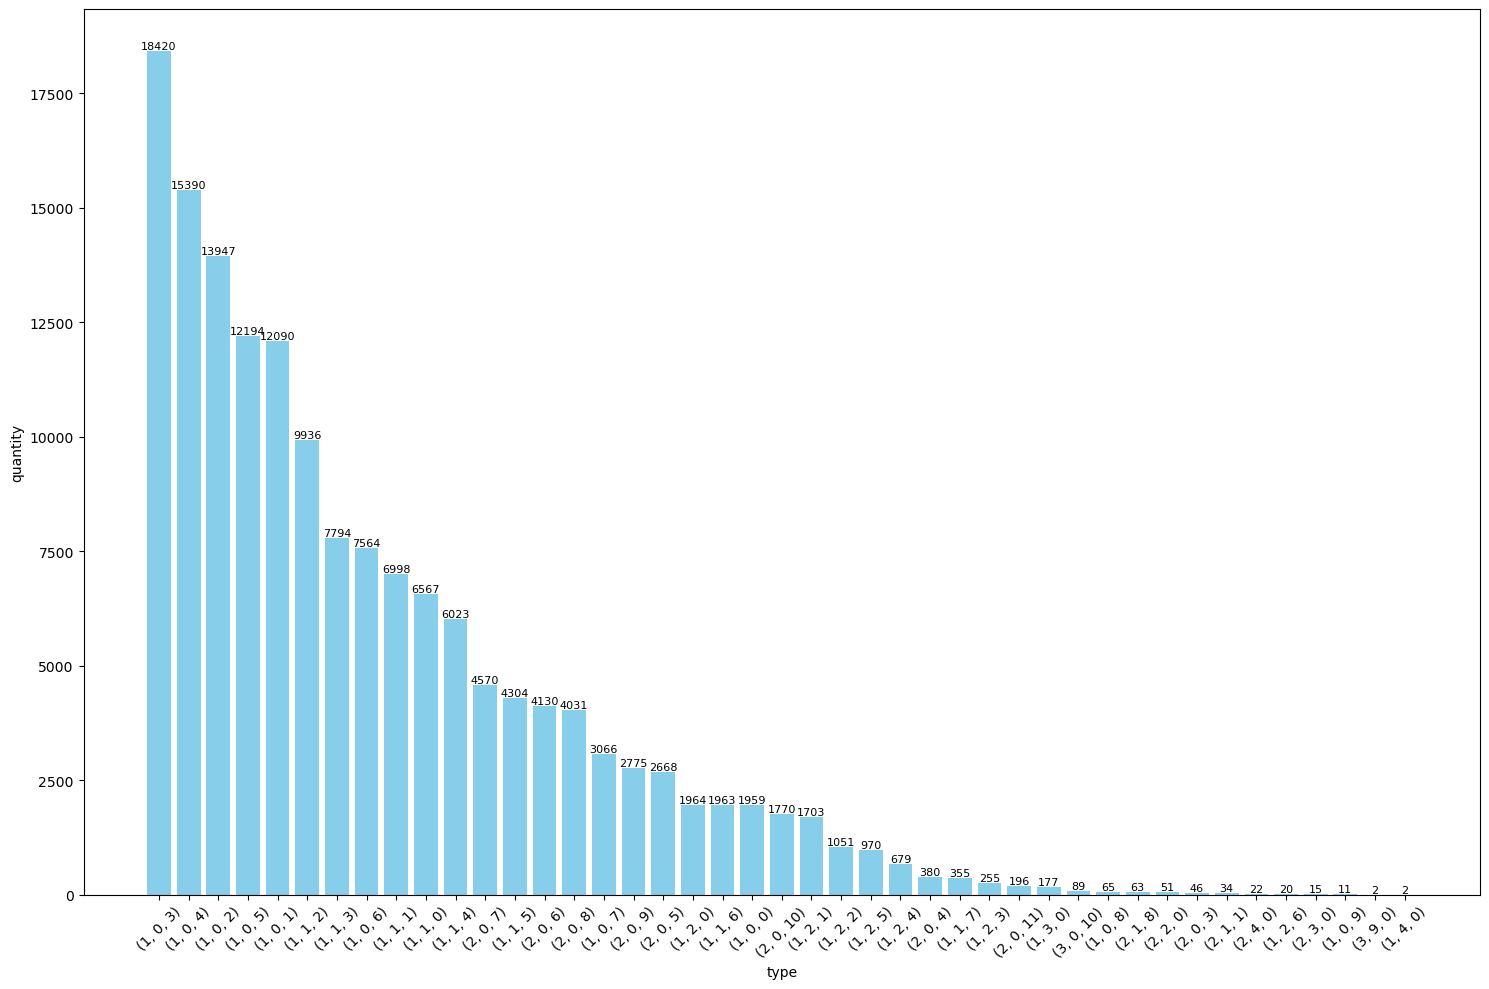

In [11]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 假设 y 是 dtype=object，每个元素为一个 numpy 数组，形状可能为 (n, 3)
# 例如：
# y = np.array([
#         np.array([[1, 1, 2],
#                   [1, 0, 4]]),
#         np.array([[1, 1, 2],
#                   [1, 0, 6],
#                   [1, 0, 4]])
#     ], dtype=object)

# 遍历 y 中的每个数组，将每个基本物种转换为 tuple 后收集到列表中
species_list = []
for arr in y:
    for sp in arr:
        species_list.append(tuple(sp))  # 转为 tuple 便于计数

# 使用 Counter 统计每种物种出现的次数
species_counter = Counter(species_list)
print("总共有物种种类：", len(species_counter))
print("各物种类型及其数量：")
for species, count in species_counter.items():
    print(species, count)

# 对计数结果进行降序排序
sorted_species = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)
labels = [str(item[0]) for item in sorted_species]
counts = [item[1] for item in sorted_species]

# 绘制条形图
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, counts, color='skyblue')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# 在每个条形图上标出数量
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()


划分训练集和测试集

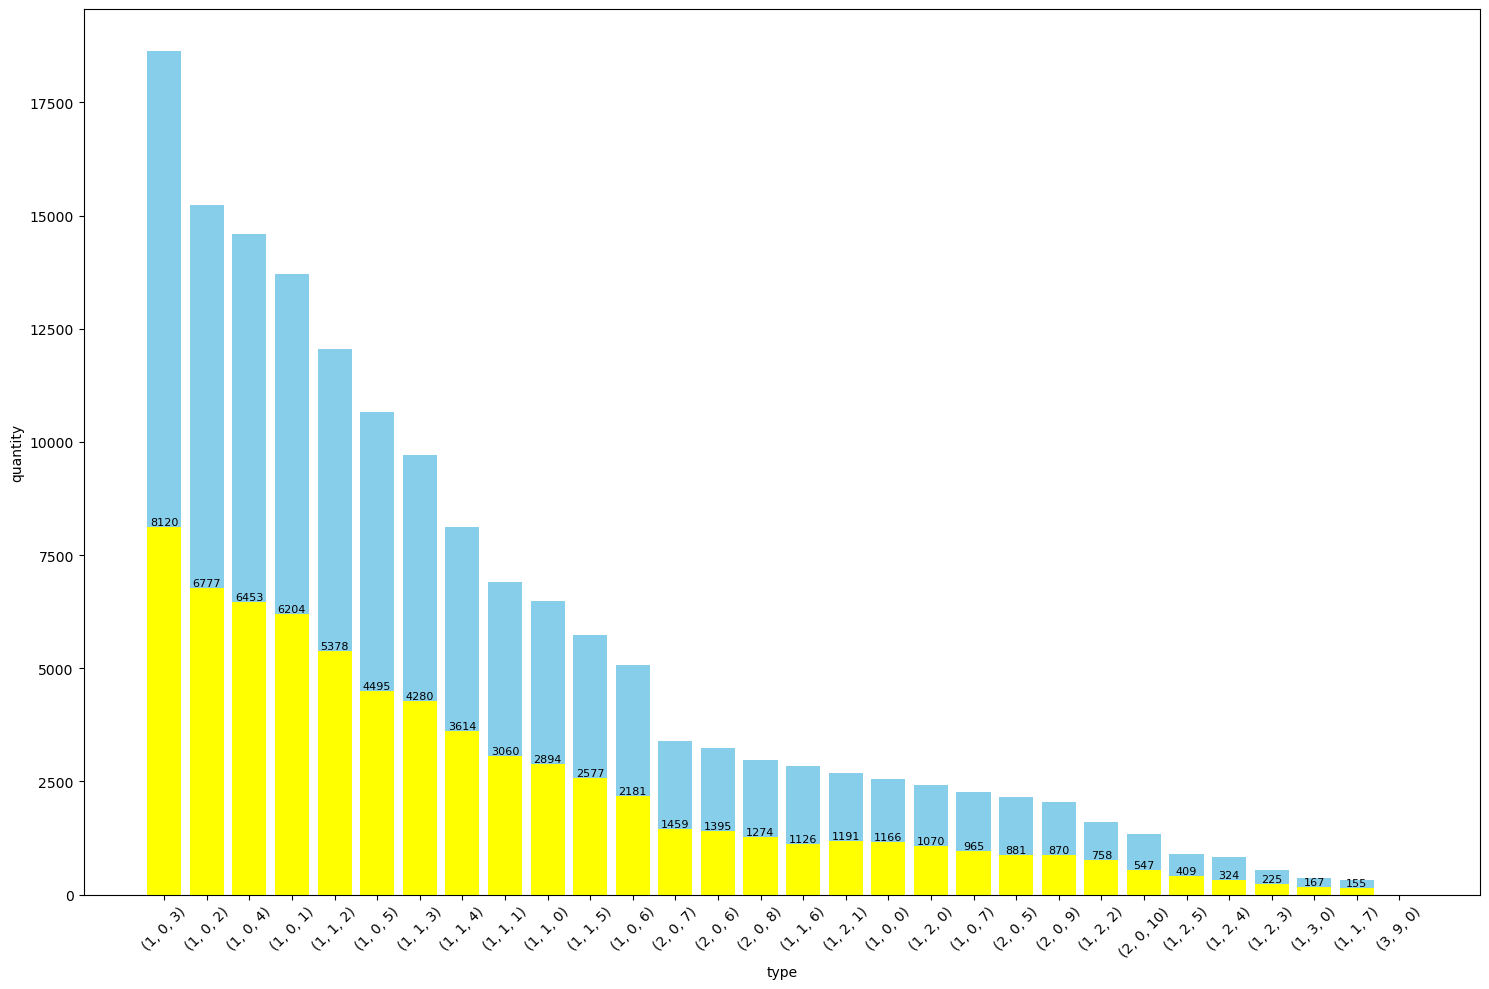

(159379, 6, 4)
(70015, 6, 4)
(159379, 3)
(70015, 3)


In [14]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 遍历 y 中的每个数组，将每个基本物种转换为 tuple 后收集到列表中
species_list_train = []
for arr in y_train:
    for sp in arr:
        species_list_train.append(tuple(sp))  # 转为 tuple 便于计数
        
species_list_test = []
for arr in y_test:
    for sp in arr:
        species_list_test.append(tuple(sp))  # 转为 tuple 便于计数

# 使用 Counter 统计每种物种出现的次数
species_counter_train = Counter(species_list_train)
species_counter_test = Counter(species_list_test)

# 对计数结果进行降序排序
sorted_species_train = sorted(species_counter_train.items(), key=lambda x: x[1], reverse=True)
labels_train = [str(item[0]) for item in sorted_species_train]
counts_train = [item[1] for item in sorted_species_train]

sorted_species_test = sorted(species_counter_test.items(), key=lambda x: x[1], reverse=True)
labels_test = [str(item[0]) for item in sorted_species_test]
counts_test = [item[1] for item in sorted_species_test]

# 绘制条形图
plt.figure(figsize=(15, 10))
bars = plt.bar(labels_train, counts_train, color='skyblue')
bars = plt.bar(labels_test, counts_test, color='yellow')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# 在每个条形图上标出数量
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()



X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)

### 1.5（预测产物类型：MoS6还是MoS7）

设计X和y

In [51]:
# import numpy as np
from tqdm import tqdm

# 参数
sequence_length = 9

#============================倒序统计的代码=======================================
X = []
y = []
for row in cy_data:
    X.append(row[len(row)-sequence_length-1:-1])
    y.append(row[-1][:-1])

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)



#==========================正序统计的代码==========================================






# 只保留 X 中每个向量的前三个维度(可选)
# X = X[:, :, :3]

# X = np.array(X,dtype=object)
# y = np.array(y,dtype=object)    
print('shape of X',X.shape)

print(X[7])
print('shape of y',y.shape)
print(y[7])


shape of X (13531, 9, 4)
[[  1.   2.   2.   5.]
 [  1.   1.   1.  54.]
 [  1.   1.   3.  20.]
 [  1.   0.   2. 421.]
 [  1.   0.   4.  21.]
 [  1.   0.   2. 148.]
 [  1.   1.   3.  58.]
 [  1.   1.   5.   1.]
 [  1.   0.   4.  92.]]
shape of y (13531, 3)
[1. 0. 6.]


统计样本数量

总共有物种种类： 2
各物种类型及其数量：
(1.0, 0.0, 6.0) 9316
(1.0, 0.0, 7.0) 4215


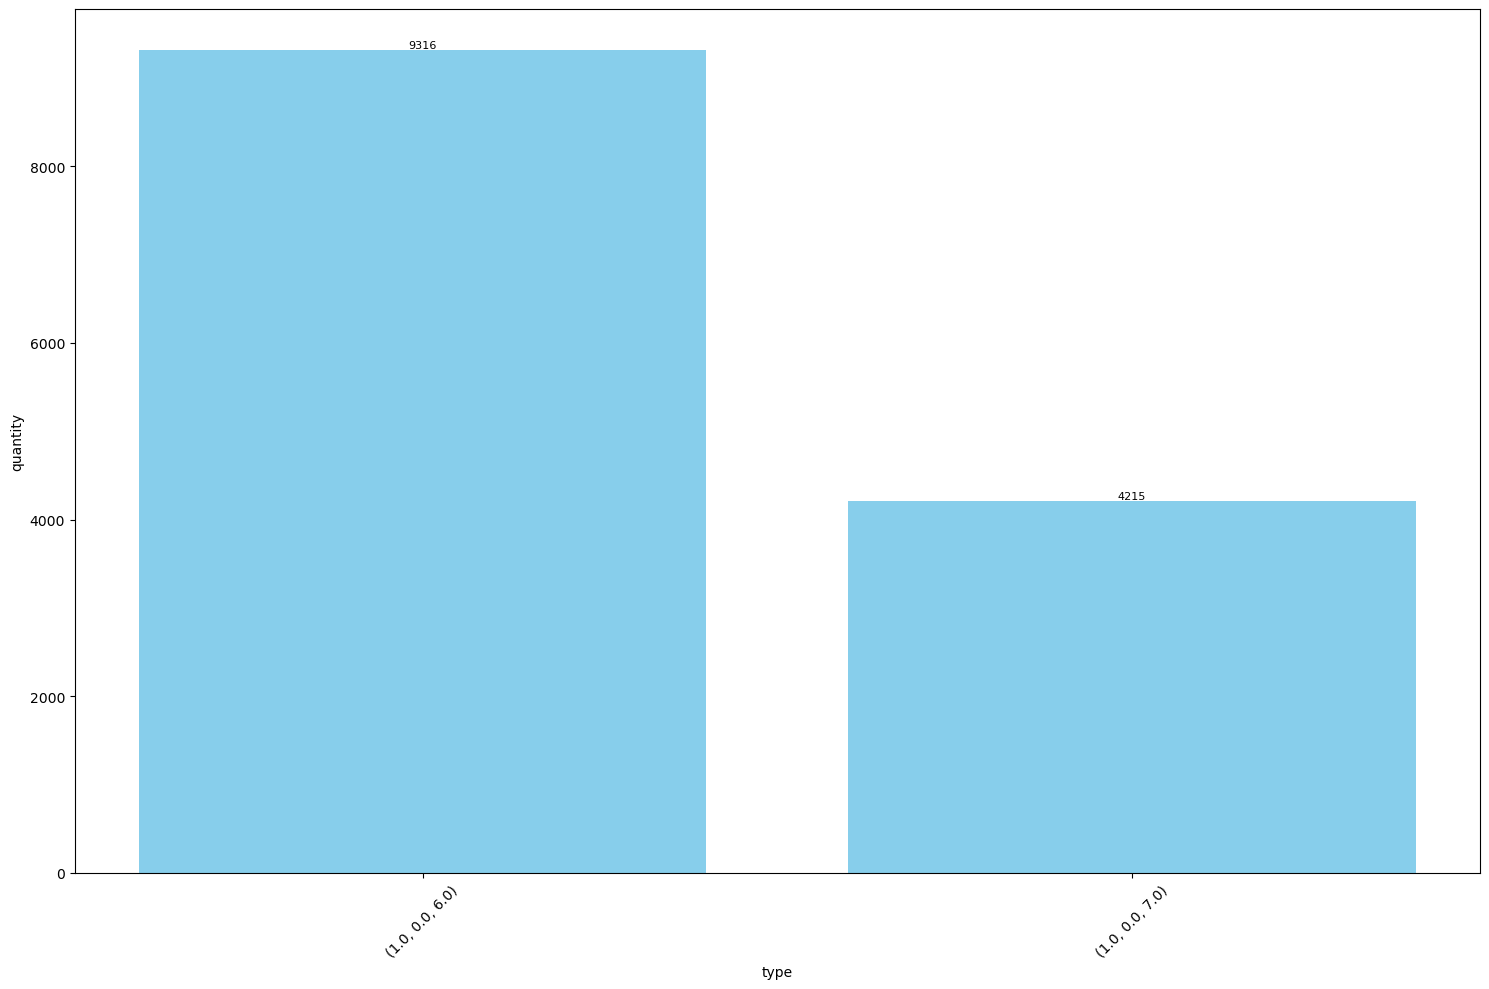

In [52]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 假设 y 是 dtype=object，每个元素为一个 numpy 数组，形状可能为 (n, 3)
# 例如：
# y = np.array([
#         np.array([[1, 1, 2],
#                   [1, 0, 4]]),
#         np.array([[1, 1, 2],
#                   [1, 0, 6],
#                   [1, 0, 4]])
#     ], dtype=object)

# 遍历 y 中的每个数组，将每个基本物种转换为 tuple 后收集到列表中
species_list = []
for arr in y:
    species_list.append(tuple(arr))  # 转为 tuple 便于计数

# 使用 Counter 统计每种物种出现的次数
species_counter = Counter(species_list)
print("总共有物种种类：", len(species_counter))
print("各物种类型及其数量：")
for species, count in species_counter.items():
    print(species, count)

# 对计数结果进行降序排序
sorted_species = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)
labels = [str(item[0]) for item in sorted_species]
counts = [item[1] for item in sorted_species]

# 绘制条形图
plt.figure(figsize=(15, 10))
bars = plt.bar(labels, counts, color='skyblue')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# 在每个条形图上标出数量
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()


平衡样本数量

In [53]:
import numpy as np
from collections import defaultdict

# 统计每个物种对应的样本索引（将每个 y 转换为 tuple 作为键）
species_to_indices = defaultdict(list)
for idx, arr in enumerate(y):
    species = tuple(arr)
    species_to_indices[species].append(idx)

# 设定目标样本数量
desired_count = 4215

balanced_indices = []
for species, indices in species_to_indices.items():
    if len(indices) > desired_count:
        # 数量多于目标时，随机抽样 desired_count 个索引
        sampled_indices = np.random.choice(indices, desired_count, replace=False)
    else:
        # 数量不足时，全部保留
        sampled_indices = indices
    balanced_indices.extend(sampled_indices)

# 转换为 numpy 数组，并随机打乱索引顺序
balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

# 利用抽样后的索引构造新的 X 和 y
X_balanced = X[balanced_indices]
y_balanced = y[balanced_indices]

print("平衡后的 X shape:", X_balanced.shape)
print("平衡后的 y shape:", y_balanced.shape)


平衡后的 X shape: (8430, 9, 4)
平衡后的 y shape: (8430, 3)


划分训练集和测试集

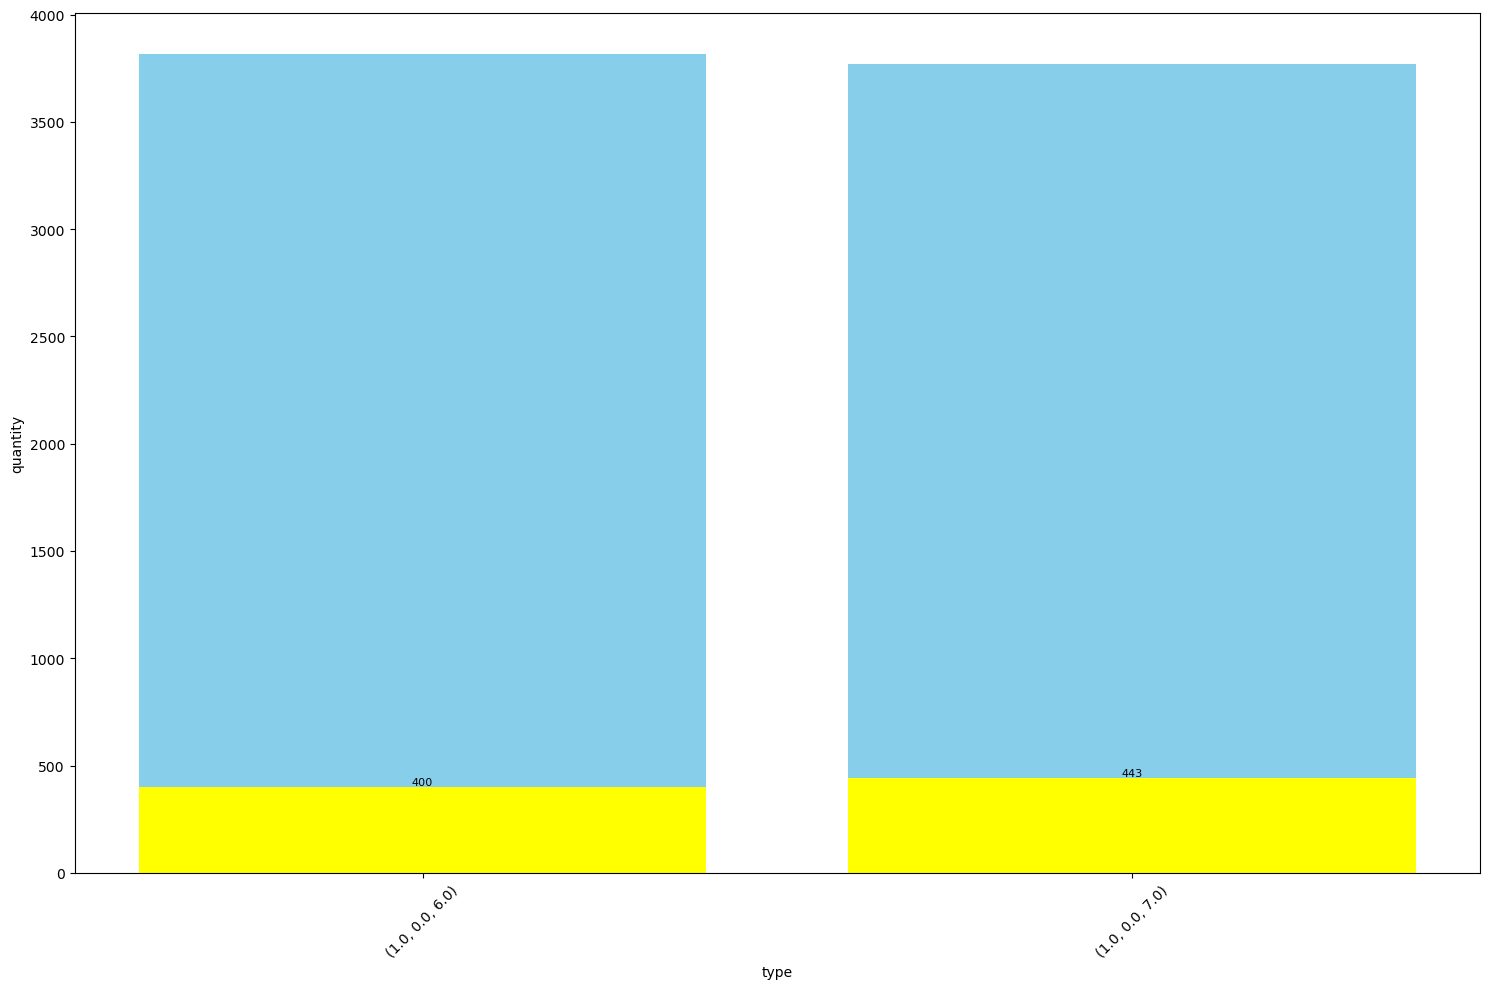

(7587, 9, 4)
(843, 9, 4)
(7587, 3)
(843, 3)


In [54]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.1, random_state=42)

# 遍历 y 中的每个数组，将每个基本物种转换为 tuple 后收集到列表中
species_list_train = []
for arr in y_train:
    species_list_train.append(tuple(arr))  # 转为 tuple 便于计数
        
species_list_test = []
for arr in y_test:
    species_list_test.append(tuple(arr))  # 转为 tuple 便于计数

# 使用 Counter 统计每种物种出现的次数
species_counter_train = Counter(species_list_train)
species_counter_test = Counter(species_list_test)

# 对计数结果进行降序排序
sorted_species_train = sorted(species_counter_train.items(), key=lambda x: x[1], reverse=True)
labels_train = [str(item[0]) for item in sorted_species_train]
counts_train = [item[1] for item in sorted_species_train]

sorted_species_test = sorted(species_counter_test.items(), key=lambda x: x[1], reverse=True)
labels_test = [str(item[0]) for item in sorted_species_test]
counts_test = [item[1] for item in sorted_species_test]

# 绘制条形图
plt.figure(figsize=(15, 10))
bars = plt.bar(labels_train, counts_train, color='skyblue')
bars = plt.bar(labels_test, counts_test, color='yellow')
plt.xlabel("type")
plt.ylabel("quantity")
plt.xticks(rotation=45)

# 在每个条形图上标出数量
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom',fontsize = 8)

plt.tight_layout()
plt.show()



print(X_train.shape)
print(X_test.shape)


print(y_train.shape)
print(y_test.shape)

### 2.针对多输出(分类+回归)任务,设计X和y1,y2 (针对cy_data_encoded进行设计)

设计X和y

In [21]:
# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length+1): #窗口是一个一个推后,所以如果一行原本有110组数据,那么就会产生110-sequence_length+1个 窗格
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 3

sequences = []
# 构建输入 X 和输出 y
X = []       # 输入序列：形状 (n_samples, sequence_length, 2)
y_state = [] # 目标状态类别：形状 (n_samples,)
y_time = []  # 目标时间：形状 (n_samples,)
for row in cy_data_encoded:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y_state.append(sequence[1:, -1][:,0])  # 没有问题，因为连续的sequence之间中间段本来就相同
    y_time.append(sequence[1:, -1][:,1])  
    
sequences = np.array(sequences,dtype=object)
X = np.array(X,dtype=object)
y_state = np.array(y_state,dtype=object)    
y_time = np.array(y_time,dtype=object)    

# 检查生成的序列形状
print('sequences.shape', cy_data_encoded[0])
print('X.shape', X.shape)  # 输入的形状
print('y_state', y_state.shape)  # 输出的形状
print('y_time', y_time.shape)  # 输出的形状
print(X[0][:])
print(y_state[0][0]) 
print(y_time[0][0])

sequences.shape [[ 26  55]
 [ 14  18]
 [  0  10]
 [  2 159]
 [ 11  20]
 [  2   5]
 [  4 498]
 [  6 463]]
X.shape (10632,)
y_state (10632,)
y_time (10632,)
[[[ 26  55]
  [ 14  18]
  [  0  10]]

 [[ 14  18]
  [  0  10]
  [  2 159]]

 [[  0  10]
  [  2 159]
  [ 11  20]]

 [[  2 159]
  [ 11  20]
  [  2   5]]

 [[ 11  20]
  [  2   5]
  [  4 498]]]
2
159


(统计y_state的数量分布)

每个类别的样本分布:
类别 0: 12784 次
类别 1: 14544 次
类别 2: 19151 次
类别 3: 15808 次
类别 4: 12533 次
类别 5: 7542 次
类别 6: 3088 次
类别 7: 7463 次
类别 8: 7419 次
类别 9: 10809 次
类别 10: 8483 次
类别 11: 6473 次
类别 12: 4333 次
类别 13: 2050 次
类别 14: 2447 次
类别 15: 2047 次
类别 16: 1258 次
类别 17: 788 次
类别 18: 1166 次
类别 19: 273 次
类别 20: 2729 次
类别 21: 4170 次
类别 22: 4578 次
类别 23: 3921 次
类别 24: 2752 次
类别 25: 36 次
类别 26: 4 次
类别 27: 0 次


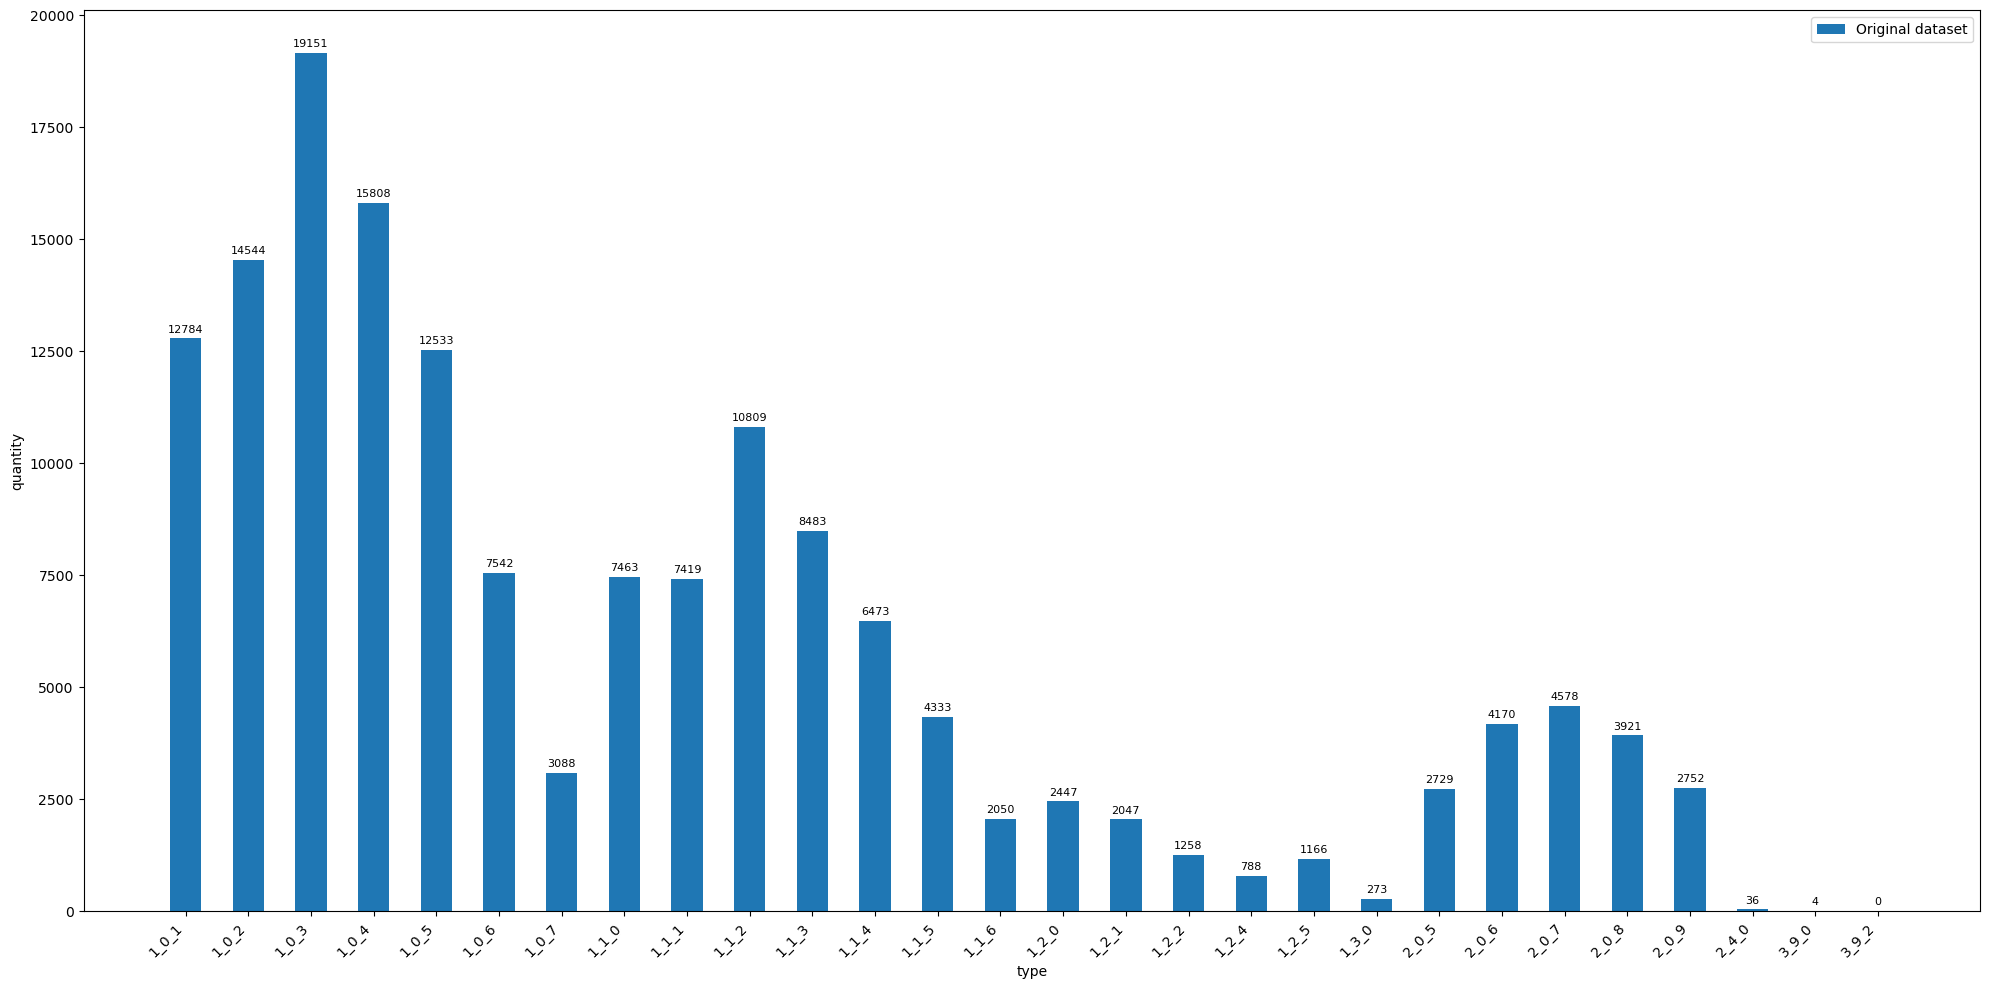

In [22]:
# 将所有 y_state 数据合并为一个一维数组
y_original = np.concatenate(y_state).flatten()
X_original = np.concatenate(X, axis=0)

# 统计每个类别的样本数
original_class_counts = Counter(y_original)

# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))
# 转换为 NumPy 数组，按类别顺序排列
original_class_distribution = np.zeros(len(total_classes), dtype=int)
for cls in total_classes:
    original_class_distribution[cls] = original_class_counts.get(cls, 0)
    
# 输出结果
print("每个类别的样本分布:")
for cls in total_classes:
    print(f"类别 {cls}: {original_class_distribution[cls]} 次")
    
# 绘制直方图
x = np.arange(len(total_classes))  # 类别索引
width = 0.5  # 直方图宽度

fig, ax = plt.subplots(figsize=(20, 10))
rects = ax.bar(x, original_class_distribution, width, label='Original dataset')

# 添加标签、标题和图例
ax.set_xlabel('type')
ax.set_ylabel('quantity')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in state_encoder.classes_], rotation=45, ha='right')  # 使用 state_encoder.classes_ 中的类别名称
ax.legend()

# 在柱状图上方显示具体数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects)

# 显示图形
plt.tight_layout()
plt.show()

（统计y_time的数量分布）

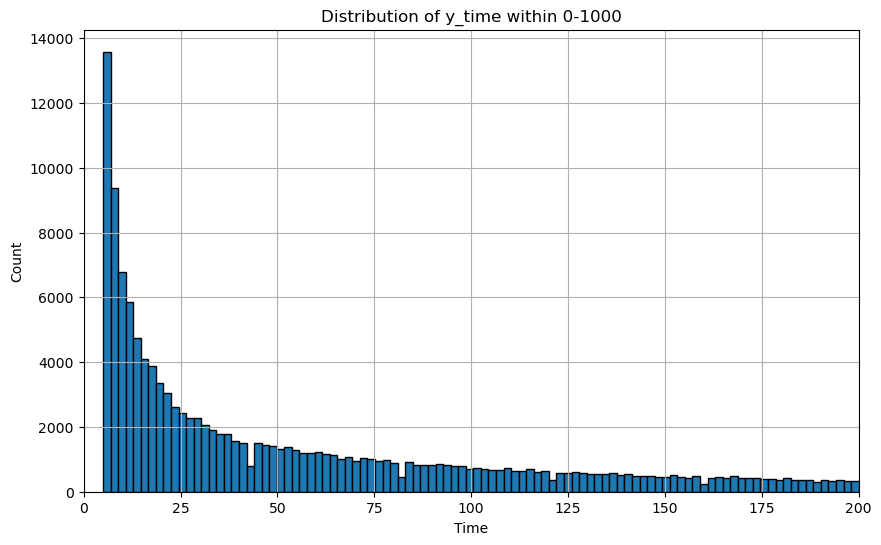

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 y_time 已经被定义，并且是一个包含多个数组的列表或类似的结构。
# 示例：如果需要测试，请取消注释以下行并调整尺寸以匹配实际情况
# y_time = [np.random.randint(0, 1500, size=10) for _ in range(5)]  # 示例数据

# 将所有 y_time 数组展平成一维数组，并筛选出 0-1000 范围的数据
all_y_time = np.concatenate(y_time)
filtered_y_time = all_y_time[(all_y_time >= 0) & (all_y_time <= 200)]

# 绘制直方图
plt.figure(figsize=(10, 6))
# 增加 bins 的数量以细化横坐标
plt.hist(filtered_y_time, bins=100, edgecolor='black')  # 这里将 bins 设置为 50
plt.xlim(0, 200)  # 设置 x 轴范围为 0 到 1000
plt.title('Distribution of y_time within 0-1000')
plt.xlabel('Time')
plt.ylabel('Count')
plt.grid(True)
plt.show()

（统计每种X对应多少种y以及具体的比例）

In [24]:
import numpy as np
from collections import defaultdict, Counter

def analyze_y_for_each_x(X, y):
    """
    统计：对给定的 X, y (长度相同)，其中 X[i].shape = (m_i, 2, 2)， y[i].shape = (m_i, 1)，
         收集每个子序列 x_seq 对应出现了哪些 y，并且 y 出现了多少次。

    返回：
        x2y_distribution: dict,
            key = x_seq_tuple (例如 (1.0, 2.0, 3.0, 4.0) 的 tuple, 即将 (2,2) flatten 后的结果),
            value = Counter({y_val: freq})，统计该 x_seq 对应的 y_val 及其出现次数
    """
    x2y_distribution = defaultdict(Counter)

    # 遍历所有外层数据
    for i in range(len(X)):
        xi = X[i]  # 形如 (m_i, 2, 2)
        yi = y[i]  # 形如 (m_i, 1)

        # 遍历该条数据里的所有子序列
        for j in range(xi.shape[0]):
            # xi[j] 形如 (2,2)
            # 将其展平成 1D 数组后，再转为 tuple 以便做字典键
            seq_tuple = tuple(xi[j].flatten())  
            # y_val 是一个整数
            y_val = yi[j]
            # 累加统计
            x2y_distribution[seq_tuple][y_val] += 1
    
    return x2y_distribution


def print_y_distribution_for_x(x2y_distribution, top_k=10):
    """
    对于 x2y_distribution (由上面函数返回)，打印：
      - 每个 x_seq_tuple 的总出现次数
      - 该 x_seq_tuple 对应的不同 y 的种类数
      - 不同 y 的出现次数及所占比例

    参数：
    - x2y_distribution: dict,
        key = x_seq_tuple, value = Counter({y_val: freq})
    - top_k: 只打印出现总次数最多的前 top_k 个 x_seq，以防止输出过多。
             若为 None 则打印所有 x_seq。
    """
    # 将所有 x_seq 排序（例如，按总出现次数从大到小）。
    x_freq_list = []
    for x_seq, counter_for_x in x2y_distribution.items():
        total_count = sum(counter_for_x.values())
        x_freq_list.append((x_seq, total_count))
    
    # 按出现总数从大到小排序
    x_freq_list.sort(key=lambda x: x[1], reverse=True)

    if top_k is not None:
        x_freq_list = x_freq_list[:top_k]
    
    # 依次打印
    print(f"一共有 {len(x2y_distribution)} 种不同的 X 序列(展平后作为元组)。")
    for x_seq, freq_sum in x_freq_list:
        counter_for_x = x2y_distribution[x_seq]
        distinct_y_count = len(counter_for_x)
        
        print("=" * 50)
        print(f"X(flatten)={x_seq}, 总出现次数 {freq_sum}, 对应 {distinct_y_count} 种不同 y")
        
        # 取得各 y 的出现次数，从大到小
        y_most_common = counter_for_x.most_common()
        
        for y_val, freq in y_most_common:
            proportion = freq / freq_sum
            print(f"  y={y_val} 出现 {freq} 次，占比 {proportion:.2%}")


# =====================
# 使用示例
# =====================
# 1) 假设你已有 X, y (长度都是 10632)
#   - X[i].shape = (m_i, 2, 2)
#   - y[i].shape = (m_i, 1)
# 2) 收集 x->y 的分布
x2y_dist = analyze_y_for_each_x(X, y_state)

# 3) 打印统计信息
#    top_k=10 表示只打印出现总次数最多的前10种 X 序列
#    如果你想打印全部，可以设置 top_k=None
print_y_distribution_for_x(x2y_dist, top_k=10)


一共有 118056 种不同的 X 序列(展平后作为元组)。
X(flatten)=(22, 61, 23, 5, 24, 50), 总出现次数 4, 对应 2 种不同 y
  y=22 出现 2 次，占比 50.00%
  y=3 出现 2 次，占比 50.00%
X(flatten)=(0, 5, 15, 28, 0, 6), 总出现次数 4, 对应 1 种不同 y
  y=15 出现 4 次，占比 100.00%
X(flatten)=(24, 23, 22, 32, 24, 210), 总出现次数 4, 对应 1 种不同 y
  y=4 出现 4 次，占比 100.00%
X(flatten)=(24, 8, 22, 78, 21, 11), 总出现次数 4, 对应 2 种不同 y
  y=3 出现 2 次，占比 50.00%
  y=23 出现 2 次，占比 50.00%
X(flatten)=(21, 236, 23, 67, 24, 34), 总出现次数 4, 对应 2 种不同 y
  y=4 出现 2 次，占比 50.00%
  y=3 出现 2 次，占比 50.00%
X(flatten)=(21, 453, 23, 41, 22, 123), 总出现次数 4, 对应 2 种不同 y
  y=4 出现 2 次，占比 50.00%
  y=11 出现 2 次，占比 50.00%
X(flatten)=(23, 7, 21, 481, 23, 436), 总出现次数 4, 对应 1 种不同 y
  y=5 出现 4 次，占比 100.00%
X(flatten)=(26, 28, 27, 9, 19, 6), 总出现次数 4, 对应 1 种不同 y
  y=14 出现 4 次，占比 100.00%
X(flatten)=(7, 143, 9, 6, 0, 21), 总出现次数 4, 对应 2 种不同 y
  y=8 出现 2 次，占比 50.00%
  y=2 出现 2 次，占比 50.00%
X(flatten)=(4, 6, 18, 93, 4, 6), 总出现次数 4, 对应 1 种不同 y
  y=18 出现 4 次，占比 100.00%


分割数据集

In [25]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
# 同时保持三个部分的对应关系
X_train, X_test, y_state_train, y_state_test, y_time_train, y_time_test = train_test_split(
    X, y_state, y_time, 
    test_size=0.3, 
    random_state=42
)
print(X_train.shape,y_state_train.shape, y_time_train.shape)
print(X_test.shape,y_state_test.shape, y_time_test.shape)

X_train = np.concatenate(X_train)
y_state_train = np.concatenate(y_state_train)
y_time_train = np.concatenate(y_time_train)

X_test = np.concatenate(X_test)
y_state_test = np.concatenate(y_state_test)
y_time_test = np.concatenate(y_time_test)
print('X_train.shape', X_train.shape,'X_test.shape', X_test.shape)
print('y_state_train.shape', y_state_train.shape,'y_state_test.shape',y_state_test.shape)
print('y_time_train.shape', y_time_train.shape,'y_time_test.shape',y_time_test.shape)

(7442,) (7442,) (7442,)
(3190,) (3190,) (3190,)
X_train.shape (110912, 3, 2) X_test.shape (47737, 3, 2)
y_state_train.shape (110912,) y_state_test.shape (47737,)
y_time_train.shape (110912,) y_time_test.shape (47737,)


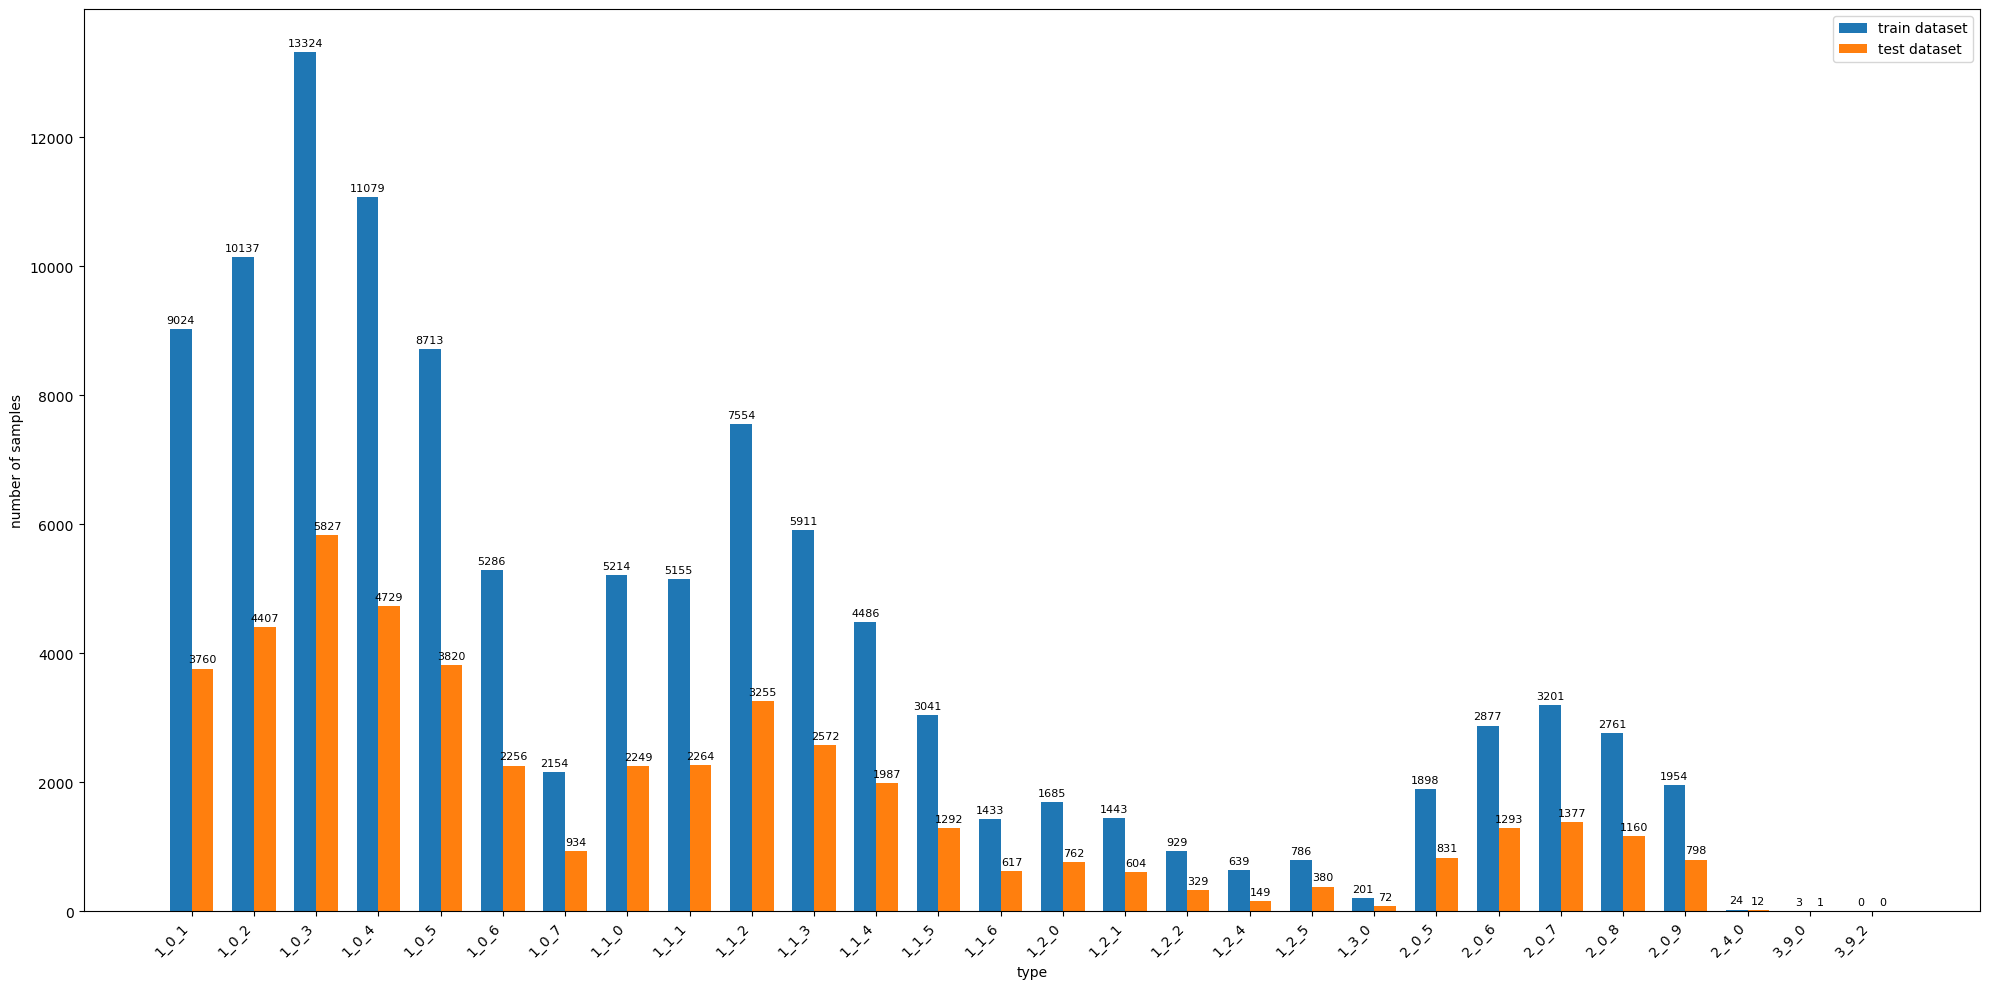

In [26]:
# 获取总的类别范围（通过 state_encoder 的类别总数）
total_classes = np.arange(len(state_encoder.classes_))

# 统计训练集和测试集中每个类别的样本出现次数
train_class_counts = Counter(y_state_train.flatten())  # 统计训练集中每个类别的出现次数
test_class_counts = Counter(y_state_test.flatten())    # 统计测试集中每个类别的出现次数

# 转换为 NumPy 数组，按类别顺序排列
train_class_distribution = np.zeros(len(total_classes), dtype=int)
test_class_distribution = np.zeros(len(total_classes), dtype=int)

for cls in total_classes:
    train_class_distribution[cls] = train_class_counts.get(cls, 0)
    test_class_distribution[cls] = test_class_counts.get(cls, 0)
    
# # 输出结果
# print("训练集中每个类别的样本分布:")
# for cls in total_classes:
#     print(f"类别 {cls}: {train_class_distribution[cls]} 次")

# print("\n测试集中每个类别的样本分布:")
# for cls in total_classes:
#     print(f"类别 {cls}: {test_class_distribution[cls]} 次")    
    
# 绘制直方图
x = np.arange(len(total_classes))  # 类别索引
width = 0.35  # 直方图宽度

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x - width/2, train_class_distribution, width, label='train dataset')
rects2 = ax.bar(x + width/2, test_class_distribution, width, label='test dataset')

# 添加标签、标题和图例
ax.set_xlabel('type')
ax.set_ylabel('number of samples')
ax.set_xticks(x)
ax.set_xticklabels([f"{cls}" for cls in state_encoder.classes_], rotation=45, ha='right')  # 使用 state_encoder.classes_ 中的类别名称
ax.legend()

# 在柱状图上方显示具体数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=8)

autolabel(rects1)
autolabel(rects2)

# 显示图形
plt.tight_layout()
plt.show()

## 3.2 对数据集进行特征处理

### 1.1. 针对单输出任务,x,y的特征均为4的数据集进行特征处理

#### a.对前三维特征进行标准化处理,对第4维特征进行取对数处理

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
X_scaler = StandardScaler()
X_train_features_3 = X_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)
# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4) 
X_test_feature_4 = np.log(X_test_feature_4)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)





# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
y_scaler = StandardScaler()
y_train_features_3 = y_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
y_train_feature_4 = np.log(y_train_feature_4) 
y_test_feature_4 = np.log(y_test_feature_4)

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)



# 检查结果
print(y_train_processed.shape)  # 应该是 (89204, 4)
print(y_test_processed.shape)   # 应该是 (38902, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### b.对前三维特征进行标准化处理,对第4维特征不处理

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
X_scaler = StandardScaler()
X_train_features_3 = X_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征不做处理
X_train_feature_4 = X_train_feature_4 
X_test_feature_4 = X_test_feature_4

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)





# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
y_scaler = StandardScaler()
y_train_features_3 = y_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# 对第四个特征不做处理
y_train_feature_4 = y_train_feature_4
y_test_feature_4 = y_test_feature_4

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_feature_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)



# 检查结果
print(y_train_processed.shape)  # 应该是 (89204, 4)
print(y_test_processed.shape)   # 应该是 (38902, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### c.对前四个维特征进行标准化处理

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
X1_scaler = StandardScaler()
X_train_features_3 = X1_scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = X1_scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征也进行scaler处理
X2_scaler = StandardScaler()
X_train_features_4 = X2_scaler.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
X_test_features_4 = X2_scaler.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_features_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_features_4[..., np.newaxis]], axis=-1)



# 提取前三个特征（前3列）
y_train_features_3 = y_train[:, :3]
y_test_features_3 = y_test[:, :3]

# 提取第四个特征（第4列）
y_train_feature_4 = y_train[:, 3]
y_test_feature_4 = y_test[:, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
y1_scaler = StandardScaler()
y_train_features_3 = y1_scaler.fit_transform(y_train_features_3.reshape(-1, 3)).reshape(y_train_features_3.shape)
y_test_features_3 = y1_scaler.transform(y_test_features_3.reshape(-1, 3)).reshape(y_test_features_3.shape)

# 对第四个特征也进行scaler处理
y2_scaler = StandardScaler()
y_train_features_4 = y2_scaler.fit_transform(y_train_feature_4.reshape(-1, 1)).reshape(y_train_feature_4.shape)
y_test_features_4 = y2_scaler.transform(y_test_feature_4.reshape(-1, 1)).reshape(y_test_feature_4.shape)

# 合并处理后的特征
y_train_processed = np.concatenate([y_train_features_3, y_train_features_4[..., np.newaxis]], axis=-1)
y_test_processed = np.concatenate([y_test_features_3, y_test_features_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)



# 检查结果
print(y_train_processed.shape)  # 应该是 (89204, 4)
print(y_test_processed.shape)   # 应该是 (38902, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

### 1.2.  针对单输出任务,x,y的特征分别为4和1的数据集进行特征处理

#### a.对X特征进行标准化和取对数处理,对y取对数

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 标准化前三个特征，标准化特征可以使得数据不会受到某个特征由于数值范围与其它特征的数值范围差别较大而导致对于模型对于特征敏感度的影响
scaler = StandardScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)################################################################################################################这里为啥是transform而不是fit_transform

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免取log(0)的错误#############################################################################################这么处理会导致时间原本设定为0的位置变为了一个相同的但是比较大的负数，会不会对结果造成干扰？??,改成+1会不会好一些？
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (89204, 10, 4) #如果是分子状态和停留时间同时预测
print(X_test_processed.shape)   # 应该是 (38902, 10, 4)

# 对第四个特征取对数（确保数值大于0）
y_train_processed = np.log(y_train + 1e-6)  # 加上一个小常数避免log(0)
y_test_processed = np.log(y_test + 1e-6)


# 检查结果
print(y_train_processed.shape)  
print(y_test_processed.shape)   

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### b.对X特征进行归一化和取对数处理,对y取对数

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 归一化前三个特征
scaler = MinMaxScaler()
X_train_features_3 = scaler.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免取log(0)的错误
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)
print(X_test_processed.shape)

# 对第四个特征取对数（确保数值大于0）
y_train_processed = np.log(y_train + 1e-6)  # 加上一个小常数避免log(0)
y_test_processed = np.log(y_test + 1e-6)

# 检查结果
print(y_train_processed.shape) 
print(y_test_processed.shape) 


In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

#### c.对X特征进行归一化和标准化处理,对y进行标准化处理

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 假设你的训练集和测试集是 X_train 和 X_test
# X_train 和 X_test 形状为 (n_samples, 10, 4)

# 提取前三个特征（前3列）
X_train_features_3 = X_train[:, :, :3]
X_test_features_3 = X_test[:, :, :3]

# 提取第四个特征（第4列）
X_train_feature_4 = X_train[:, :, 3]
X_test_feature_4 = X_test[:, :, 3]

# 归一化前三个特征
scaler_3 = MinMaxScaler()
X_train_features_3 = scaler_3.fit_transform(X_train_features_3.reshape(-1, 3)).reshape(X_train_features_3.shape)
X_test_features_3 = scaler_3.transform(X_test_features_3.reshape(-1, 3)).reshape(X_test_features_3.shape)

# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4 + 1e-6)  # 加上一个小常数避免log(0)
X_test_feature_4 = np.log(X_test_feature_4 + 1e-6)

# 标准化第四个特征
scaler_4 = StandardScaler()
X_train_feature_4 = scaler_4.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(X_train_feature_4.shape)
X_test_feature_4 = scaler_4.transform(X_test_feature_4.reshape(-1, 1)).reshape(X_test_feature_4.shape)



# 合并处理后的特征
X_train_processed = np.concatenate([X_train_features_3, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_features_3, X_test_feature_4[..., np.newaxis]], axis=-1)

# 检查结果
print(X_train_processed.shape)  # 应该是 (n_samples, 10, 4)
print(X_test_processed.shape)   # 应该是 (n_samples, 10, 4)

# 对第四个特征取对数（确保数值大于0）
y_train_processed = np.log(y_train + 1e-6)  # 加上一个小常数避免log(0)
y_test_processed = np.log(y_test + 1e-6)

# 对目标变量进行标准化
scaler_y = StandardScaler()
y_train_processed = scaler_y.fit_transform(y_train)  # 直接对y进行标准化
y_test_processed = scaler_y.transform(y_test)  # 使用训练集的标准化参数处理测试集


# 检查结果
print(y_train_processed.shape)  # 应该是 (n_samples, 4)
print(y_test_processed.shape)   # 应该是 (n_samples, 4)

In [ ]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

### 1.3 针对单目标输出任务,x,y的特征均为1(状态)

In [99]:
# 目前还没有特征处理代码

In [9]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))

test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [27]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_state_train))

test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_state_test))

### 1.4 针对单目标输出任务，X的特征维4维，y的特征为3维

#### a.对X和y的特征不进行任何处理

In [12]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))

test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

#### b.对X前三维特征进行标准化处理，对第四维特征不处理,对y的特征进行标准化处理

In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 假设你已经有了以下变量：
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)  # (2825, 3)
print("y_test shape:", y_test.shape)    # (707, 3)

# =============== 对 X 的前三维度进行标准化，保留第4维 ===============

# 1) 将 X 的前3维分开
X_train_features_3 = X_train[:, :, :3]  # 形状 (n_train, 11, 3)
X_test_features_3 = X_test[:, :, :3]    # 形状 (n_test, 11, 3)

# 2) 将 X 的第4维分开
X_train_feature_4 = X_train[:, :, 3]    # 形状 (n_train, 11)
X_test_feature_4 = X_test[:, :, 3]      # 形状 (n_test, 11)

# 3) 对前三个维度进行标准化
X_scaler = StandardScaler()

# 需要先 reshape 成二维矩阵 (n_samples * seq_len, 3)，再还原回三维
n_train, seq_len, _ = X_train_features_3.shape
n_test = X_test_features_3.shape[0]

X_train_3d_reshaped = X_train_features_3.reshape(-1, 3)  # (n_train*11, 3)
X_test_3d_reshaped = X_test_features_3.reshape(-1, 3)    # (n_test*11, 3)

X_train_3d_scaled = X_scaler.fit_transform(X_train_3d_reshaped)
X_test_3d_scaled = X_scaler.transform(X_test_3d_reshaped)

# 4) reshape 回原形状
X_train_3d_scaled = X_train_3d_scaled.reshape(n_train, seq_len, 3)
X_test_3d_scaled = X_test_3d_scaled.reshape(n_test, seq_len, 3)

# 5) 保留的第四维不做任何变换，重新拼接
X_train_processed = np.concatenate([X_train_3d_scaled, 
                                    X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_3d_scaled, 
                                   X_test_feature_4[..., np.newaxis]], axis=-1)

# =============== 对 y 的 3 个维度进行标准化 ===============
y_scaler = StandardScaler()

# y_train 和 y_test 原本就是 (n_samples, 3)，可以直接标准化
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== 检查结果 ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # 预期 (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # 预期 (707, 11, 4)

print("y_train_processed shape:", y_train_processed.shape)  # 预期 (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # 预期 (707, 3)

#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

Before processing:
X_train shape: (2825, 11, 4)
X_test shape: (707, 11, 4)
y_train shape: (2825, 3)
y_test shape: (707, 3)

After processing:
X_train_processed shape: (2825, 11, 4)
X_test_processed shape: (707, 11, 4)
y_train_processed shape: (2825, 3)
y_test_processed shape: (707, 3)


#### c.对前三维特征进行标准化处理，对第四维特征取log

In [61]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 假设你已经有了以下变量：
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)  # (2825, 3)
print("y_test shape:", y_test.shape)    # (707, 3)

# =============== 对 X 的前三维度进行标准化，保留第4维 ===============

# 1) 将 X 的前3维分开
X_train_features_3 = X_train[:, :, :3]  # 形状 (n_train, 11, 3)
X_test_features_3 = X_test[:, :, :3]    # 形状 (n_test, 11, 3)

# 2) 将 X 的第4维分开
X_train_feature_4 = X_train[:, :, 3]    # 形状 (n_train, 11)
X_test_feature_4 = X_test[:, :, 3]      # 形状 (n_test, 11)

# 3) 对前三个维度进行标准化
X_scaler = StandardScaler()

# 需要先 reshape 成二维矩阵 (n_samples * seq_len, 3)，再还原回三维
n_train, seq_len, _ = X_train_features_3.shape
n_test = X_test_features_3.shape[0]

X_train_3d_reshaped = X_train_features_3.reshape(-1, 3)  # (n_train*11, 3)
X_test_3d_reshaped = X_test_features_3.reshape(-1, 3)    # (n_test*11, 3)

X_train_3d_scaled = X_scaler.fit_transform(X_train_3d_reshaped)
X_test_3d_scaled = X_scaler.transform(X_test_3d_reshaped)

# 4) reshape 回原形状
X_train_3d_scaled = X_train_3d_scaled.reshape(n_train, seq_len, 3)
X_test_3d_scaled = X_test_3d_scaled.reshape(n_test, seq_len, 3)


# 对第四个特征取对数（确保数值大于0）
X_train_feature_4 = np.log(X_train_feature_4) 
X_test_feature_4 = np.log(X_test_feature_4)

# 5) 保留的第四维不做任何变换，重新拼接
X_train_processed = np.concatenate([X_train_3d_scaled, 
                                    X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_3d_scaled, 
                                   X_test_feature_4[..., np.newaxis]], axis=-1)

# =============== 对 y 的 3 个维度进行标准化 ===============
y_scaler = StandardScaler()

# y_train 和 y_test 原本就是 (n_samples, 3)，可以直接标准化
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== 检查结果 ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # 预期 (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # 预期 (707, 11, 4)

print("y_train_processed shape:", y_train_processed.shape)  # 预期 (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # 预期 (707, 3)

#将数据进一步转换成深度学习框架需要的张量tensor形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))

test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))

Before processing:
X_train shape: (2825, 11, 4)
X_test shape: (707, 11, 4)
y_train shape: (2825, 3)
y_test shape: (707, 3)

After processing:
X_train_processed shape: (2825, 11, 4)
X_test_processed shape: (707, 11, 4)
y_train_processed shape: (2825, 3)
y_test_processed shape: (707, 3)


#### d.X的四维直接进行标准化，y的三维都标准化

In [55]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset

# ----------------------------
# 假设你已经有了以下变量：
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)    # (2825, 3)
print("y_test shape:", y_test.shape)      # (707, 3)

# =============== 对 X 的所有 4 个特征一起进行标准化 ===============
n_train, seq_len, n_features = X_train.shape  # n_features 应为 4
n_test = X_test.shape[0]

# reshape 为二维数组 (n_train*seq_len, 4)
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

# 使用 StandardScaler 对整个二维数组进行标准化
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.transform(X_test_reshaped)

# reshape 回原来的三维形状
X_train_processed = X_train_scaled.reshape(n_train, seq_len, n_features)
X_test_processed = X_test_scaled.reshape(n_test, seq_len, n_features)

# =============== 对 y 的 3 个维度进行标准化 ===============
y_scaler = StandardScaler()
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== 检查结果 ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # (707, 11, 4)
print("y_train_processed shape:", y_train_processed.shape)  # (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # (707, 3)

# 将数据进一步转换成深度学习框架需要的张量 tensor 形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))
test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))


Before processing:
X_train shape: (7587, 9, 4)
X_test shape: (843, 9, 4)
y_train shape: (7587, 3)
y_test shape: (843, 3)

After processing:
X_train_processed shape: (7587, 9, 4)
X_test_processed shape: (843, 9, 4)
y_train_processed shape: (7587, 3)
y_test_processed shape: (843, 3)


#### e.X的四维直接进行标准化，y不处理

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset

# ----------------------------
# 假设你已经有了以下变量：
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)    # (2825, 3)
print("y_test shape:", y_test.shape)      # (707, 3)

# =============== 对 X 的前三个特征进行标准化 ===============
# 1) 将 X 的前3个特征分开
X_train_features_3 = X_train[:, :, :3]  # 形状 (n_train, 11, 3)
X_test_features_3 = X_test[:, :, :3]    # 形状 (n_test, 11, 3)

# 2) 对前三个特征进行标准化
X_scaler_3 = StandardScaler()
n_train, seq_len, _ = X_train_features_3.shape
n_test = X_test_features_3.shape[0]

# reshape 为二维数组，再标准化，最后恢复原形状
X_train_3d_reshaped = X_train_features_3.reshape(-1, 3)  # (n_train*11, 3)
X_test_3d_reshaped = X_test_features_3.reshape(-1, 3)    # (n_test*11, 3)

X_train_3d_scaled = X_scaler_3.fit_transform(X_train_3d_reshaped)
X_test_3d_scaled = X_scaler_3.transform(X_test_3d_reshaped)

X_train_3d_scaled = X_train_3d_scaled.reshape(n_train, seq_len, 3)
X_test_3d_scaled = X_test_3d_scaled.reshape(n_test, seq_len, 3)

# =============== 对 X 的第四个特征进行单独标准化 ===============
# 1) 提取第四个特征
X_train_feature_4 = X_train[:, :, 3]    # 形状 (n_train, 11)
X_test_feature_4 = X_test[:, :, 3]      # 形状 (n_test, 11)

# # 2) 对第四个特征先取对数（确保数值大于0）
# X_train_feature_4 = np.log(X_train_feature_4)
# X_test_feature_4 = np.log(X_test_feature_4)

# 3) 对第四个特征单独标准化
scaler_feature4 = StandardScaler()
# reshape为二维数组，标准化后再恢复原形状
X_train_feature_4 = scaler_feature4.fit_transform(X_train_feature_4.reshape(-1, 1)).reshape(n_train, seq_len)
X_test_feature_4 = scaler_feature4.transform(X_test_feature_4.reshape(-1, 1)).reshape(n_test, seq_len)

# =============== 合并处理后的特征 ===============
X_train_processed = np.concatenate([X_train_3d_scaled, X_train_feature_4[..., np.newaxis]], axis=-1)
X_test_processed = np.concatenate([X_test_3d_scaled, X_test_feature_4[..., np.newaxis]], axis=-1)

# =============== 对 y 的 3 个维度进行标准化 ===============
# y_train 和 y_test 原本就是二维 (n_samples, 3)
y_train_processed = y_train
y_test_processed = y_test

# =============== 检查结果 ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # 应为 (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # 应为 (707, 11, 4)
print("y_train_processed shape:", y_train_processed.shape)  # 应为 (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # 应为 (707, 3)

# 将数据进一步转换成深度学习框架需要的张量 tensor 形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))
test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))


Before processing:
X_train shape: (2825, 11, 4)
X_test shape: (707, 11, 4)
y_train shape: (2825, 3)
y_test shape: (707, 3)

After processing:
X_train_processed shape: (2825, 11, 4)
X_test_processed shape: (707, 11, 4)
y_train_processed shape: (2825, 3)
y_test_processed shape: (707, 3)


### 1.5 针对单目标输出任务X3维，y三维

#### a.X和y全部标准化

In [16]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset

# ----------------------------
# 假设你已经有了以下变量：
# X_train, X_test, y_train, y_test
# ----------------------------
print("Before processing:")
print("X_train shape:", X_train.shape)  # (2825, 11, 4)
print("X_test shape:", X_test.shape)    # (707, 11, 4)
print("y_train shape:", y_train.shape)    # (2825, 3)
print("y_test shape:", y_test.shape)      # (707, 3)



# =============== 对 X 的 3 个维度进行标准化 ===============
n_train, seq_len, n_features = X_train.shape  # n_features 应为 4
n_test = X_test.shape[0]

# reshape 为二维数组 (n_train*seq_len, 3)
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)


X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
X_test_scaled = X_scaler.transform(X_test_reshaped)

# reshape 回原来的三维形状
X_train_processed = X_train_scaled.reshape(n_train, seq_len, n_features)
X_test_processed = X_test_scaled.reshape(n_test, seq_len, n_features)

# =============== 对 y 的 3 个维度进行标准化 ===============
y_scaler = StandardScaler()
y_train_processed = y_scaler.fit_transform(y_train)
y_test_processed = y_scaler.transform(y_test)

# =============== 检查结果 ===============
print("\nAfter processing:")
print("X_train_processed shape:", X_train_processed.shape)  # (2825, 11, 4)
print("X_test_processed shape:", X_test_processed.shape)    # (707, 11, 4)
print("y_train_processed shape:", y_train_processed.shape)  # (2825, 3)
print("y_test_processed shape:", y_test_processed.shape)    # (707, 3)

# 将数据进一步转换成深度学习框架需要的张量 tensor 形式
train_data = TensorDataset(torch.tensor(X_train_processed), torch.tensor(y_train_processed))
test_data = TensorDataset(torch.tensor(X_test_processed), torch.tensor(y_test_processed))


Before processing:
X_train shape: (6744, 9, 4)
X_test shape: (1686, 9, 4)
y_train shape: (6744, 3)
y_test shape: (1686, 3)

After processing:
X_train_processed shape: (6744, 9, 4)
X_test_processed shape: (1686, 9, 4)
y_train_processed shape: (6744, 3)
y_test_processed shape: (1686, 3)


### 2. 针对多输出任务,X和y_state,y_time的特征均为1的数据集进行特征处理

In [8]:
# 目前还没有特征处理代码

In [18]:
#将数据进一步转换成深度学习框架需要的张量tensor形式
X_train_tensor = torch.tensor(X_train)
X_test_tensor = torch.tensor(X_test)
y_state_train_tensor = torch.tensor(y_state_train)
y_state_test_tensor = torch.tensor(y_state_test)
y_time_train_tensor = torch.tensor(y_time_train)
y_time_test_tensor = torch.tensor(y_time_test)

# 创建带多目标的数据集
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(
    X_train_tensor, 
    y_state_train_tensor,
    y_time_train_tensor
)

test_data = TensorDataset(
    X_test_tensor,
    y_state_test_tensor,
    y_time_test_tensor
)

# 四.机器学习模型框架

## 1. 单输出任务

### 1.1 LSTM模型 - 回归任务

In [17]:
# LSTM model (Stacked Long Short-Term Memory Networks,因为num_layers>1)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) #out 的形状为：(batch_size,sequence_length,hidden_size)
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # 从所有样本中提取序列的最后一个时间步的输出，因此其形状为：(batch_size,hidden_size)
        out = self.fc(out) #输出 out 的最终形状为：(batch_size,num_classes)
        return out

#### 1.1.2.LSTM +残差连接（ResidualLSTM）

In [18]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 本体
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True, 
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # 当 input_size != hidden_size 时，用线性层把输入的最后一步投影到 hidden_size
        # 这样才能和 LSTM 的输出尺寸相加
        if input_size != hidden_size:
            self.residual_proj = nn.Linear(input_size, hidden_size, bias=False)
        else:
            self.residual_proj = None

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # 初始化 h0, c0
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        # LSTM 前向传播
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, sequence_length, hidden_size)

        # 取出最后一个时间步的 LSTM 输出 (batch_size, hidden_size)
        out_last = out[:, -1, :]

        # 残差分支：取输入的最后一个时间步 (batch_size, input_size)
        residual = x[:, -1, :]
        if self.residual_proj is not None:
            # 如果输入和 hidden_size 不一致，就做一个线性变换
            residual = self.residual_proj(residual)  # (batch_size, hidden_size)

        # 将 LSTM 的输出与残差分支做相加
        out = out_last + residual  # (batch_size, hidden_size)

        # 后面接 Dropout 和全连接
        out = self.dropout(out)
        out = self.fc(out)         # (batch_size, num_classes)

        return out

### 1.2 LSTM+单头自注意力机制 - 回归任务

In [ ]:
# LSTM_SelfAttention model
#简化版的单头子注意力机制代码
class SelfAttention(nn.Module): #这里相当于一个简化版的自注意力机制机制,输出的是一个综合性的结果
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_output的形状是(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights) #请注意,这里lstm_output的维度为(batch_size, seq_len, hidden_size)
        # attention_scores的形状是(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1) 
        # 使用attention_scores对lstm_output进行加权求和
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1) #自注意力机制一定是要进行这一步对加权后的结果进行求和的步骤,对时间维度进行归一化,输出一个综合了序列全部信息的新结果,维度维(batch_size, hidden_size),
        # output的形状是(batch_size, hidden_size)
        return output



# #标准版的含有q,k,v的自注意力机制代码
# class SelfAttention(nn.Module):
#     def __init__(self, hidden_size, num_heads=1):
#         super(SelfAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_heads = num_heads  # 注意力头的数量
#         self.d_k = hidden_size // num_heads  # 每个头的维度
        
#         # 定义线性变换层，用于生成 Q、K、V
#         self.q_linear = nn.Linear(hidden_size, hidden_size)
#         self.k_linear = nn.Linear(hidden_size, hidden_size)
#         self.v_linear = nn.Linear(hidden_size, hidden_size)
        
#         # 输出线性变换层
#         self.out_linear = nn.Linear(hidden_size, hidden_size)

#     def forward(self, lstm_output):
#         """
#         输入:
#             lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
#         输出:
#             output: 自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
#         """
#         batch_size, seq_len, _ = lstm_output.size()
        
#         # 生成 Query、Key 和 Value
#         q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k) #输出形状：(batch_size, num_heads, seq_len, head_dim)。
#         k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k)
#         v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)  # (batch_size, num_heads, seq_len, d_k)
        
#         # 计算注意力分数
#         attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
#         attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
#         # 加权求和
#         weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, d_k)
#         weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
#         # 输出线性变换
#         output = self.out_linear(weighted_output)  # (batch_size, seq_len, hidden_size)
        
#         # 对时间维度进行加权求和，生成最终的表示
#         output = torch.sum(output, dim=1)  # (batch_size, hidden_size)
        
#         return output

# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 使用自注意力机制处理LSTM的输出
        attn_out = self.attention(lstm_out)
        # 应用 Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

### 1.3 MultiHeadSelfAttention-回归任务

In [57]:
# BiLSTM-MAIN model

# # 简化版的多头自注意力机制代码,没有使用q,k,v
# class MultiHeadSelfAttention(nn.Module):
#     def __init__(self, hidden_size, num_heads):
#         super(MultiHeadSelfAttention, self).__init__()
#         self.num_heads = num_heads
#         self.head_dim = hidden_size // num_heads
#         assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
#         self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
#         nn.init.xavier_uniform_(self.attention_heads)
        
#         self.fc = nn.Linear(hidden_size, hidden_size)

#     def forward(self, lstm_output):
#         batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
#         # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
#         lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
#         # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
#         lstm_output = lstm_output.transpose(1, 2)
#         # Compute attention scores
#         attention_scores = torch.matmul(lstm_output, self.attention_heads)
#         # Apply softmax to get the weights on the values
#         attention_scores = F.softmax(attention_scores, dim=-2)
#         # Apply attention weights to lstm_output
#         weighted_output = attention_scores * lstm_output
#         # Sum weighted output over seq_len dimension
#         weighted_output = weighted_output.sum(dim=-2)
#         # Reshape weighted_output to (batch_size, hidden_size)
#         weighted_output = weighted_output.reshape(batch_size, -1)
#         # Pass through the fully connected layer
#         output = self.fc(weighted_output)
#         return output

#标准版本的多头自注意力机制代码
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # 定义线性变换层，用于生成 Q、K、V
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # 输出线性变换层
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        输入:
            lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
        输出:
            output: 多头自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # 生成 Query、Key 和 Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
        # 加权求和
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # 输出线性变换
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # 对时间维度进行加权求和，生成最终的表示
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #考虑这一步可以替换为:out = out[:, -1, :]  # 取最后一个时间步的输出作为最终结果;或者out = torch.mean(out, dim=1)  # 平均池化;或者out = torch.max(out, dim=1)[0]  # 最大池化;或者attention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output
    
    
    
# # BiLSTM-MAIN model
# class LSTMWithMulAttention(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
#         super(LSTMWithMulAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
#         self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
#         self.layer_norm = nn.LayerNorm(hidden_size*2)
#         self.dropout = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size*2, num_classes)
#         # 添加残差连接的线性层
#         self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
#         c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
#         lstm_out, _ = self.lstm(x, (h0, c0))
#         # 添加残差连接
#         residual_output = lstm_out + self.residual_fc(lstm_out)
#         lstm_out = self.layer_norm(residual_output)
#         attn_out = self.attention(lstm_out)
#         drop_out = self.dropout(attn_out)
#         out = self.fc(drop_out)
#         return out
    
# #修改了残差连接的BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加用于调整 lstm_input 维度的线性层
        self.input_fc = nn.Linear(input_size, hidden_size * 2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 如果初始化性能不好,则尝试h0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device),c0 = torch.randn(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        # 保存 LSTM 输入并调整其维度
        lstm_input = self.input_fc(x)  # 调整维度到 (batch_size, sequence_length, hidden_size * 2)        
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + lstm_input
        # 层归一化
        lstm_out = self.layer_norm(residual_output)
        # 多头自注意力机制
        attn_out = self.attention(lstm_out)
        # Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

### 1.4 MultiHeadSelfAttention-分类任务

In [43]:
#标准版本的多头自注意力机制代码
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # 定义线性变换层，用于生成 Q、K、V
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # 输出线性变换层
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        输入:
            lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
        输出:
            output: 多头自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # 生成 Query、Key 和 Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
        # 加权求和
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # 输出线性变换
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # 对时间维度进行加权求和，生成最终的表示
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #考虑这一步可以替换为:out = out[:, -1, :]  # 取最后一个时间步的输出作为最终结果;或者out = torch.mean(out, dim=1)  # 平均池化;或者out = torch.max(out, dim=1)[0]  # 最大池化;或者attention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output

    
# ========== 双头LSTM加自注意力机制：模型定义 ==========
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # 编码后的类别总数
                 dropout_rate=0.3, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 双向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True)
        
        # 注意力机制
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)
        
        # 共享层
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.input_fc = nn.Linear(input_size, hidden_size * 2)
        
        # 输出层 ---------------------------
        self.fc = nn.Linear(hidden_size*2, num_state_classes)  # 单分类任务
        # ---------------------------------

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_input = self.input_fc(x)
        lstm_out, _ = self.lstm(x, (h0, c0))
        residual_output = lstm_out + lstm_input
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        
        # 输出 ---------------------------
        state_pred = self.fc(drop_out)      # (batch, num_state_classes)
        return state_pred
    

### 1.5 纯LSTM - 分类任务

In [15]:
# ========== 纯LSTM：模型定义 ==========
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # 编码后的类别总数
                 dropout_rate=0.3):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 单向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True)
        
        # 共享层
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        
        # 输出层
        self.fc = nn.Linear(hidden_size, num_state_classes)  # 单分类任务

    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # 取最后一个时间步的输出
        lstm_out_last = lstm_out[:, -1, :]
        
        # 应用LayerNorm和Dropout
        norm_out = self.layer_norm(lstm_out_last)
        drop_out = self.dropout(norm_out)
        
        # 输出层
        state_pred = self.fc(drop_out)      # (batch, num_state_classes)
        return state_pred

## 2.多输出任务

### 2.1 MultiHeadSelfAttention - 分类+回归任务

In [32]:
#标准版本的多头自注意力机制代码
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        # 定义线性变换层，用于生成 Q、K、V
        self.q_linear = nn.Linear(hidden_size, hidden_size)
        self.k_linear = nn.Linear(hidden_size, hidden_size)
        self.v_linear = nn.Linear(hidden_size, hidden_size)
        
        # 输出线性变换层
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        """
        输入:
            lstm_output: LSTM 的输出，形状为 (batch_size, seq_len, hidden_size)
        输出:
            output: 多头自注意力机制处理后的结果，形状为 (batch_size, hidden_size)
        """
        batch_size, seq_len, hidden_size = lstm_output.size()
        
        # 生成 Query、Key 和 Value
        q = self.q_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        k = self.k_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        v = self.v_linear(lstm_output).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch_size, num_heads, seq_len, head_dim)
        
        # 计算注意力分数
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float))  # (batch_size, num_heads, seq_len, seq_len)
        attention_weights = F.softmax(attention_scores, dim=-1)  # 对最后一个维度（seq_len）进行 softmax 归一化
        
        # 加权求和
        weighted_output = torch.matmul(attention_weights, v)  # (batch_size, num_heads, seq_len, head_dim)
        weighted_output = weighted_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)  # (batch_size, seq_len, hidden_size)
        
        # 输出线性变换
        output = self.fc(weighted_output)  # (batch_size, seq_len, hidden_size)
        
        # 对时间维度进行加权求和，生成最终的表示
        #output = torch.sum(output, dim=1)  # (batch_size, hidden_size) #考虑这一步可以替换为:out = out[:, -1, :]  # 取最后一个时间步的输出作为最终结果;或者out = torch.mean(out, dim=1)  # 平均池化;或者out = torch.max(out, dim=1)[0]  # 最大池化;或者attention_weights = F.softmax(torch.randn(out.size(0), out.size(1)).to(out.device), dim=1).unsqueeze(-1),out = torch.sum(out * attention_weights, dim=1)
        output = output[:,-1,:]
        
        return output

    
# ========== 修改1：模型定义 ==========
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, 
                 num_state_classes,  # 编码后的类别总数
                 dropout_rate=0.3, num_heads=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 双向LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, bidirectional=True)
        
        # 注意力机制
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)
        
        # 共享层
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.input_fc = nn.Linear(input_size, hidden_size * 2)
        
        # 输出层 ---------------------------
        self.fc_state = nn.Linear(hidden_size*2, num_state_classes)  # 单分类任务
        self.fc_time = nn.Linear(hidden_size*2, 1)                   # 回归任务
        # ---------------------------------

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_input = self.input_fc(x)
        lstm_out, _ = self.lstm(x, (h0, c0))
        residual_output = lstm_out + lstm_input
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        
        # 输出 ---------------------------
        state_pred = self.fc_state(drop_out)      # (batch, num_state_classes)
        time_pred = self.fc_time(drop_out).squeeze(-1)  # (batch,)
        return state_pred, time_pred

# 五. 模型训练

## 5.1导入数据加载器

In [58]:
from torch.nn.parallel import DataParallel
import torch.nn.functional as F
batch_size = 128
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size) #表示每次从数据集中取出 256 条数据进行训练或测试。表示不打乱数据顺序（通常在时间序列任务中保持顺序很重要）
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

## 5.2 训练模型

### 单输出任务

#### 1.1 回归任务

##### 模型定义与初始化

纯LSTM模型

In [19]:
hidden_size = 128
num_layers = 2
input_size = 4 #输入的X的特征维度
num_classes = 3 #输出的y的特征维度

model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3)
model = model.to(device) #将模型移动到指定设备（如 GPU 或 CPU）
model = nn.DataParallel(model) #如果有多块 GPU，可以使用数据并行加速训练。

LSTMWithMulAttention模型

In [59]:
hidden_size = 256
num_layers = 3
input_size = 4 #输入的X的特征维度
num_classes = 3 #输出的y的特征维度
num_heads = 8

model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3, num_heads=num_heads)
model = model.to(device) #将模型移动到指定设备（如 GPU 或 CPU）
model = nn.DataParallel(model) #如果有多块 GPU，可以使用数据并行加速训练。

##### 损失函数与优化器

In [64]:
criterion = nn.MSELoss() #定义损失函数
optimizer = optim.Adam(model.parameters(), lr=0.00001) #使用 Adam 优化器,学习率为0.0001
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, min_lr=1e-6, verbose=True) #学习率调度器，当验证损失不再下降时降低学习率;每次降低学习率为原来的 0.4 倍。;连续 3 轮验证损失不下降时触发学习率调整。;学习率的最小值;打印学习率调整信息。

##### 训练过程/验证过程/早停机制与模型保存

In [65]:
%%time
# 训练模型
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

#训练过程
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}", unit="batch")):
        x_batch = x_batch.to(device).float()#数据预处理：将 x_batch 和 y_batch 移动到指定设备，并转换为浮点类型。
        y_batch = y_batch.to(device).float()

        x_batch = x_batch.view(-1, sequence_length, input_size) 
        y_batch = y_batch.view(-1, num_classes)

        
        outputs = model(x_batch) #使用模型计算输出 outputs。
        #print("Outputs shape:", outputs.shape)
        #print("y_batch shape:", y_batch.shape)
        loss = criterion(outputs, y_batch) #计算损失值 loss。
        optimizer.zero_grad() #清空梯度
        loss.backward() #反向传播,计算梯度
        optimizer.step() #更新模型参数

        train_losses.append(loss.item()) #将每个批次的损失值存储到 train_losses 中。

#验证过程
    val_losses = []
    model.eval() #模型切换到评估模式：model.eval()。
    with torch.no_grad():#禁用梯度计算：torch.no_grad()，减少内存消耗。在默认情况下，PyTorch 会为每个操作保留中间张量和梯度信息，以便在反向传播时计算梯度。即使在评估或推理阶段，这些中间张量仍然会被保存，占用额外的内存。
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, num_classes)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #调用前面定义的损失函数对象
            val_losses.append(loss.item())

#早停机制与模型保存
    train_loss = np.mean(train_losses) #train_losses 和 val_losses这两个列表分别存储了当前 epoch 中每个批次的训练损失和验证损失。train_loss：当前 epoch 的平均训练损失。
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss) #scheduler：这是一个学习率调度器（如 ReduceLROnPlateau），用于动态调整优化器的学习率。
    loss_values.append([train_loss, val_loss])
    # 训练结束后打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', f"Current learning rate: {current_lr}")

    if val_loss - best_loss < -0.000001: #(1) 判断验证损失是否降低
        if best_loss - val_loss > 0.01:
            early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict()) #保存最佳模型：将最佳模型的参数保存到 best_model。
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break #避免模型在验证集上过拟合，通过提前停止训练来提高泛化能力。

# 训练结束后保存最佳模型
if best_model is not None:
    # 构造模型文件名
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}.pth"
    #filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}.pth"
    # 保存模型
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

train epoch 0: 100%|██████████| 60/60 [00:00<00:00, 126.47batch/s]


Epoch 1/300, Train Loss: 0.14809792724748452, Validation Loss: 0.17749278034482682 Current learning rate: 1e-05


train epoch 1: 100%|██████████| 60/60 [00:00<00:00, 130.89batch/s]


Epoch 2/300, Train Loss: 0.14682929640014966, Validation Loss: 0.1778564942734582 Current learning rate: 1e-05
EarlyStopping counter: 1 out of 20


train epoch 2: 100%|██████████| 60/60 [00:00<00:00, 129.32batch/s]


Epoch 3/300, Train Loss: 0.1464637448390325, Validation Loss: 0.17806710302829742 Current learning rate: 1e-05
EarlyStopping counter: 2 out of 20


train epoch 3: 100%|██████████| 60/60 [00:00<00:00, 129.75batch/s]


Epoch 4/300, Train Loss: 0.14608472908536593, Validation Loss: 0.17846655739205225 Current learning rate: 1e-05
EarlyStopping counter: 3 out of 20


train epoch 4: 100%|██████████| 60/60 [00:00<00:00, 121.95batch/s]


Epoch 5/300, Train Loss: 0.14553467979033788, Validation Loss: 0.1787105245249612 Current learning rate: 1e-05
EarlyStopping counter: 4 out of 20


train epoch 5: 100%|██████████| 60/60 [00:00<00:00, 126.73batch/s]


Epoch 6/300, Train Loss: 0.14500023412207763, Validation Loss: 0.17888808676174708 Current learning rate: 1e-05
EarlyStopping counter: 5 out of 20


train epoch 6: 100%|██████████| 60/60 [00:00<00:00, 122.59batch/s]


Epoch 7/300, Train Loss: 0.1449282745520274, Validation Loss: 0.1790930756500789 Current learning rate: 1e-05
EarlyStopping counter: 6 out of 20


train epoch 7: 100%|██████████| 60/60 [00:00<00:00, 118.36batch/s]


Epoch 8/300, Train Loss: 0.14391541096071403, Validation Loss: 0.17925683515412466 Current learning rate: 1e-05
EarlyStopping counter: 7 out of 20


train epoch 8: 100%|██████████| 60/60 [00:00<00:00, 120.61batch/s]


Epoch 9/300, Train Loss: 0.14417454314728578, Validation Loss: 0.17935911885329656 Current learning rate: 1e-05
EarlyStopping counter: 8 out of 20


train epoch 9: 100%|██████████| 60/60 [00:00<00:00, 123.60batch/s]


Epoch 10/300, Train Loss: 0.14354999338587124, Validation Loss: 0.1794698280947549 Current learning rate: 1e-05
EarlyStopping counter: 9 out of 20


train epoch 10: 100%|██████████| 60/60 [00:00<00:00, 121.70batch/s]


Epoch 11/300, Train Loss: 0.14357289634644985, Validation Loss: 0.17982622129576548 Current learning rate: 1e-05
EarlyStopping counter: 10 out of 20


train epoch 11: 100%|██████████| 60/60 [00:00<00:00, 122.59batch/s]


Epoch 12/300, Train Loss: 0.14421332056323688, Validation Loss: 0.17995385187012808 Current learning rate: 1e-05
EarlyStopping counter: 11 out of 20


train epoch 12: 100%|██████████| 60/60 [00:00<00:00, 127.13batch/s]


Epoch 13/300, Train Loss: 0.1435769776503245, Validation Loss: 0.1799407239471163 Current learning rate: 1e-05
EarlyStopping counter: 12 out of 20


train epoch 13: 100%|██████████| 60/60 [00:00<00:00, 121.10batch/s]


Epoch 14/300, Train Loss: 0.14239820775886378, Validation Loss: 0.18018538185528346 Current learning rate: 1e-05
EarlyStopping counter: 13 out of 20


train epoch 14: 100%|██████████| 60/60 [00:00<00:00, 127.00batch/s]


Epoch 15/300, Train Loss: 0.1429777471969525, Validation Loss: 0.1802668816276959 Current learning rate: 1e-05
EarlyStopping counter: 14 out of 20


train epoch 15: 100%|██████████| 60/60 [00:00<00:00, 125.79batch/s]


Epoch 16/300, Train Loss: 0.14261804881195228, Validation Loss: 0.18050702341965266 Current learning rate: 1e-05
EarlyStopping counter: 15 out of 20


train epoch 16: 100%|██████████| 60/60 [00:00<00:00, 129.19batch/s]


Epoch 17/300, Train Loss: 0.14201383665204048, Validation Loss: 0.18057215958833694 Current learning rate: 1e-05
EarlyStopping counter: 16 out of 20


train epoch 17: 100%|██████████| 60/60 [00:00<00:00, 129.19batch/s]


Epoch 18/300, Train Loss: 0.14191472368935745, Validation Loss: 0.18053846061229706 Current learning rate: 1e-05
EarlyStopping counter: 17 out of 20


train epoch 18: 100%|██████████| 60/60 [00:00<00:00, 128.64batch/s]


Epoch 19/300, Train Loss: 0.14194955142835777, Validation Loss: 0.18086204358509608 Current learning rate: 1e-05
EarlyStopping counter: 18 out of 20


train epoch 19: 100%|██████████| 60/60 [00:00<00:00, 123.85batch/s]


Epoch 20/300, Train Loss: 0.14156988722582659, Validation Loss: 0.18070038833788463 Current learning rate: 1e-05
EarlyStopping counter: 19 out of 20


train epoch 20: 100%|██████████| 60/60 [00:00<00:00, 127.54batch/s]


Epoch 21/300, Train Loss: 0.14173868633806705, Validation Loss: 0.18103517166205815 Current learning rate: 1e-05
EarlyStopping counter: 20 out of 20
Early stopping
Best model saved: Bi_LSTMWithMulAttention_input-4_hidden-256_layers-3_lr-0.000010_loss-0.177493_batch-128_epoch-21.pth
CPU times: total: 2min 49s
Wall time: 10.6 s


#### 1.2 分类任务

模型定义与初始化

In [ ]:
# ====== 参数设置 ====== （针对多头自注意力机制模型）
input_size = 1       # 输入特征维度：[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # 自动获取类别数
num_heads = 2
# ====== 初始化模型 ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)

In [ ]:
# ====== 参数设置 ====== （针对纯LSTM模型）
input_size = 2       # 输入特征维度：[encoded_label, time]
hidden_size = 256
num_layers = 4
num_state_classes = len(state_encoder.classes_)  # 自动获取类别数
# ====== 初始化模型 ======
model = LSTM(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
).to(device)

损失函数与优化器

In [17]:
# ====== 定义损失函数和优化器 ======
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
# criterion_state = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
criterion_state = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

训练过程/验证过程/早停机制与模型保存

In [20]:
%%time
# ====== 训练循环 ======
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x_batch, y_state_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        x_batch = x_batch.to(device).float()
        y_state_batch = y_state_batch.to(device).long()

        # 确保目标值形状为 (batch_size,)
        y_state_batch = y_state_batch.squeeze(-1)

        # 前向传播
        state_pred = model(x_batch)

        # 计算损失
        loss_state = criterion_state(state_pred, y_state_batch)

        total_loss = loss_state

        # 反向传播
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(total_loss.item())

    # 验证
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_state_val in test_loader:
            x_val = x_val.to(device).float()
            y_state_val = y_state_val.to(device).long()

            # 确保目标值形状为 (batch_size,)
            y_state_val = y_state_val.squeeze(-1)

            state_pred = model(x_val)
            loss_state = criterion_state(state_pred, y_state_val)
            val_loss = loss_state
            val_losses.append(val_loss.item())

    # 学习率调整
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    # scheduler.step(avg_train_loss)
    loss_values.append([avg_train_loss, avg_val_loss])

    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}, Current learning rate: {current_lr}")

    # 早停机制
    if avg_val_loss < best_loss:  # 判断验证损失是否降低
        if best_loss - avg_val_loss > 0.01:
            early_stopping_counter = 0
        best_loss = avg_val_loss
        best_model = deepcopy(model.state_dict())  # 保存最佳模型
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break
    
    
# 训练结束后保存最佳模型
if best_model is not None:
    # 构造模型文件名
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth"
#    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth" 
    # 保存模型
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

Training Epoch 1: 100%|██████████| 54/54 [00:01<00:00, 42.56it/s]


Epoch 1/300 | Train Loss: 0.9318 | Val Loss: 0.6163, Current learning rate: 0.0001


Training Epoch 2: 100%|██████████| 54/54 [00:00<00:00, 214.94it/s]


Epoch 2/300 | Train Loss: 0.6209 | Val Loss: 0.6079, Current learning rate: 0.0001


Training Epoch 3: 100%|██████████| 54/54 [00:00<00:00, 197.62it/s]


Epoch 3/300 | Train Loss: 0.6185 | Val Loss: 0.6059, Current learning rate: 0.0001


Training Epoch 4: 100%|██████████| 54/54 [00:00<00:00, 209.66it/s]


Epoch 4/300 | Train Loss: 0.6146 | Val Loss: 0.6052, Current learning rate: 0.0001


Training Epoch 5: 100%|██████████| 54/54 [00:00<00:00, 209.11it/s]


Epoch 5/300 | Train Loss: 0.6105 | Val Loss: 0.6040, Current learning rate: 0.0001


Training Epoch 6: 100%|██████████| 54/54 [00:00<00:00, 200.92it/s]


Epoch 6/300 | Train Loss: 0.6081 | Val Loss: 0.6039, Current learning rate: 0.0001


Training Epoch 7: 100%|██████████| 54/54 [00:00<00:00, 201.31it/s]


Epoch 7/300 | Train Loss: 0.6083 | Val Loss: 0.6041, Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 8: 100%|██████████| 54/54 [00:00<00:00, 216.67it/s]


Epoch 8/300 | Train Loss: 0.6086 | Val Loss: 0.6038, Current learning rate: 0.0001


Training Epoch 9: 100%|██████████| 54/54 [00:00<00:00, 204.36it/s]


Epoch 9/300 | Train Loss: 0.6061 | Val Loss: 0.6051, Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 10: 100%|██████████| 54/54 [00:00<00:00, 208.67it/s]


Epoch 10/300 | Train Loss: 0.6072 | Val Loss: 0.6053, Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 11: 100%|██████████| 54/54 [00:00<00:00, 199.82it/s]


Epoch 11/300 | Train Loss: 0.6066 | Val Loss: 0.6060, Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 12: 100%|██████████| 54/54 [00:00<00:00, 213.24it/s]


Epoch 12/300 | Train Loss: 0.6087 | Val Loss: 0.6037, Current learning rate: 0.0001


Training Epoch 13: 100%|██████████| 54/54 [00:00<00:00, 211.57it/s]


Epoch 13/300 | Train Loss: 0.6052 | Val Loss: 0.6036, Current learning rate: 0.0001


Training Epoch 14: 100%|██████████| 54/54 [00:00<00:00, 215.80it/s]


Epoch 14/300 | Train Loss: 0.6071 | Val Loss: 0.6034, Current learning rate: 0.0001


Training Epoch 15: 100%|██████████| 54/54 [00:00<00:00, 218.42it/s]


Epoch 15/300 | Train Loss: 0.6036 | Val Loss: 0.6025, Current learning rate: 0.0001


Training Epoch 16: 100%|██████████| 54/54 [00:00<00:00, 212.40it/s]


Epoch 16/300 | Train Loss: 0.6040 | Val Loss: 0.6024, Current learning rate: 0.0001


Training Epoch 17: 100%|██████████| 54/54 [00:00<00:00, 210.75it/s]


Epoch 17/300 | Train Loss: 0.6044 | Val Loss: 0.6023, Current learning rate: 0.0001


Training Epoch 18: 100%|██████████| 54/54 [00:00<00:00, 192.00it/s]


Epoch 18/300 | Train Loss: 0.6041 | Val Loss: 0.6020, Current learning rate: 0.0001


Training Epoch 19: 100%|██████████| 54/54 [00:00<00:00, 208.30it/s]


Epoch 19/300 | Train Loss: 0.6041 | Val Loss: 0.6020, Current learning rate: 0.0001


Training Epoch 20: 100%|██████████| 54/54 [00:00<00:00, 220.16it/s]


Epoch 20/300 | Train Loss: 0.6040 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 21: 100%|██████████| 54/54 [00:00<00:00, 217.54it/s]


Epoch 21/300 | Train Loss: 0.6034 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 22: 100%|██████████| 54/54 [00:00<00:00, 215.80it/s]


Epoch 22/300 | Train Loss: 0.6023 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 23: 100%|██████████| 54/54 [00:00<00:00, 216.67it/s]


Epoch 23/300 | Train Loss: 0.6030 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 24: 100%|██████████| 54/54 [00:00<00:00, 218.42it/s]


Epoch 24/300 | Train Loss: 0.6013 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 25: 100%|██████████| 54/54 [00:00<00:00, 219.31it/s]


Epoch 25/300 | Train Loss: 0.6017 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 26: 100%|██████████| 54/54 [00:00<00:00, 219.28it/s]


Epoch 26/300 | Train Loss: 0.6013 | Val Loss: 0.6018, Current learning rate: 0.0001


Training Epoch 27: 100%|██████████| 54/54 [00:00<00:00, 197.61it/s]


Epoch 27/300 | Train Loss: 0.6010 | Val Loss: 0.6017, Current learning rate: 0.0001


Training Epoch 28: 100%|██████████| 54/54 [00:00<00:00, 223.91it/s]


Epoch 28/300 | Train Loss: 0.6018 | Val Loss: 0.6017, Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 29: 100%|██████████| 54/54 [00:00<00:00, 221.11it/s]


Epoch 29/300 | Train Loss: 0.6013 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 30: 100%|██████████| 54/54 [00:00<00:00, 210.51it/s]


Epoch 30/300 | Train Loss: 0.6032 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 31: 100%|██████████| 54/54 [00:00<00:00, 207.77it/s]


Epoch 31/300 | Train Loss: 0.6005 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 32: 100%|██████████| 54/54 [00:00<00:00, 210.75it/s]


Epoch 32/300 | Train Loss: 0.6010 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 33: 100%|██████████| 54/54 [00:00<00:00, 209.11it/s]


Epoch 33/300 | Train Loss: 0.6007 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 34: 100%|██████████| 54/54 [00:00<00:00, 205.13it/s]


Epoch 34/300 | Train Loss: 0.6011 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 35: 100%|██████████| 54/54 [00:00<00:00, 211.99it/s]


Epoch 35/300 | Train Loss: 0.5999 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 14 out of 20


Training Epoch 36: 100%|██████████| 54/54 [00:00<00:00, 216.67it/s]


Epoch 36/300 | Train Loss: 0.6003 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 15 out of 20


Training Epoch 37: 100%|██████████| 54/54 [00:00<00:00, 221.11it/s]


Epoch 37/300 | Train Loss: 0.5994 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 16 out of 20


Training Epoch 38: 100%|██████████| 54/54 [00:00<00:00, 222.02it/s]


Epoch 38/300 | Train Loss: 0.6014 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 17 out of 20


Training Epoch 39: 100%|██████████| 54/54 [00:00<00:00, 215.80it/s]


Epoch 39/300 | Train Loss: 0.5999 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 18 out of 20


Training Epoch 40: 100%|██████████| 54/54 [00:00<00:00, 212.40it/s]


Epoch 40/300 | Train Loss: 0.5993 | Val Loss: 0.6019, Current learning rate: 0.0001
EarlyStopping counter: 19 out of 20


Training Epoch 41: 100%|██████████| 54/54 [00:00<00:00, 213.24it/s]


Epoch 41/300 | Train Loss: 0.6002 | Val Loss: 0.6018, Current learning rate: 0.0001
EarlyStopping counter: 20 out of 20
Early stopping
Best model saved: Bi_LSTMWithMulAttention_input-2_hidden-256_layers-4_lr-0.000100_loss-0.601727_batch-128_epoch-41_seq-6.pth
CPU times: total: 3min 25s
Wall time: 13.7 s


### 2.多输出任务

模型定义与初始化

In [34]:
# ====== 参数设置 ======
input_size = 2       # 输入特征维度：[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # 自动获取类别数
num_heads = 2
# ====== 初始化模型 ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)

损失函数与优化器

In [35]:
# ====== 定义损失函数和优化器 ======
criterion_state = nn.CrossEntropyLoss()
criterion_time = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

训练过程/验证过程/早停机制与模型保存

In [36]:
%%time
# ====== 训练循环 ======
num_epochs = 300
best_loss = np.inf
early_stopping_patience = 20
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for x_batch, y_state_batch, y_time_batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        x_batch = x_batch.to(device).float()
        y_state_batch = y_state_batch.to(device).long()
        y_time_batch = y_time_batch.to(device).float()
        
        # 前向传播
        state_pred, time_pred = model(x_batch)
        
        # 计算损失
        loss_state = criterion_state(state_pred, y_state_batch)
        loss_time = criterion_time(time_pred, y_time_batch)
        total_loss = loss_state + 0 * loss_time  # 调整权重
        
        # 反向传播
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_losses.append(total_loss.item())
    
    # 验证
    model.eval()
    val_losses = []
    with torch.no_grad():
        for x_val, y_state_val, y_time_val in test_loader:
            x_val = x_val.to(device).float()
            y_state_val = y_state_val.to(device).long()
            y_time_val = y_time_val.to(device).float()
            
            state_pred, time_pred = model(x_val)
            loss_state = criterion_state(state_pred, y_state_val)
            loss_time = criterion_time(time_pred, y_time_val)
            val_loss = loss_state + 0 * loss_time
            val_losses.append(val_loss.item())
    
    # 学习率调整
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    scheduler.step(avg_train_loss)
    loss_values.append([avg_train_loss, avg_val_loss])
    
    # 训练结束后打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}",f"Current learning rate: {current_lr}")
    
    # 早停机制
    if avg_val_loss - best_loss < -0.000001: #(1) 判断验证损失是否降低
        if best_loss - val_loss > 0.03:
            early_stopping_counter = 0
        best_loss = avg_val_loss
        best_model = deepcopy(model.state_dict()) #保存最佳模型：将最佳模型的参数保存到 best_model。
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break #避免模型在验证集上过拟合，通过提前停止训练来提高泛化能力。
    
    
# 训练结束后保存最佳模型
if best_model is not None:
    # 构造模型文件名
    model_name = "Bi_LSTMWithMulAttention"
    learning_rate = scheduler.optimizer.param_groups[0]['lr']
    filename = f"{model_name}_input-{input_size}_hidden-{hidden_size}_layers-{num_layers}_heads-{num_heads}_lr-{learning_rate:.6f}_loss-{best_loss:.6f}_batch-{batch_size}_epoch-{epoch+1}_seq-{sequence_length}.pth"
    
    # 保存模型
    torch.save(best_model, os.path.join('./model', filename))
    print(f"Best model saved: {filename}")
else:
    print("No model was saved because no valid model was found during training.")

Training Epoch 1: 100%|██████████| 8629/8629 [00:38<00:00, 226.67it/s]


Epoch 1/300 | Train Loss: 2.7114 | Val Loss: 2.5668 Current learning rate: 0.0001


Training Epoch 2: 100%|██████████| 8629/8629 [00:38<00:00, 226.37it/s]


Epoch 2/300 | Train Loss: 2.5214 | Val Loss: 2.4350 Current learning rate: 0.0001


Training Epoch 3: 100%|██████████| 8629/8629 [00:38<00:00, 226.96it/s]


Epoch 3/300 | Train Loss: 2.4016 | Val Loss: 2.3245 Current learning rate: 0.0001


Training Epoch 4: 100%|██████████| 8629/8629 [00:38<00:00, 225.78it/s]


Epoch 4/300 | Train Loss: 2.3214 | Val Loss: 2.2771 Current learning rate: 0.0001


Training Epoch 5: 100%|██████████| 8629/8629 [00:38<00:00, 226.71it/s]


Epoch 5/300 | Train Loss: 2.2689 | Val Loss: 2.2227 Current learning rate: 0.0001


Training Epoch 6: 100%|██████████| 8629/8629 [00:38<00:00, 226.75it/s]


Epoch 6/300 | Train Loss: 2.2293 | Val Loss: 2.1861 Current learning rate: 0.0001


Training Epoch 7: 100%|██████████| 8629/8629 [00:37<00:00, 227.23it/s]


Epoch 7/300 | Train Loss: 2.2002 | Val Loss: 2.1643 Current learning rate: 0.0001


Training Epoch 8: 100%|██████████| 8629/8629 [00:38<00:00, 226.95it/s]


Epoch 8/300 | Train Loss: 2.1713 | Val Loss: 2.1313 Current learning rate: 0.0001


Training Epoch 9: 100%|██████████| 8629/8629 [00:38<00:00, 226.88it/s]


Epoch 9/300 | Train Loss: 2.1467 | Val Loss: 2.1615 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 10: 100%|██████████| 8629/8629 [00:38<00:00, 226.82it/s]


Epoch 10/300 | Train Loss: 2.1245 | Val Loss: 2.1618 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 11: 100%|██████████| 8629/8629 [00:38<00:00, 226.51it/s]


Epoch 11/300 | Train Loss: 2.1081 | Val Loss: 2.1112 Current learning rate: 0.0001


Training Epoch 12: 100%|██████████| 8629/8629 [00:38<00:00, 226.78it/s]


Epoch 12/300 | Train Loss: 2.0903 | Val Loss: 2.0725 Current learning rate: 0.0001


Training Epoch 13: 100%|██████████| 8629/8629 [00:37<00:00, 227.62it/s]


Epoch 13/300 | Train Loss: 2.0783 | Val Loss: 2.0634 Current learning rate: 0.0001


Training Epoch 14: 100%|██████████| 8629/8629 [00:37<00:00, 228.53it/s]


Epoch 14/300 | Train Loss: 2.0665 | Val Loss: 2.0572 Current learning rate: 0.0001


Training Epoch 15: 100%|██████████| 8629/8629 [00:37<00:00, 228.70it/s]


Epoch 15/300 | Train Loss: 2.0512 | Val Loss: 2.0551 Current learning rate: 0.0001


Training Epoch 16: 100%|██████████| 8629/8629 [00:37<00:00, 229.25it/s]


Epoch 16/300 | Train Loss: 2.0378 | Val Loss: 2.0222 Current learning rate: 0.0001


Training Epoch 17: 100%|██████████| 8629/8629 [00:37<00:00, 229.80it/s]


Epoch 17/300 | Train Loss: 2.0296 | Val Loss: 2.0310 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 18: 100%|██████████| 8629/8629 [00:37<00:00, 230.05it/s]


Epoch 18/300 | Train Loss: 2.0178 | Val Loss: 2.0159 Current learning rate: 0.0001


Training Epoch 19: 100%|██████████| 8629/8629 [00:37<00:00, 229.32it/s]


Epoch 19/300 | Train Loss: 2.0080 | Val Loss: 2.0279 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 20: 100%|██████████| 8629/8629 [00:37<00:00, 229.47it/s]


Epoch 20/300 | Train Loss: 1.9951 | Val Loss: 2.0055 Current learning rate: 0.0001


Training Epoch 21: 100%|██████████| 8629/8629 [00:37<00:00, 229.36it/s]


Epoch 21/300 | Train Loss: 1.9848 | Val Loss: 2.0095 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 22: 100%|██████████| 8629/8629 [00:37<00:00, 229.64it/s]


Epoch 22/300 | Train Loss: 1.9758 | Val Loss: 1.9811 Current learning rate: 0.0001


Training Epoch 23: 100%|██████████| 8629/8629 [00:37<00:00, 229.83it/s]


Epoch 23/300 | Train Loss: 1.9630 | Val Loss: 2.0072 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 24: 100%|██████████| 8629/8629 [00:37<00:00, 229.30it/s]


Epoch 24/300 | Train Loss: 1.9540 | Val Loss: 1.9610 Current learning rate: 0.0001


Training Epoch 25: 100%|██████████| 8629/8629 [00:37<00:00, 229.59it/s]


Epoch 25/300 | Train Loss: 1.9431 | Val Loss: 1.9460 Current learning rate: 0.0001


Training Epoch 26: 100%|██████████| 8629/8629 [00:37<00:00, 229.42it/s]


Epoch 26/300 | Train Loss: 1.9332 | Val Loss: 1.9478 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 27: 100%|██████████| 8629/8629 [00:37<00:00, 229.73it/s]


Epoch 27/300 | Train Loss: 1.9179 | Val Loss: 1.9034 Current learning rate: 0.0001


Training Epoch 28: 100%|██████████| 8629/8629 [00:37<00:00, 229.66it/s]


Epoch 28/300 | Train Loss: 1.9105 | Val Loss: 1.9623 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 29: 100%|██████████| 8629/8629 [00:37<00:00, 229.55it/s]


Epoch 29/300 | Train Loss: 1.9032 | Val Loss: 1.8906 Current learning rate: 0.0001


Training Epoch 30: 100%|██████████| 8629/8629 [00:37<00:00, 229.56it/s]


Epoch 30/300 | Train Loss: 1.8910 | Val Loss: 1.9312 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 31: 100%|██████████| 8629/8629 [00:37<00:00, 229.28it/s]


Epoch 31/300 | Train Loss: 1.8818 | Val Loss: 1.8936 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 32: 100%|██████████| 8629/8629 [00:37<00:00, 229.37it/s]


Epoch 32/300 | Train Loss: 1.8719 | Val Loss: 1.8750 Current learning rate: 0.0001


Training Epoch 33: 100%|██████████| 8629/8629 [00:37<00:00, 230.03it/s]


Epoch 33/300 | Train Loss: 1.8644 | Val Loss: 1.8694 Current learning rate: 0.0001


Training Epoch 34: 100%|██████████| 8629/8629 [00:37<00:00, 229.86it/s]


Epoch 34/300 | Train Loss: 1.8572 | Val Loss: 1.8661 Current learning rate: 0.0001


Training Epoch 35: 100%|██████████| 8629/8629 [00:38<00:00, 226.50it/s]


Epoch 35/300 | Train Loss: 1.8491 | Val Loss: 1.8611 Current learning rate: 0.0001


Training Epoch 36: 100%|██████████| 8629/8629 [00:38<00:00, 226.87it/s]


Epoch 36/300 | Train Loss: 1.8432 | Val Loss: 1.8464 Current learning rate: 0.0001


Training Epoch 37: 100%|██████████| 8629/8629 [00:38<00:00, 226.78it/s]


Epoch 37/300 | Train Loss: 1.8349 | Val Loss: 1.8525 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 38: 100%|██████████| 8629/8629 [00:37<00:00, 229.20it/s]


Epoch 38/300 | Train Loss: 1.8257 | Val Loss: 1.8412 Current learning rate: 0.0001


Training Epoch 39: 100%|██████████| 8629/8629 [00:37<00:00, 229.55it/s]


Epoch 39/300 | Train Loss: 1.8207 | Val Loss: 1.8349 Current learning rate: 0.0001


Training Epoch 40: 100%|██████████| 8629/8629 [00:37<00:00, 229.26it/s]


Epoch 40/300 | Train Loss: 1.8140 | Val Loss: 1.8470 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 41: 100%|██████████| 8629/8629 [00:37<00:00, 229.51it/s]


Epoch 41/300 | Train Loss: 1.8067 | Val Loss: 1.8409 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 42: 100%|██████████| 8629/8629 [00:37<00:00, 229.76it/s]


Epoch 42/300 | Train Loss: 1.8003 | Val Loss: 1.7962 Current learning rate: 0.0001


Training Epoch 43: 100%|██████████| 8629/8629 [00:37<00:00, 229.46it/s]


Epoch 43/300 | Train Loss: 1.7943 | Val Loss: 1.8015 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 44: 100%|██████████| 8629/8629 [00:37<00:00, 229.61it/s]


Epoch 44/300 | Train Loss: 1.7894 | Val Loss: 1.7715 Current learning rate: 0.0001


Training Epoch 45: 100%|██████████| 8629/8629 [00:37<00:00, 229.54it/s]


Epoch 45/300 | Train Loss: 1.7858 | Val Loss: 1.8023 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 46: 100%|██████████| 8629/8629 [00:37<00:00, 229.37it/s]


Epoch 46/300 | Train Loss: 1.7798 | Val Loss: 1.7913 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 47: 100%|██████████| 8629/8629 [00:37<00:00, 229.83it/s]


Epoch 47/300 | Train Loss: 1.7742 | Val Loss: 1.7873 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 48: 100%|██████████| 8629/8629 [00:37<00:00, 229.98it/s]


Epoch 48/300 | Train Loss: 1.7727 | Val Loss: 1.7802 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 49: 100%|██████████| 8629/8629 [00:37<00:00, 229.70it/s]


Epoch 49/300 | Train Loss: 1.7679 | Val Loss: 1.7547 Current learning rate: 0.0001


Training Epoch 50: 100%|██████████| 8629/8629 [00:37<00:00, 229.68it/s]


Epoch 50/300 | Train Loss: 1.7622 | Val Loss: 1.7422 Current learning rate: 0.0001


Training Epoch 51: 100%|██████████| 8629/8629 [00:37<00:00, 229.66it/s]


Epoch 51/300 | Train Loss: 1.7570 | Val Loss: 1.7634 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 52: 100%|██████████| 8629/8629 [00:37<00:00, 229.63it/s]


Epoch 52/300 | Train Loss: 1.7548 | Val Loss: 1.7626 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 53: 100%|██████████| 8629/8629 [00:37<00:00, 229.90it/s]


Epoch 53/300 | Train Loss: 1.7508 | Val Loss: 1.7213 Current learning rate: 0.0001


Training Epoch 54: 100%|██████████| 8629/8629 [00:37<00:00, 229.41it/s]


Epoch 54/300 | Train Loss: 1.7462 | Val Loss: 1.7400 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 55: 100%|██████████| 8629/8629 [00:37<00:00, 229.64it/s]


Epoch 55/300 | Train Loss: 1.7438 | Val Loss: 1.7677 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 56: 100%|██████████| 8629/8629 [00:37<00:00, 229.69it/s]


Epoch 56/300 | Train Loss: 1.7390 | Val Loss: 1.7155 Current learning rate: 0.0001


Training Epoch 57: 100%|██████████| 8629/8629 [00:37<00:00, 229.71it/s]


Epoch 57/300 | Train Loss: 1.7371 | Val Loss: 1.7355 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 58: 100%|██████████| 8629/8629 [00:37<00:00, 230.04it/s]


Epoch 58/300 | Train Loss: 1.7314 | Val Loss: 1.7225 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 59: 100%|██████████| 8629/8629 [00:37<00:00, 229.62it/s]


Epoch 59/300 | Train Loss: 1.7298 | Val Loss: 1.7514 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 60: 100%|██████████| 8629/8629 [00:37<00:00, 227.83it/s]


Epoch 60/300 | Train Loss: 1.7258 | Val Loss: 1.7396 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 61: 100%|██████████| 8629/8629 [00:37<00:00, 229.56it/s]


Epoch 61/300 | Train Loss: 1.7223 | Val Loss: 1.7449 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 62: 100%|██████████| 8629/8629 [00:37<00:00, 229.65it/s]


Epoch 62/300 | Train Loss: 1.7207 | Val Loss: 1.7708 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 63: 100%|██████████| 8629/8629 [00:37<00:00, 230.02it/s]


Epoch 63/300 | Train Loss: 1.7156 | Val Loss: 1.7044 Current learning rate: 0.0001


Training Epoch 64: 100%|██████████| 8629/8629 [00:37<00:00, 229.52it/s]


Epoch 64/300 | Train Loss: 1.7128 | Val Loss: 1.7404 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 65: 100%|██████████| 8629/8629 [00:37<00:00, 229.55it/s]


Epoch 65/300 | Train Loss: 1.7104 | Val Loss: 1.6828 Current learning rate: 0.0001


Training Epoch 66: 100%|██████████| 8629/8629 [00:37<00:00, 229.56it/s]


Epoch 66/300 | Train Loss: 1.7057 | Val Loss: 1.6862 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 67: 100%|██████████| 8629/8629 [00:37<00:00, 229.44it/s]


Epoch 67/300 | Train Loss: 1.7047 | Val Loss: 1.7139 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 68: 100%|██████████| 8629/8629 [00:37<00:00, 229.91it/s]


Epoch 68/300 | Train Loss: 1.7013 | Val Loss: 1.6820 Current learning rate: 0.0001


Training Epoch 69: 100%|██████████| 8629/8629 [00:37<00:00, 229.63it/s]


Epoch 69/300 | Train Loss: 1.6999 | Val Loss: 1.6954 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 70: 100%|██████████| 8629/8629 [00:37<00:00, 229.69it/s]


Epoch 70/300 | Train Loss: 1.6951 | Val Loss: 1.6903 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 71: 100%|██████████| 8629/8629 [00:37<00:00, 229.90it/s]


Epoch 71/300 | Train Loss: 1.6931 | Val Loss: 1.6822 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 72: 100%|██████████| 8629/8629 [00:37<00:00, 230.48it/s]


Epoch 72/300 | Train Loss: 1.6907 | Val Loss: 1.6805 Current learning rate: 0.0001


Training Epoch 73: 100%|██████████| 8629/8629 [00:37<00:00, 230.43it/s]


Epoch 73/300 | Train Loss: 1.6890 | Val Loss: 1.6889 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 74: 100%|██████████| 8629/8629 [00:37<00:00, 229.74it/s]


Epoch 74/300 | Train Loss: 1.6884 | Val Loss: 1.6765 Current learning rate: 0.0001


Training Epoch 75: 100%|██████████| 8629/8629 [00:37<00:00, 229.82it/s]


Epoch 75/300 | Train Loss: 1.6836 | Val Loss: 1.6676 Current learning rate: 0.0001


Training Epoch 76: 100%|██████████| 8629/8629 [00:37<00:00, 229.73it/s]


Epoch 76/300 | Train Loss: 1.6830 | Val Loss: 1.6772 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 77: 100%|██████████| 8629/8629 [00:37<00:00, 229.98it/s]


Epoch 77/300 | Train Loss: 1.6787 | Val Loss: 1.6664 Current learning rate: 0.0001


Training Epoch 78: 100%|██████████| 8629/8629 [00:37<00:00, 229.63it/s]


Epoch 78/300 | Train Loss: 1.6767 | Val Loss: 1.6834 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 79: 100%|██████████| 8629/8629 [00:37<00:00, 230.44it/s]


Epoch 79/300 | Train Loss: 1.6724 | Val Loss: 1.6557 Current learning rate: 0.0001


Training Epoch 80: 100%|██████████| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 80/300 | Train Loss: 1.6718 | Val Loss: 1.6713 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 81: 100%|██████████| 8629/8629 [00:37<00:00, 230.14it/s]


Epoch 81/300 | Train Loss: 1.6708 | Val Loss: 1.6792 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 82: 100%|██████████| 8629/8629 [00:37<00:00, 230.45it/s]


Epoch 82/300 | Train Loss: 1.6684 | Val Loss: 1.6557 Current learning rate: 0.0001


Training Epoch 83: 100%|██████████| 8629/8629 [00:37<00:00, 228.23it/s]


Epoch 83/300 | Train Loss: 1.6663 | Val Loss: 1.6467 Current learning rate: 0.0001


Training Epoch 84: 100%|██████████| 8629/8629 [00:37<00:00, 229.58it/s]


Epoch 84/300 | Train Loss: 1.6648 | Val Loss: 1.6491 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 85: 100%|██████████| 8629/8629 [00:37<00:00, 230.12it/s]


Epoch 85/300 | Train Loss: 1.6623 | Val Loss: 1.6575 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 86: 100%|██████████| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 86/300 | Train Loss: 1.6596 | Val Loss: 1.6594 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 87: 100%|██████████| 8629/8629 [00:37<00:00, 230.01it/s]


Epoch 87/300 | Train Loss: 1.6597 | Val Loss: 1.6565 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 88: 100%|██████████| 8629/8629 [00:37<00:00, 230.10it/s]


Epoch 88/300 | Train Loss: 1.6581 | Val Loss: 1.6621 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 89: 100%|██████████| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 89/300 | Train Loss: 1.6540 | Val Loss: 1.6620 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 90: 100%|██████████| 8629/8629 [00:37<00:00, 230.00it/s]


Epoch 90/300 | Train Loss: 1.6527 | Val Loss: 1.6618 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 91: 100%|██████████| 8629/8629 [00:37<00:00, 230.27it/s]


Epoch 91/300 | Train Loss: 1.6513 | Val Loss: 1.6565 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 92: 100%|██████████| 8629/8629 [00:37<00:00, 229.95it/s]


Epoch 92/300 | Train Loss: 1.6494 | Val Loss: 1.6810 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 93: 100%|██████████| 8629/8629 [00:37<00:00, 230.26it/s]


Epoch 93/300 | Train Loss: 1.6474 | Val Loss: 1.6476 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 94: 100%|██████████| 8629/8629 [00:37<00:00, 229.84it/s]


Epoch 94/300 | Train Loss: 1.6462 | Val Loss: 1.6346 Current learning rate: 0.0001


Training Epoch 95: 100%|██████████| 8629/8629 [00:37<00:00, 230.05it/s]


Epoch 95/300 | Train Loss: 1.6439 | Val Loss: 1.6514 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 96: 100%|██████████| 8629/8629 [00:37<00:00, 230.04it/s]


Epoch 96/300 | Train Loss: 1.6431 | Val Loss: 1.6368 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 97: 100%|██████████| 8629/8629 [00:37<00:00, 229.68it/s]


Epoch 97/300 | Train Loss: 1.6399 | Val Loss: 1.6404 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 98: 100%|██████████| 8629/8629 [00:37<00:00, 230.11it/s]


Epoch 98/300 | Train Loss: 1.6377 | Val Loss: 1.6358 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 99: 100%|██████████| 8629/8629 [00:37<00:00, 230.02it/s]


Epoch 99/300 | Train Loss: 1.6376 | Val Loss: 1.6265 Current learning rate: 0.0001


Training Epoch 100: 100%|██████████| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 100/300 | Train Loss: 1.6352 | Val Loss: 1.6219 Current learning rate: 0.0001


Training Epoch 101: 100%|██████████| 8629/8629 [00:37<00:00, 230.46it/s]


Epoch 101/300 | Train Loss: 1.6364 | Val Loss: 1.6272 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 102: 100%|██████████| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 102/300 | Train Loss: 1.6330 | Val Loss: 1.6189 Current learning rate: 0.0001


Training Epoch 103: 100%|██████████| 8629/8629 [00:37<00:00, 230.56it/s]


Epoch 103/300 | Train Loss: 1.6321 | Val Loss: 1.6345 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 104: 100%|██████████| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 104/300 | Train Loss: 1.6308 | Val Loss: 1.6343 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 105: 100%|██████████| 8629/8629 [00:37<00:00, 230.43it/s]


Epoch 105/300 | Train Loss: 1.6259 | Val Loss: 1.6292 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 106: 100%|██████████| 8629/8629 [00:37<00:00, 229.87it/s]


Epoch 106/300 | Train Loss: 1.6258 | Val Loss: 1.6262 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 107: 100%|██████████| 8629/8629 [00:37<00:00, 229.66it/s]


Epoch 107/300 | Train Loss: 1.6258 | Val Loss: 1.6171 Current learning rate: 0.0001


Training Epoch 108: 100%|██████████| 8629/8629 [00:37<00:00, 230.43it/s]


Epoch 108/300 | Train Loss: 1.6243 | Val Loss: 1.6255 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 109: 100%|██████████| 8629/8629 [00:37<00:00, 230.35it/s]


Epoch 109/300 | Train Loss: 1.6209 | Val Loss: 1.6162 Current learning rate: 0.0001


Training Epoch 110: 100%|██████████| 8629/8629 [00:37<00:00, 230.54it/s]


Epoch 110/300 | Train Loss: 1.6217 | Val Loss: 1.6182 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 111: 100%|██████████| 8629/8629 [00:37<00:00, 230.70it/s]


Epoch 111/300 | Train Loss: 1.6190 | Val Loss: 1.6394 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 112: 100%|██████████| 8629/8629 [00:37<00:00, 230.01it/s]


Epoch 112/300 | Train Loss: 1.6188 | Val Loss: 1.6184 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 113: 100%|██████████| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 113/300 | Train Loss: 1.6174 | Val Loss: 1.6173 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 114: 100%|██████████| 8629/8629 [00:37<00:00, 230.08it/s]


Epoch 114/300 | Train Loss: 1.6160 | Val Loss: 1.6145 Current learning rate: 0.0001


Training Epoch 115: 100%|██████████| 8629/8629 [00:37<00:00, 230.26it/s]


Epoch 115/300 | Train Loss: 1.6148 | Val Loss: 1.6180 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 116: 100%|██████████| 8629/8629 [00:37<00:00, 230.33it/s]


Epoch 116/300 | Train Loss: 1.6115 | Val Loss: 1.6104 Current learning rate: 0.0001


Training Epoch 117: 100%|██████████| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 117/300 | Train Loss: 1.6133 | Val Loss: 1.6039 Current learning rate: 0.0001


Training Epoch 118: 100%|██████████| 8629/8629 [00:37<00:00, 230.59it/s]


Epoch 118/300 | Train Loss: 1.6114 | Val Loss: 1.6032 Current learning rate: 0.0001


Training Epoch 119: 100%|██████████| 8629/8629 [00:37<00:00, 230.38it/s]


Epoch 119/300 | Train Loss: 1.6099 | Val Loss: 1.6099 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 120: 100%|██████████| 8629/8629 [00:37<00:00, 230.15it/s]


Epoch 120/300 | Train Loss: 1.6111 | Val Loss: 1.6055 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 121: 100%|██████████| 8629/8629 [00:37<00:00, 230.13it/s]


Epoch 121/300 | Train Loss: 1.6081 | Val Loss: 1.6125 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 122: 100%|██████████| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 122/300 | Train Loss: 1.6080 | Val Loss: 1.6089 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 123: 100%|██████████| 8629/8629 [00:37<00:00, 230.06it/s]


Epoch 123/300 | Train Loss: 1.6080 | Val Loss: 1.6178 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 124: 100%|██████████| 8629/8629 [00:37<00:00, 230.30it/s]


Epoch 124/300 | Train Loss: 1.6063 | Val Loss: 1.6132 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 125: 100%|██████████| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 125/300 | Train Loss: 1.6036 | Val Loss: 1.5984 Current learning rate: 0.0001


Training Epoch 126: 100%|██████████| 8629/8629 [00:37<00:00, 230.14it/s]


Epoch 126/300 | Train Loss: 1.6038 | Val Loss: 1.5889 Current learning rate: 0.0001


Training Epoch 127: 100%|██████████| 8629/8629 [00:37<00:00, 230.33it/s]


Epoch 127/300 | Train Loss: 1.6031 | Val Loss: 1.6098 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 128: 100%|██████████| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 128/300 | Train Loss: 1.6003 | Val Loss: 1.6023 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 129: 100%|██████████| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 129/300 | Train Loss: 1.6016 | Val Loss: 1.5947 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 130: 100%|██████████| 8629/8629 [00:37<00:00, 227.40it/s]


Epoch 130/300 | Train Loss: 1.5993 | Val Loss: 1.5926 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 131: 100%|██████████| 8629/8629 [00:38<00:00, 226.81it/s]


Epoch 131/300 | Train Loss: 1.5999 | Val Loss: 1.6016 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 132: 100%|██████████| 8629/8629 [00:37<00:00, 227.65it/s]


Epoch 132/300 | Train Loss: 1.6001 | Val Loss: 1.5993 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 133: 100%|██████████| 8629/8629 [00:37<00:00, 229.03it/s]


Epoch 133/300 | Train Loss: 1.5960 | Val Loss: 1.6458 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 134: 100%|██████████| 8629/8629 [00:37<00:00, 230.51it/s]


Epoch 134/300 | Train Loss: 1.5961 | Val Loss: 1.5916 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 135: 100%|██████████| 8629/8629 [00:37<00:00, 230.25it/s]


Epoch 135/300 | Train Loss: 1.5946 | Val Loss: 1.5987 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 136: 100%|██████████| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 136/300 | Train Loss: 1.5949 | Val Loss: 1.5952 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 137: 100%|██████████| 8629/8629 [00:37<00:00, 230.52it/s]


Epoch 137/300 | Train Loss: 1.5935 | Val Loss: 1.5955 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 138: 100%|██████████| 8629/8629 [00:37<00:00, 230.32it/s]


Epoch 138/300 | Train Loss: 1.5922 | Val Loss: 1.6044 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 139: 100%|██████████| 8629/8629 [00:37<00:00, 230.26it/s]


Epoch 139/300 | Train Loss: 1.5932 | Val Loss: 1.5987 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 140: 100%|██████████| 8629/8629 [00:37<00:00, 230.44it/s]


Epoch 140/300 | Train Loss: 1.5916 | Val Loss: 1.6006 Current learning rate: 0.0001
EarlyStopping counter: 14 out of 20


Training Epoch 141: 100%|██████████| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 141/300 | Train Loss: 1.5903 | Val Loss: 1.6006 Current learning rate: 0.0001
EarlyStopping counter: 15 out of 20


Training Epoch 142: 100%|██████████| 8629/8629 [00:37<00:00, 230.45it/s]


Epoch 142/300 | Train Loss: 1.5892 | Val Loss: 1.6020 Current learning rate: 0.0001
EarlyStopping counter: 16 out of 20


Training Epoch 143: 100%|██████████| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 143/300 | Train Loss: 1.5899 | Val Loss: 1.5978 Current learning rate: 0.0001
EarlyStopping counter: 17 out of 20


Training Epoch 144: 100%|██████████| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 144/300 | Train Loss: 1.5884 | Val Loss: 1.6039 Current learning rate: 0.0001
EarlyStopping counter: 18 out of 20


Training Epoch 145: 100%|██████████| 8629/8629 [00:37<00:00, 230.12it/s]


Epoch 145/300 | Train Loss: 1.5865 | Val Loss: 1.5957 Current learning rate: 0.0001
EarlyStopping counter: 19 out of 20


Training Epoch 146: 100%|██████████| 8629/8629 [00:37<00:00, 230.40it/s]


Epoch 146/300 | Train Loss: 1.5864 | Val Loss: 1.5865 Current learning rate: 0.0001


Training Epoch 147: 100%|██████████| 8629/8629 [00:37<00:00, 229.87it/s]


Epoch 147/300 | Train Loss: 1.5863 | Val Loss: 1.5817 Current learning rate: 0.0001


Training Epoch 148: 100%|██████████| 8629/8629 [00:37<00:00, 230.10it/s]


Epoch 148/300 | Train Loss: 1.5854 | Val Loss: 1.6057 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 149: 100%|██████████| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 149/300 | Train Loss: 1.5846 | Val Loss: 1.5793 Current learning rate: 0.0001


Training Epoch 150: 100%|██████████| 8629/8629 [00:37<00:00, 229.90it/s]


Epoch 150/300 | Train Loss: 1.5838 | Val Loss: 1.5993 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 151: 100%|██████████| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 151/300 | Train Loss: 1.5833 | Val Loss: 1.5842 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 152: 100%|██████████| 8629/8629 [00:37<00:00, 229.75it/s]


Epoch 152/300 | Train Loss: 1.5835 | Val Loss: 1.5732 Current learning rate: 0.0001


Training Epoch 153: 100%|██████████| 8629/8629 [00:37<00:00, 229.89it/s]


Epoch 153/300 | Train Loss: 1.5822 | Val Loss: 1.5967 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 154: 100%|██████████| 8629/8629 [00:37<00:00, 230.12it/s]


Epoch 154/300 | Train Loss: 1.5800 | Val Loss: 1.5895 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 155: 100%|██████████| 8629/8629 [00:37<00:00, 230.54it/s]


Epoch 155/300 | Train Loss: 1.5803 | Val Loss: 1.5834 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 156: 100%|██████████| 8629/8629 [00:37<00:00, 229.44it/s]


Epoch 156/300 | Train Loss: 1.5798 | Val Loss: 1.5786 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 157: 100%|██████████| 8629/8629 [00:37<00:00, 228.97it/s]


Epoch 157/300 | Train Loss: 1.5782 | Val Loss: 1.6003 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 158: 100%|██████████| 8629/8629 [00:37<00:00, 230.01it/s]


Epoch 158/300 | Train Loss: 1.5775 | Val Loss: 1.5763 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 159: 100%|██████████| 8629/8629 [00:37<00:00, 230.67it/s]


Epoch 159/300 | Train Loss: 1.5762 | Val Loss: 1.5829 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 160: 100%|██████████| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 160/300 | Train Loss: 1.5757 | Val Loss: 1.5991 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 161: 100%|██████████| 8629/8629 [00:37<00:00, 230.75it/s]


Epoch 161/300 | Train Loss: 1.5753 | Val Loss: 1.5835 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 20


Training Epoch 162: 100%|██████████| 8629/8629 [00:37<00:00, 230.70it/s]


Epoch 162/300 | Train Loss: 1.5754 | Val Loss: 1.6101 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 20


Training Epoch 163: 100%|██████████| 8629/8629 [00:37<00:00, 230.65it/s]


Epoch 163/300 | Train Loss: 1.5753 | Val Loss: 1.5990 Current learning rate: 0.0001
EarlyStopping counter: 11 out of 20


Training Epoch 164: 100%|██████████| 8629/8629 [00:37<00:00, 230.71it/s]


Epoch 164/300 | Train Loss: 1.5751 | Val Loss: 1.6280 Current learning rate: 0.0001
EarlyStopping counter: 12 out of 20


Training Epoch 165: 100%|██████████| 8629/8629 [00:37<00:00, 230.78it/s]


Epoch 165/300 | Train Loss: 1.5730 | Val Loss: 1.5744 Current learning rate: 0.0001
EarlyStopping counter: 13 out of 20


Training Epoch 166: 100%|██████████| 8629/8629 [00:37<00:00, 230.63it/s]


Epoch 166/300 | Train Loss: 1.5731 | Val Loss: 1.5680 Current learning rate: 0.0001


Training Epoch 167: 100%|██████████| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 167/300 | Train Loss: 1.5746 | Val Loss: 1.5770 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 168: 100%|██████████| 8629/8629 [00:37<00:00, 231.05it/s]


Epoch 168/300 | Train Loss: 1.5715 | Val Loss: 1.5832 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 169: 100%|██████████| 8629/8629 [00:37<00:00, 230.74it/s]


Epoch 169/300 | Train Loss: 1.5710 | Val Loss: 1.5729 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 170: 100%|██████████| 8629/8629 [00:37<00:00, 230.66it/s]


Epoch 170/300 | Train Loss: 1.5700 | Val Loss: 1.5717 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 20


Training Epoch 171: 100%|██████████| 8629/8629 [00:37<00:00, 230.61it/s]


Epoch 171/300 | Train Loss: 1.5699 | Val Loss: 1.5925 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 20


Training Epoch 172: 100%|██████████| 8629/8629 [00:37<00:00, 230.83it/s]


Epoch 172/300 | Train Loss: 1.5688 | Val Loss: 1.5797 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 20


Training Epoch 173: 100%|██████████| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 173/300 | Train Loss: 1.5684 | Val Loss: 1.5825 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 20


Training Epoch 174: 100%|██████████| 8629/8629 [00:37<00:00, 230.30it/s]


Epoch 174/300 | Train Loss: 1.5688 | Val Loss: 1.5894 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 20


Training Epoch 175: 100%|██████████| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 175/300 | Train Loss: 1.5683 | Val Loss: 1.5664 Current learning rate: 0.0001


Training Epoch 176: 100%|██████████| 8629/8629 [00:37<00:00, 230.40it/s]


Epoch 176/300 | Train Loss: 1.5651 | Val Loss: 1.5790 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 177: 100%|██████████| 8629/8629 [00:37<00:00, 230.27it/s]


Epoch 177/300 | Train Loss: 1.5666 | Val Loss: 1.5662 Current learning rate: 0.0001


Training Epoch 178: 100%|██████████| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 178/300 | Train Loss: 1.5651 | Val Loss: 1.5670 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 179: 100%|██████████| 8629/8629 [00:37<00:00, 229.97it/s]


Epoch 179/300 | Train Loss: 1.5666 | Val Loss: 1.5636 Current learning rate: 0.0001


Training Epoch 180: 100%|██████████| 8629/8629 [00:37<00:00, 229.72it/s]


Epoch 180/300 | Train Loss: 1.5626 | Val Loss: 1.5594 Current learning rate: 0.0001


Training Epoch 181: 100%|██████████| 8629/8629 [00:37<00:00, 229.69it/s]


Epoch 181/300 | Train Loss: 1.5645 | Val Loss: 1.5588 Current learning rate: 0.0001


Training Epoch 182: 100%|██████████| 8629/8629 [00:37<00:00, 229.79it/s]


Epoch 182/300 | Train Loss: 1.5642 | Val Loss: 1.5572 Current learning rate: 0.0001


Training Epoch 183: 100%|██████████| 8629/8629 [00:37<00:00, 230.50it/s]


Epoch 183/300 | Train Loss: 1.5644 | Val Loss: 1.5727 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 20


Training Epoch 184: 100%|██████████| 8629/8629 [00:37<00:00, 230.20it/s]


Epoch 184/300 | Train Loss: 1.5639 | Val Loss: 1.5699 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 20


Training Epoch 185: 100%|██████████| 8629/8629 [00:37<00:00, 229.43it/s]


Epoch 185/300 | Train Loss: 1.5634 | Val Loss: 1.5607 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 20


Training Epoch 186: 100%|██████████| 8629/8629 [00:37<00:00, 228.90it/s]


Epoch 186/300 | Train Loss: 1.5630 | Val Loss: 1.5552 Current learning rate: 5e-05


Training Epoch 187: 100%|██████████| 8629/8629 [00:37<00:00, 228.53it/s]


Epoch 187/300 | Train Loss: 1.5386 | Val Loss: 1.5315 Current learning rate: 5e-05


Training Epoch 188: 100%|██████████| 8629/8629 [00:37<00:00, 229.79it/s]


Epoch 188/300 | Train Loss: 1.5360 | Val Loss: 1.5276 Current learning rate: 5e-05


Training Epoch 189: 100%|██████████| 8629/8629 [00:37<00:00, 230.29it/s]


Epoch 189/300 | Train Loss: 1.5370 | Val Loss: 1.5334 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 190: 100%|██████████| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 190/300 | Train Loss: 1.5358 | Val Loss: 1.5510 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 191: 100%|██████████| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 191/300 | Train Loss: 1.5340 | Val Loss: 1.5300 Current learning rate: 5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 192: 100%|██████████| 8629/8629 [00:37<00:00, 230.32it/s]


Epoch 192/300 | Train Loss: 1.5354 | Val Loss: 1.5317 Current learning rate: 5e-05
EarlyStopping counter: 4 out of 20


Training Epoch 193: 100%|██████████| 8629/8629 [00:37<00:00, 230.56it/s]


Epoch 193/300 | Train Loss: 1.5356 | Val Loss: 1.5307 Current learning rate: 5e-05
EarlyStopping counter: 5 out of 20


Training Epoch 194: 100%|██████████| 8629/8629 [00:37<00:00, 230.76it/s]


Epoch 194/300 | Train Loss: 1.5336 | Val Loss: 1.5257 Current learning rate: 5e-05


Training Epoch 195: 100%|██████████| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 195/300 | Train Loss: 1.5318 | Val Loss: 1.5605 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 196: 100%|██████████| 8629/8629 [00:37<00:00, 230.67it/s]


Epoch 196/300 | Train Loss: 1.5331 | Val Loss: 1.5360 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 197: 100%|██████████| 8629/8629 [00:37<00:00, 230.62it/s]


Epoch 197/300 | Train Loss: 1.5323 | Val Loss: 1.5256 Current learning rate: 5e-05


Training Epoch 198: 100%|██████████| 8629/8629 [00:37<00:00, 230.52it/s]


Epoch 198/300 | Train Loss: 1.5330 | Val Loss: 1.5196 Current learning rate: 5e-05


Training Epoch 199: 100%|██████████| 8629/8629 [00:37<00:00, 230.50it/s]


Epoch 199/300 | Train Loss: 1.5323 | Val Loss: 1.5218 Current learning rate: 5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 200: 100%|██████████| 8629/8629 [00:37<00:00, 230.29it/s]


Epoch 200/300 | Train Loss: 1.5327 | Val Loss: 1.5285 Current learning rate: 5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 201: 100%|██████████| 8629/8629 [00:37<00:00, 230.68it/s]


Epoch 201/300 | Train Loss: 1.5318 | Val Loss: 1.5365 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 202: 100%|██████████| 8629/8629 [00:37<00:00, 230.42it/s]


Epoch 202/300 | Train Loss: 1.5200 | Val Loss: 1.5161 Current learning rate: 2.5e-05


Training Epoch 203: 100%|██████████| 8629/8629 [00:37<00:00, 230.23it/s]


Epoch 203/300 | Train Loss: 1.5192 | Val Loss: 1.5132 Current learning rate: 2.5e-05


Training Epoch 204: 100%|██████████| 8629/8629 [00:37<00:00, 230.64it/s]


Epoch 204/300 | Train Loss: 1.5176 | Val Loss: 1.5116 Current learning rate: 2.5e-05


Training Epoch 205: 100%|██████████| 8629/8629 [00:37<00:00, 230.21it/s]


Epoch 205/300 | Train Loss: 1.5169 | Val Loss: 1.5115 Current learning rate: 2.5e-05


Training Epoch 206: 100%|██████████| 8629/8629 [00:37<00:00, 230.54it/s]


Epoch 206/300 | Train Loss: 1.5180 | Val Loss: 1.5096 Current learning rate: 2.5e-05


Training Epoch 207: 100%|██████████| 8629/8629 [00:37<00:00, 230.39it/s]


Epoch 207/300 | Train Loss: 1.5170 | Val Loss: 1.5078 Current learning rate: 2.5e-05


Training Epoch 208: 100%|██████████| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 208/300 | Train Loss: 1.5172 | Val Loss: 1.5087 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 209: 100%|██████████| 8629/8629 [00:37<00:00, 230.39it/s]


Epoch 209/300 | Train Loss: 1.5164 | Val Loss: 1.5121 Current learning rate: 2.5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 210: 100%|██████████| 8629/8629 [00:37<00:00, 229.46it/s]


Epoch 210/300 | Train Loss: 1.5172 | Val Loss: 1.5087 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 211: 100%|██████████| 8629/8629 [00:37<00:00, 229.19it/s]


Epoch 211/300 | Train Loss: 1.5165 | Val Loss: 1.5083 Current learning rate: 2.5e-05
EarlyStopping counter: 4 out of 20


Training Epoch 212: 100%|██████████| 8629/8629 [00:37<00:00, 230.36it/s]


Epoch 212/300 | Train Loss: 1.5168 | Val Loss: 1.5085 Current learning rate: 2.5e-05
EarlyStopping counter: 5 out of 20


Training Epoch 213: 100%|██████████| 8629/8629 [00:37<00:00, 230.44it/s]


Epoch 213/300 | Train Loss: 1.5168 | Val Loss: 1.5136 Current learning rate: 2.5e-05
EarlyStopping counter: 6 out of 20


Training Epoch 214: 100%|██████████| 8629/8629 [00:37<00:00, 230.16it/s]


Epoch 214/300 | Train Loss: 1.5160 | Val Loss: 1.5090 Current learning rate: 2.5e-05
EarlyStopping counter: 7 out of 20


Training Epoch 215: 100%|██████████| 8629/8629 [00:37<00:00, 230.53it/s]


Epoch 215/300 | Train Loss: 1.5167 | Val Loss: 1.5099 Current learning rate: 2.5e-05
EarlyStopping counter: 8 out of 20


Training Epoch 216: 100%|██████████| 8629/8629 [00:37<00:00, 230.19it/s]


Epoch 216/300 | Train Loss: 1.5146 | Val Loss: 1.5086 Current learning rate: 2.5e-05
EarlyStopping counter: 9 out of 20


Training Epoch 217: 100%|██████████| 8629/8629 [00:37<00:00, 231.07it/s]


Epoch 217/300 | Train Loss: 1.5154 | Val Loss: 1.5113 Current learning rate: 2.5e-05
EarlyStopping counter: 10 out of 20


Training Epoch 218: 100%|██████████| 8629/8629 [00:37<00:00, 231.09it/s]


Epoch 218/300 | Train Loss: 1.5157 | Val Loss: 1.5122 Current learning rate: 2.5e-05
EarlyStopping counter: 11 out of 20


Training Epoch 219: 100%|██████████| 8629/8629 [00:37<00:00, 230.73it/s]


Epoch 219/300 | Train Loss: 1.5149 | Val Loss: 1.5114 Current learning rate: 2.5e-05
EarlyStopping counter: 12 out of 20


Training Epoch 220: 100%|██████████| 8629/8629 [00:37<00:00, 230.90it/s]


Epoch 220/300 | Train Loss: 1.5158 | Val Loss: 1.5080 Current learning rate: 2.5e-05
EarlyStopping counter: 13 out of 20


Training Epoch 221: 100%|██████████| 8629/8629 [00:37<00:00, 230.91it/s]


Epoch 221/300 | Train Loss: 1.5144 | Val Loss: 1.5079 Current learning rate: 2.5e-05
EarlyStopping counter: 14 out of 20


Training Epoch 222: 100%|██████████| 8629/8629 [00:37<00:00, 230.90it/s]


Epoch 222/300 | Train Loss: 1.5146 | Val Loss: 1.5101 Current learning rate: 2.5e-05
EarlyStopping counter: 15 out of 20


Training Epoch 223: 100%|██████████| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 223/300 | Train Loss: 1.5145 | Val Loss: 1.5090 Current learning rate: 2.5e-05
EarlyStopping counter: 16 out of 20


Training Epoch 224: 100%|██████████| 8629/8629 [00:37<00:00, 230.30it/s]


Epoch 224/300 | Train Loss: 1.5146 | Val Loss: 1.5085 Current learning rate: 2.5e-05
EarlyStopping counter: 17 out of 20


Training Epoch 225: 100%|██████████| 8629/8629 [00:37<00:00, 230.66it/s]


Epoch 225/300 | Train Loss: 1.5137 | Val Loss: 1.5080 Current learning rate: 2.5e-05
EarlyStopping counter: 18 out of 20


Training Epoch 226: 100%|██████████| 8629/8629 [00:37<00:00, 230.51it/s]


Epoch 226/300 | Train Loss: 1.5139 | Val Loss: 1.5068 Current learning rate: 2.5e-05


Training Epoch 227: 100%|██████████| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 227/300 | Train Loss: 1.5131 | Val Loss: 1.5091 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 228: 100%|██████████| 8629/8629 [00:37<00:00, 231.18it/s]


Epoch 228/300 | Train Loss: 1.5142 | Val Loss: 1.5080 Current learning rate: 2.5e-05
EarlyStopping counter: 2 out of 20


Training Epoch 229: 100%|██████████| 8629/8629 [00:37<00:00, 231.22it/s]


Epoch 229/300 | Train Loss: 1.5140 | Val Loss: 1.5077 Current learning rate: 2.5e-05
EarlyStopping counter: 3 out of 20


Training Epoch 230: 100%|██████████| 8629/8629 [00:37<00:00, 231.31it/s]


Epoch 230/300 | Train Loss: 1.5140 | Val Loss: 1.5065 Current learning rate: 2.5e-05


Training Epoch 231: 100%|██████████| 8629/8629 [00:37<00:00, 231.25it/s]


Epoch 231/300 | Train Loss: 1.5141 | Val Loss: 1.5081 Current learning rate: 2.5e-05
EarlyStopping counter: 1 out of 20


Training Epoch 232: 100%|██████████| 8629/8629 [00:37<00:00, 230.87it/s]


Epoch 232/300 | Train Loss: 1.5133 | Val Loss: 1.5055 Current learning rate: 2.5e-05


Training Epoch 233: 100%|██████████| 8629/8629 [00:37<00:00, 231.27it/s]


Epoch 233/300 | Train Loss: 1.5138 | Val Loss: 1.5072 Current learning rate: 1.25e-05
EarlyStopping counter: 1 out of 20


Training Epoch 234: 100%|██████████| 8629/8629 [00:37<00:00, 227.81it/s]


Epoch 234/300 | Train Loss: 1.5069 | Val Loss: 1.5015 Current learning rate: 1.25e-05


Training Epoch 235: 100%|██████████| 8629/8629 [00:37<00:00, 230.63it/s]


Epoch 235/300 | Train Loss: 1.5064 | Val Loss: 1.5023 Current learning rate: 1.25e-05
EarlyStopping counter: 1 out of 20


Training Epoch 236: 100%|██████████| 8629/8629 [00:37<00:00, 230.68it/s]


Epoch 236/300 | Train Loss: 1.5058 | Val Loss: 1.5016 Current learning rate: 1.25e-05
EarlyStopping counter: 2 out of 20


Training Epoch 237: 100%|██████████| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 237/300 | Train Loss: 1.5059 | Val Loss: 1.5024 Current learning rate: 1.25e-05
EarlyStopping counter: 3 out of 20


Training Epoch 238: 100%|██████████| 8629/8629 [00:37<00:00, 231.08it/s]


Epoch 238/300 | Train Loss: 1.5055 | Val Loss: 1.5018 Current learning rate: 1.25e-05
EarlyStopping counter: 4 out of 20


Training Epoch 239: 100%|██████████| 8629/8629 [00:37<00:00, 230.99it/s]


Epoch 239/300 | Train Loss: 1.5063 | Val Loss: 1.5020 Current learning rate: 1.25e-05
EarlyStopping counter: 5 out of 20


Training Epoch 240: 100%|██████████| 8629/8629 [00:37<00:00, 230.86it/s]


Epoch 240/300 | Train Loss: 1.5058 | Val Loss: 1.5012 Current learning rate: 1.25e-05


Training Epoch 241: 100%|██████████| 8629/8629 [00:37<00:00, 231.07it/s]


Epoch 241/300 | Train Loss: 1.5069 | Val Loss: 1.5020 Current learning rate: 1.25e-05
EarlyStopping counter: 1 out of 20


Training Epoch 242: 100%|██████████| 8629/8629 [00:37<00:00, 230.91it/s]


Epoch 242/300 | Train Loss: 1.5065 | Val Loss: 1.5022 Current learning rate: 1.25e-05
EarlyStopping counter: 2 out of 20


Training Epoch 243: 100%|██████████| 8629/8629 [00:37<00:00, 231.19it/s]


Epoch 243/300 | Train Loss: 1.5055 | Val Loss: 1.5007 Current learning rate: 1.25e-05


Training Epoch 244: 100%|██████████| 8629/8629 [00:37<00:00, 231.07it/s]


Epoch 244/300 | Train Loss: 1.5058 | Val Loss: 1.5014 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 245: 100%|██████████| 8629/8629 [00:37<00:00, 230.57it/s]


Epoch 245/300 | Train Loss: 1.5017 | Val Loss: 1.4992 Current learning rate: 6.25e-06


Training Epoch 246: 100%|██████████| 8629/8629 [00:37<00:00, 230.90it/s]


Epoch 246/300 | Train Loss: 1.5032 | Val Loss: 1.4986 Current learning rate: 6.25e-06


Training Epoch 247: 100%|██████████| 8629/8629 [00:37<00:00, 230.61it/s]


Epoch 247/300 | Train Loss: 1.5016 | Val Loss: 1.4988 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 248: 100%|██████████| 8629/8629 [00:37<00:00, 230.94it/s]


Epoch 248/300 | Train Loss: 1.5024 | Val Loss: 1.4984 Current learning rate: 6.25e-06


Training Epoch 249: 100%|██████████| 8629/8629 [00:37<00:00, 230.83it/s]


Epoch 249/300 | Train Loss: 1.5023 | Val Loss: 1.4990 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 250: 100%|██████████| 8629/8629 [00:37<00:00, 230.75it/s]


Epoch 250/300 | Train Loss: 1.5023 | Val Loss: 1.4985 Current learning rate: 6.25e-06
EarlyStopping counter: 2 out of 20


Training Epoch 251: 100%|██████████| 8629/8629 [00:37<00:00, 230.85it/s]


Epoch 251/300 | Train Loss: 1.5012 | Val Loss: 1.4984 Current learning rate: 6.25e-06


Training Epoch 252: 100%|██████████| 8629/8629 [00:37<00:00, 230.96it/s]


Epoch 252/300 | Train Loss: 1.5023 | Val Loss: 1.4987 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 253: 100%|██████████| 8629/8629 [00:37<00:00, 230.65it/s]


Epoch 253/300 | Train Loss: 1.5021 | Val Loss: 1.4984 Current learning rate: 6.25e-06


Training Epoch 254: 100%|██████████| 8629/8629 [00:37<00:00, 230.85it/s]


Epoch 254/300 | Train Loss: 1.5014 | Val Loss: 1.4983 Current learning rate: 6.25e-06


Training Epoch 255: 100%|██████████| 8629/8629 [00:37<00:00, 230.61it/s]


Epoch 255/300 | Train Loss: 1.5009 | Val Loss: 1.4983 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 256: 100%|██████████| 8629/8629 [00:37<00:00, 230.97it/s]


Epoch 256/300 | Train Loss: 1.5015 | Val Loss: 1.4980 Current learning rate: 6.25e-06


Training Epoch 257: 100%|██████████| 8629/8629 [00:37<00:00, 230.28it/s]


Epoch 257/300 | Train Loss: 1.5019 | Val Loss: 1.4981 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 258: 100%|██████████| 8629/8629 [00:37<00:00, 230.37it/s]


Epoch 258/300 | Train Loss: 1.5022 | Val Loss: 1.4978 Current learning rate: 6.25e-06


Training Epoch 259: 100%|██████████| 8629/8629 [00:37<00:00, 230.87it/s]


Epoch 259/300 | Train Loss: 1.5022 | Val Loss: 1.4984 Current learning rate: 6.25e-06
EarlyStopping counter: 1 out of 20


Training Epoch 260: 100%|██████████| 8629/8629 [00:37<00:00, 231.37it/s]


Epoch 260/300 | Train Loss: 1.5011 | Val Loss: 1.4970 Current learning rate: 6.25e-06


Training Epoch 261: 100%|██████████| 8629/8629 [00:37<00:00, 231.12it/s]


Epoch 261/300 | Train Loss: 1.5016 | Val Loss: 1.4983 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 262: 100%|██████████| 8629/8629 [00:37<00:00, 231.22it/s]


Epoch 262/300 | Train Loss: 1.4999 | Val Loss: 1.4963 Current learning rate: 3.125e-06


Training Epoch 263: 100%|██████████| 8629/8629 [00:37<00:00, 231.02it/s]


Epoch 263/300 | Train Loss: 1.4997 | Val Loss: 1.4966 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 264: 100%|██████████| 8629/8629 [00:37<00:00, 230.89it/s]


Epoch 264/300 | Train Loss: 1.4997 | Val Loss: 1.4964 Current learning rate: 3.125e-06
EarlyStopping counter: 2 out of 20


Training Epoch 265: 100%|██████████| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 265/300 | Train Loss: 1.4995 | Val Loss: 1.4964 Current learning rate: 3.125e-06
EarlyStopping counter: 3 out of 20


Training Epoch 266: 100%|██████████| 8629/8629 [00:37<00:00, 230.85it/s]


Epoch 266/300 | Train Loss: 1.5001 | Val Loss: 1.4968 Current learning rate: 3.125e-06
EarlyStopping counter: 4 out of 20


Training Epoch 267: 100%|██████████| 8629/8629 [00:37<00:00, 231.13it/s]


Epoch 267/300 | Train Loss: 1.4979 | Val Loss: 1.4961 Current learning rate: 3.125e-06


Training Epoch 268: 100%|██████████| 8629/8629 [00:37<00:00, 230.91it/s]


Epoch 268/300 | Train Loss: 1.4994 | Val Loss: 1.4963 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 269: 100%|██████████| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 269/300 | Train Loss: 1.4987 | Val Loss: 1.4963 Current learning rate: 3.125e-06
EarlyStopping counter: 2 out of 20


Training Epoch 270: 100%|██████████| 8629/8629 [00:37<00:00, 231.12it/s]


Epoch 270/300 | Train Loss: 1.4983 | Val Loss: 1.4961 Current learning rate: 3.125e-06


Training Epoch 271: 100%|██████████| 8629/8629 [00:37<00:00, 230.77it/s]


Epoch 271/300 | Train Loss: 1.5000 | Val Loss: 1.4962 Current learning rate: 3.125e-06
EarlyStopping counter: 1 out of 20


Training Epoch 272: 100%|██████████| 8629/8629 [00:37<00:00, 230.51it/s]


Epoch 272/300 | Train Loss: 1.4996 | Val Loss: 1.4958 Current learning rate: 3.125e-06


Training Epoch 273: 100%|██████████| 8629/8629 [00:37<00:00, 230.74it/s]


Epoch 273/300 | Train Loss: 1.4995 | Val Loss: 1.4962 Current learning rate: 1.5625e-06
EarlyStopping counter: 1 out of 20


Training Epoch 274: 100%|██████████| 8629/8629 [00:37<00:00, 230.98it/s]


Epoch 274/300 | Train Loss: 1.4986 | Val Loss: 1.4957 Current learning rate: 1.5625e-06


Training Epoch 275: 100%|██████████| 8629/8629 [00:37<00:00, 230.95it/s]


Epoch 275/300 | Train Loss: 1.4995 | Val Loss: 1.4957 Current learning rate: 1.5625e-06


Training Epoch 276: 100%|██████████| 8629/8629 [00:37<00:00, 230.89it/s]


Epoch 276/300 | Train Loss: 1.4976 | Val Loss: 1.4958 Current learning rate: 1.5625e-06
EarlyStopping counter: 1 out of 20


Training Epoch 277: 100%|██████████| 8629/8629 [00:37<00:00, 231.03it/s]


Epoch 277/300 | Train Loss: 1.4983 | Val Loss: 1.4955 Current learning rate: 1.5625e-06


Training Epoch 278: 100%|██████████| 8629/8629 [00:37<00:00, 230.55it/s]


Epoch 278/300 | Train Loss: 1.4993 | Val Loss: 1.4959 Current learning rate: 1.5625e-06
EarlyStopping counter: 1 out of 20


Training Epoch 279: 100%|██████████| 8629/8629 [00:37<00:00, 230.88it/s]


Epoch 279/300 | Train Loss: 1.4988 | Val Loss: 1.4956 Current learning rate: 1.5625e-06
EarlyStopping counter: 2 out of 20


Training Epoch 280: 100%|██████████| 8629/8629 [00:37<00:00, 231.02it/s]


Epoch 280/300 | Train Loss: 1.4988 | Val Loss: 1.4955 Current learning rate: 1.5625e-06
EarlyStopping counter: 3 out of 20


Training Epoch 281: 100%|██████████| 8629/8629 [00:37<00:00, 228.41it/s]


Epoch 281/300 | Train Loss: 1.4984 | Val Loss: 1.4956 Current learning rate: 1.5625e-06
EarlyStopping counter: 4 out of 20


Training Epoch 282: 100%|██████████| 8629/8629 [00:37<00:00, 230.48it/s]


Epoch 282/300 | Train Loss: 1.4990 | Val Loss: 1.4956 Current learning rate: 7.8125e-07
EarlyStopping counter: 5 out of 20


Training Epoch 283: 100%|██████████| 8629/8629 [00:37<00:00, 230.48it/s]


Epoch 283/300 | Train Loss: 1.4983 | Val Loss: 1.4951 Current learning rate: 7.8125e-07


Training Epoch 284: 100%|██████████| 8629/8629 [00:37<00:00, 230.34it/s]


Epoch 284/300 | Train Loss: 1.4994 | Val Loss: 1.4950 Current learning rate: 7.8125e-07


Training Epoch 285: 100%|██████████| 8629/8629 [00:37<00:00, 230.79it/s]


Epoch 285/300 | Train Loss: 1.4990 | Val Loss: 1.4950 Current learning rate: 7.8125e-07


Training Epoch 286: 100%|██████████| 8629/8629 [00:37<00:00, 230.52it/s]


Epoch 286/300 | Train Loss: 1.4979 | Val Loss: 1.4951 Current learning rate: 7.8125e-07
EarlyStopping counter: 1 out of 20


Training Epoch 287: 100%|██████████| 8629/8629 [00:37<00:00, 230.53it/s]


Epoch 287/300 | Train Loss: 1.4979 | Val Loss: 1.4950 Current learning rate: 7.8125e-07
EarlyStopping counter: 2 out of 20


Training Epoch 288: 100%|██████████| 8629/8629 [00:37<00:00, 230.56it/s]


Epoch 288/300 | Train Loss: 1.4985 | Val Loss: 1.4950 Current learning rate: 3.90625e-07
EarlyStopping counter: 3 out of 20


Training Epoch 289: 100%|██████████| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 289/300 | Train Loss: 1.4978 | Val Loss: 1.4949 Current learning rate: 3.90625e-07


Training Epoch 290: 100%|██████████| 8629/8629 [00:37<00:00, 230.99it/s]


Epoch 290/300 | Train Loss: 1.4981 | Val Loss: 1.4949 Current learning rate: 3.90625e-07


Training Epoch 291: 100%|██████████| 8629/8629 [00:37<00:00, 230.98it/s]


Epoch 291/300 | Train Loss: 1.4977 | Val Loss: 1.4949 Current learning rate: 3.90625e-07
EarlyStopping counter: 1 out of 20


Training Epoch 292: 100%|██████████| 8629/8629 [00:37<00:00, 230.97it/s]


Epoch 292/300 | Train Loss: 1.4981 | Val Loss: 1.4949 Current learning rate: 3.90625e-07


Training Epoch 293: 100%|██████████| 8629/8629 [00:37<00:00, 231.20it/s]


Epoch 293/300 | Train Loss: 1.4977 | Val Loss: 1.4949 Current learning rate: 3.90625e-07
EarlyStopping counter: 1 out of 20


Training Epoch 294: 100%|██████████| 8629/8629 [00:37<00:00, 231.08it/s]


Epoch 294/300 | Train Loss: 1.4975 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 2 out of 20


Training Epoch 295: 100%|██████████| 8629/8629 [00:37<00:00, 231.24it/s]


Epoch 295/300 | Train Loss: 1.4969 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 3 out of 20


Training Epoch 296: 100%|██████████| 8629/8629 [00:37<00:00, 231.29it/s]


Epoch 296/300 | Train Loss: 1.4971 | Val Loss: 1.4949 Current learning rate: 1.953125e-07
EarlyStopping counter: 4 out of 20


Training Epoch 297: 100%|██████████| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 297/300 | Train Loss: 1.4975 | Val Loss: 1.4949 Current learning rate: 1.953125e-07
EarlyStopping counter: 5 out of 20


Training Epoch 298: 100%|██████████| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 298/300 | Train Loss: 1.4973 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 6 out of 20


Training Epoch 299: 100%|██████████| 8629/8629 [00:37<00:00, 230.82it/s]


Epoch 299/300 | Train Loss: 1.4974 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 7 out of 20


Training Epoch 300: 100%|██████████| 8629/8629 [00:37<00:00, 230.69it/s]


Epoch 300/300 | Train Loss: 1.4973 | Val Loss: 1.4950 Current learning rate: 1.953125e-07
EarlyStopping counter: 8 out of 20
Best model saved: Bi_LSTMWithMulAttention_input-2_hidden-32_layers-2_heads-2_lr-0.000000_loss-1.494910_batch-16_epoch-300_seq-2.pth
CPU times: total: 3h 29min 21s
Wall time: 3h 29min 58s


## 5.3 绘制损失曲线

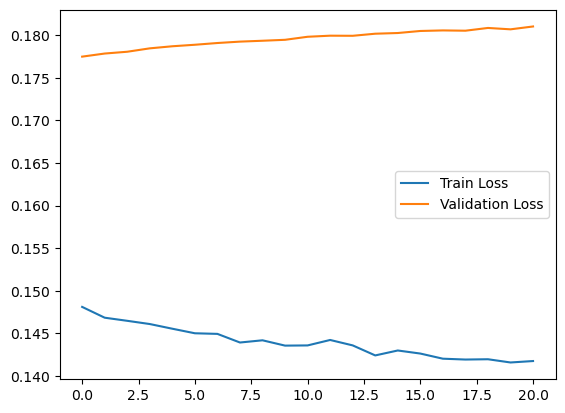

In [66]:
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

## 5.4 模型评估

### 0.加载历史模型进行评估

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



# 加载模型
model_path = 'C:/Users/Administrator/Desktop/My research/2_ML_predict_product/model/Bi_LSTMWithMulAttention_input-1_hidden-32_layers-2_heads-2_lr-0.000100_loss-1.866484_batch-128_epoch-202_seq-4.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ====== 参数设置 ======
input_size = 1       # 输入特征维度：[encoded_label, time]
hidden_size = 32
num_layers = 2
num_state_classes = len(state_encoder.classes_)  # 自动获取类别数
num_heads = 2
# ====== 初始化模型 ======
model = LSTMWithMulAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_state_classes=num_state_classes,
    dropout_rate=0.3,
    num_heads=num_heads
).to(device)


model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 初始化评估指标
all_acc_scores = []
all_f1_scores = []
all_confusion_matrices = []
state_preds = []
state_targets = []

# 获取所有可能的类别数
num_state_classes = len(state_encoder.classes_)

with torch.no_grad():
    for x_val, y_state_val in train_loader:
        x_val = x_val.to(device).float()
        y_state_val = y_state_val.to(device).long()
        y_state_val = y_state_val.squeeze(-1)

        state_pred = model(x_val)
        state_preds.extend(torch.argmax(state_pred, dim=1).cpu().numpy())
        preds = torch.argmax(state_pred, dim=1).cpu().numpy()
        
        targets = y_state_val.cpu().numpy()
        state_targets.extend(y_state_val.cpu().numpy())

        # 计算当前批次的评估指标
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds, average='weighted')
        
        # 确保混淆矩阵形状一致，指定所有可能的类别
        cm = confusion_matrix(targets, preds, labels=list(range(num_state_classes)))

        all_acc_scores.append(acc)
        all_f1_scores.append(f1)
        all_confusion_matrices.append(cm)

# 合并混淆矩阵
final_cm = sum(all_confusion_matrices)
print("Final Confusion Matrix:\n", final_cm)

# 计算平均准确率和 F1 分数
avg_acc = np.mean(all_acc_scores)
avg_f1 = np.mean(all_f1_scores)
print("Average Accuracy:", avg_acc)
print("Average F1 Score:", avg_f1)

print("Accuracy:", accuracy_score(state_targets, state_preds))
print("F1 Score:", f1_score(state_targets, state_preds, average='weighted'))

# 可视化混淆矩阵
cm = confusion_matrix(state_targets, state_preds)
plt.figure(figsize=(25, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=state_encoder.classes_, yticklabels=state_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 保存混淆矩阵到 CSV 文件
df_cm = pd.DataFrame(cm, index=state_encoder.classes_, columns=state_encoder.classes_)
#df_cm.to_csv("confusion_matrix.csv")

### 1.3 单输出模型评估-分类问题

Final Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0]
 [ 

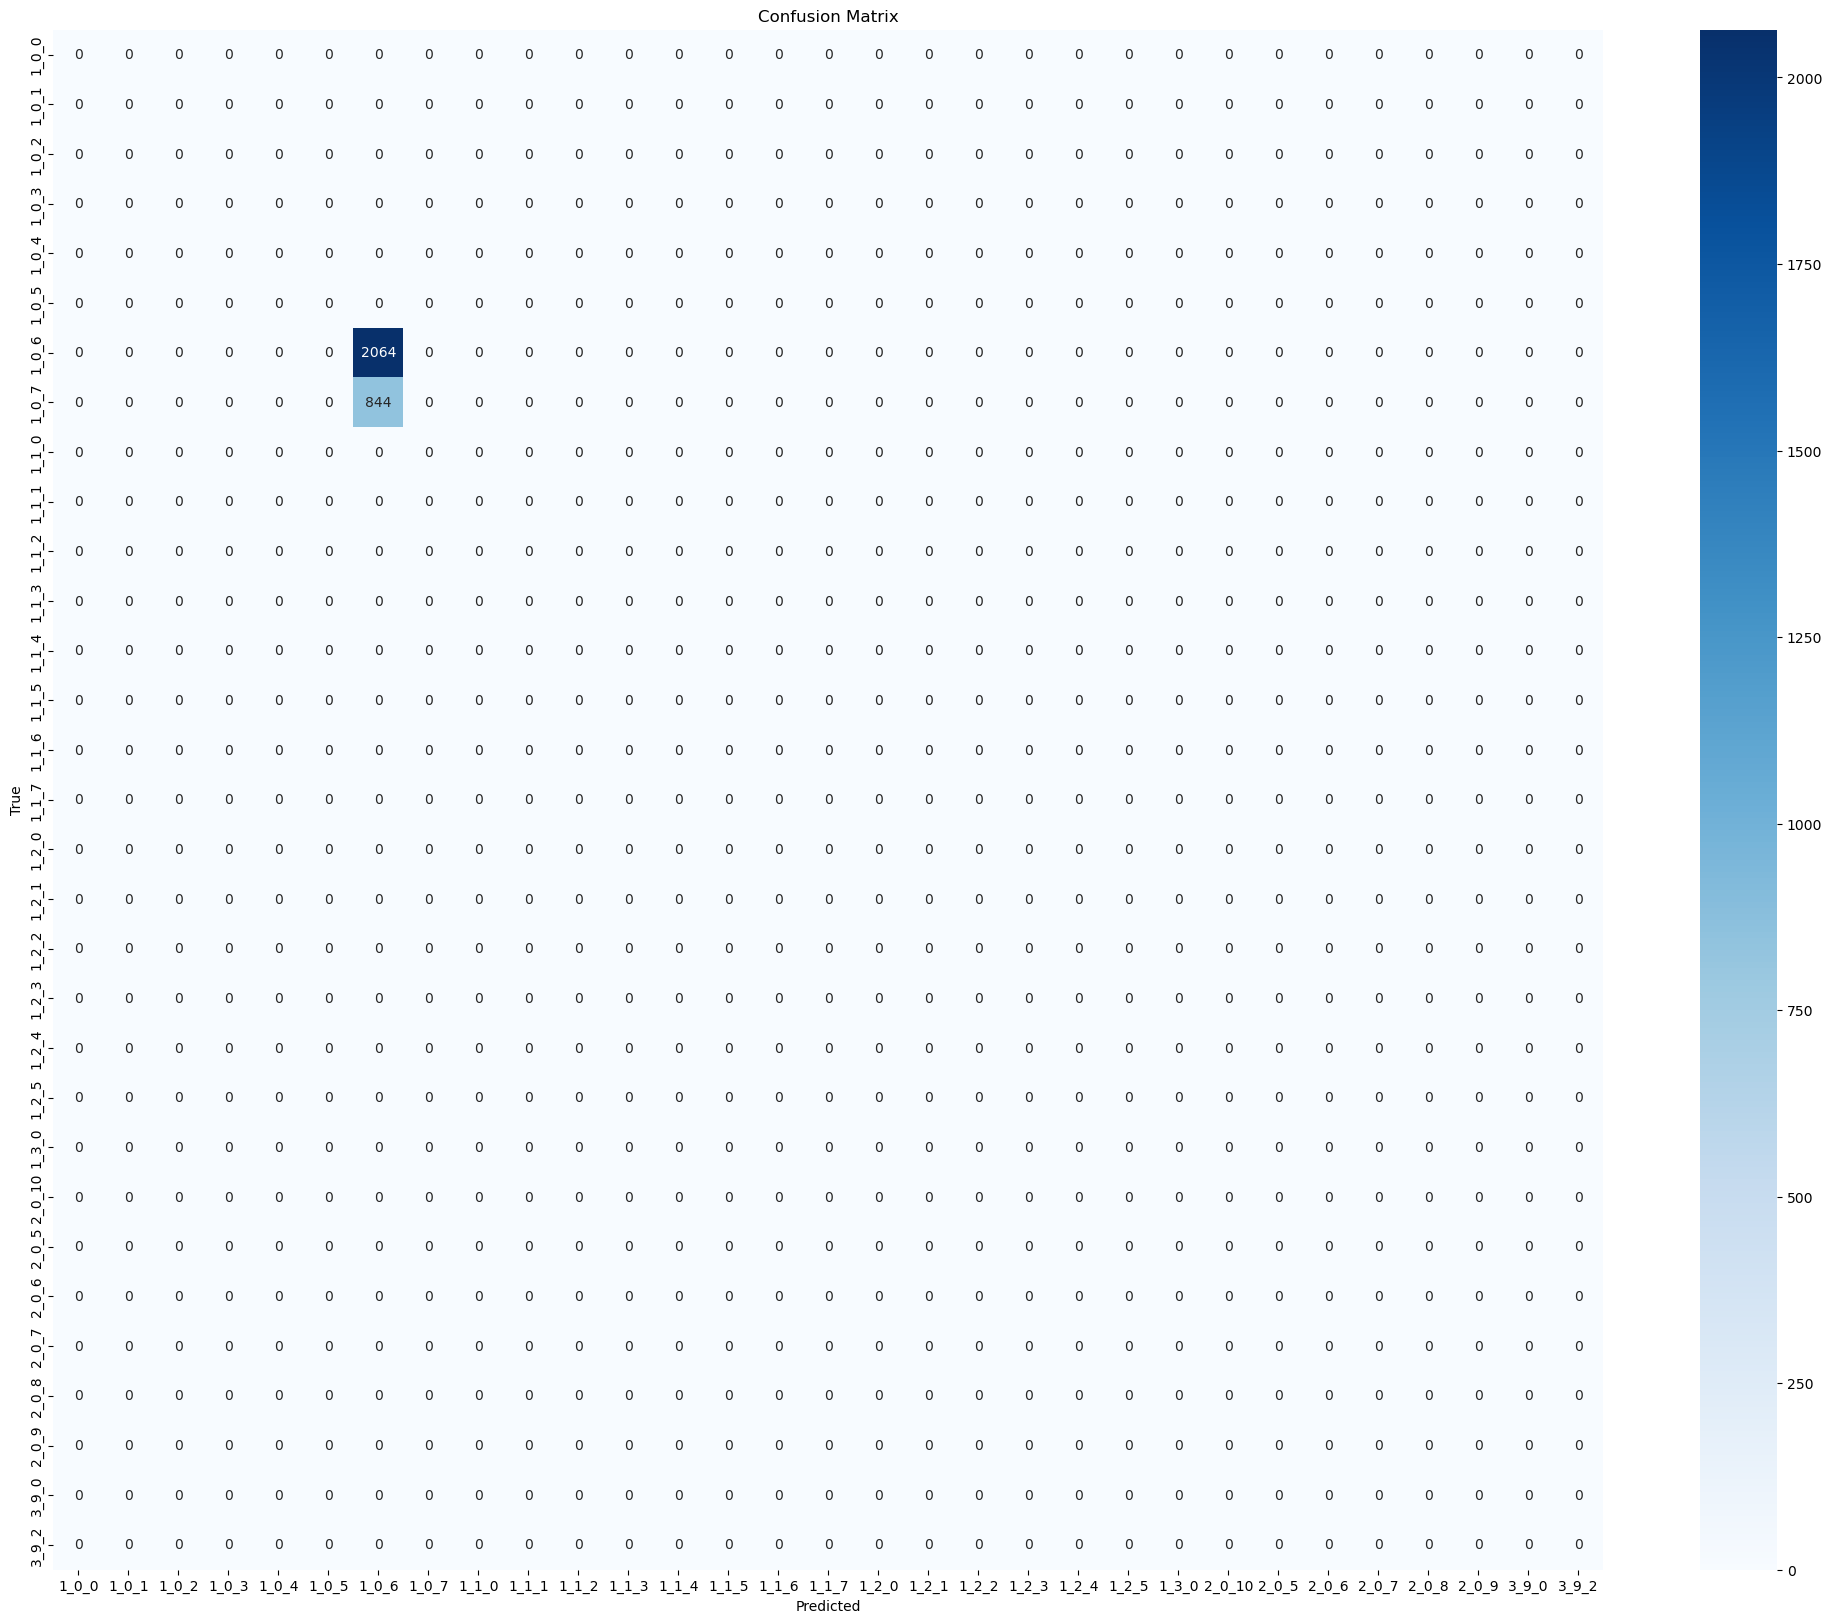

类别索引对应的物种名称：
类别 0: 1_0_0
类别 1: 1_0_1
类别 2: 1_0_2
类别 3: 1_0_3
类别 4: 1_0_4
类别 5: 1_0_5
类别 6: 1_0_6
类别 7: 1_0_7
类别 8: 1_1_0
类别 9: 1_1_1
类别 10: 1_1_2
类别 11: 1_1_3
类别 12: 1_1_4
类别 13: 1_1_5
类别 14: 1_1_6
类别 15: 1_1_7
类别 16: 1_2_0
类别 17: 1_2_1
类别 18: 1_2_2
类别 19: 1_2_3
类别 20: 1_2_4
类别 21: 1_2_5
类别 22: 1_3_0
类别 23: 2_0_10
类别 24: 2_0_5
类别 25: 2_0_6
类别 26: 2_0_7
类别 27: 2_0_8
类别 28: 2_0_9
类别 29: 3_9_0
类别 30: 3_9_2


In [22]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# 假设 state_encoder 和 model 已定义
# state_encoder = ...
# model = ...

all_acc_scores = []
all_f1_scores = []
all_confusion_matrices = []
state_preds = []
state_targets = []

# 获取所有可能的类别数
num_state_classes = len(state_encoder.classes_)
class_labels = list(range(num_state_classes))  # 确保类别标签顺序与 state_encoder.classes_ 一致

with torch.no_grad():
    for x_val, y_state_val in test_loader:
        x_val = x_val.to(device).float()
        y_state_val = y_state_val.to(device).long()
        y_state_val = y_state_val.squeeze(-1)

        state_pred = model(x_val)
        preds = torch.argmax(state_pred, dim=1).cpu().numpy()
        
        targets = y_state_val.cpu().numpy()
        state_preds.extend(preds)
        state_targets.extend(targets)

        # 计算当前批次的评估指标
        acc = accuracy_score(targets, preds)
        f1 = f1_score(targets, preds, average='weighted')
        
        # 确保混淆矩阵形状一致，指定所有可能的类别
        cm = confusion_matrix(targets, preds, labels=class_labels)

        all_acc_scores.append(acc)
        all_f1_scores.append(f1)
        all_confusion_matrices.append(cm)

# 合并混淆矩阵
final_cm = sum(all_confusion_matrices)
print("Final Confusion Matrix:\n", final_cm)

# 计算整体准确率和 F1 分数
overall_acc = accuracy_score(state_targets, state_preds)
overall_f1 = f1_score(state_targets, state_preds, average='weighted')
print("Overall Accuracy:", overall_acc)
print("Overall F1 Score:", overall_f1)

# 绘制混淆矩阵
plt.figure(figsize=(25, 20))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=state_encoder.classes_, yticklabels=state_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 输出类别名称及其对应的索引
print("类别索引对应的物种名称：")
for idx, cls in enumerate(state_encoder.classes_):
    print(f"类别 {idx}: {cls}")

混淆矩阵结果提取

In [23]:
import numpy as np
import pandas as pd

# 假设 final_cm 是最终的混淆矩阵
# final_cm = confusion_matrix(state_targets, state_preds)

# 获取所有可能的类别数和类别名称
num_state_classes = len(final_cm)
classes = state_encoder.classes_  # 物种名称列表

# 初始化统计字典
correct_rates = {}  # 存储每个物种的正确率
correct_counts = {}  # 存储每个物种的正确预测次数
wrong_predictions = {}  # 存储每个物种预测错误的目标物种及次数

# 遍历混淆矩阵，计算每个物种的正确率、正确预测次数和错误预测分布
for i in range(num_state_classes):
    total_samples = np.sum(final_cm[i, :])  # 第 i 类别的总样本数
    correct_predictions = final_cm[i, i]  # 第 i 类别的正确预测次数
    
    if total_samples > 0:
        correct_rates[i] = (correct_predictions / total_samples) * 100  # 正确率
    else:
        correct_rates[i] = 0  # 如果该类别没有样本，则正确率为 0
    
    # 记录正确预测次数
    correct_counts[i] = correct_predictions
    
    # 统计错误预测的目标物种及次数
    wrong_pred = {}
    for j in range(num_state_classes):
        if i != j and final_cm[i, j] > 0:  # 排除对角线元素（正确预测）
            wrong_pred[classes[j]] = final_cm[i, j]  # 使用物种名称代替编号
    
    # 按错误次数降序排序，取前 3 个
    wrong_predictions[i] = sorted(wrong_pred.items(), key=lambda x: x[1], reverse=True)[:3]

# 创建 DataFrame 表格
data = []
for species_idx in range(num_state_classes):
    species_name = classes[species_idx]  # 当前物种名称
    row = {
        "物种": species_name,
        "正确预测次数": correct_counts[species_idx],
        "正确率(%)": f"{correct_rates[species_idx]:.2f}"
    }
    for idx, (target_species_name, count) in enumerate(wrong_predictions[species_idx]):
        row[f"错误预测为物种 {idx+1}"] = target_species_name  # 错误预测的目标物种名称
        row[f"错误次数 {idx+1}"] = count
    data.append(row)

# 转换为 DataFrame
df = pd.DataFrame(data)

# 确保列顺序整齐
columns_order = ["物种", "正确预测次数", "正确率(%)"]  # 新增列插入到第二列
for i in range(3):  # 最多显示前 3 个错误预测
    columns_order.extend([f"错误预测为物种 {i+1}", f"错误次数 {i+1}"])
df = df[columns_order]

# 按照正确预测次数降序排列
df_sorted = df.sort_values(by="正确预测次数", ascending=False)

# 输出表格
print("每个物种的预测统计结果：")
print(df_sorted.to_string(index=False))

# 将排序后的数据保存到 CSV 文件
df_sorted.to_csv("species_prediction_stats_sorted.csv", index=False)

KeyError: "['错误预测为物种 2', '错误次数 2', '错误预测为物种 3', '错误次数 3'] not in index"

### 1.4 单输出模型评估-回归问题（X4维，y3维）

##### 评价不做数据预处理的X和y

y_test 类别分布:
1_0_7: 1408
1_0_6: 1417


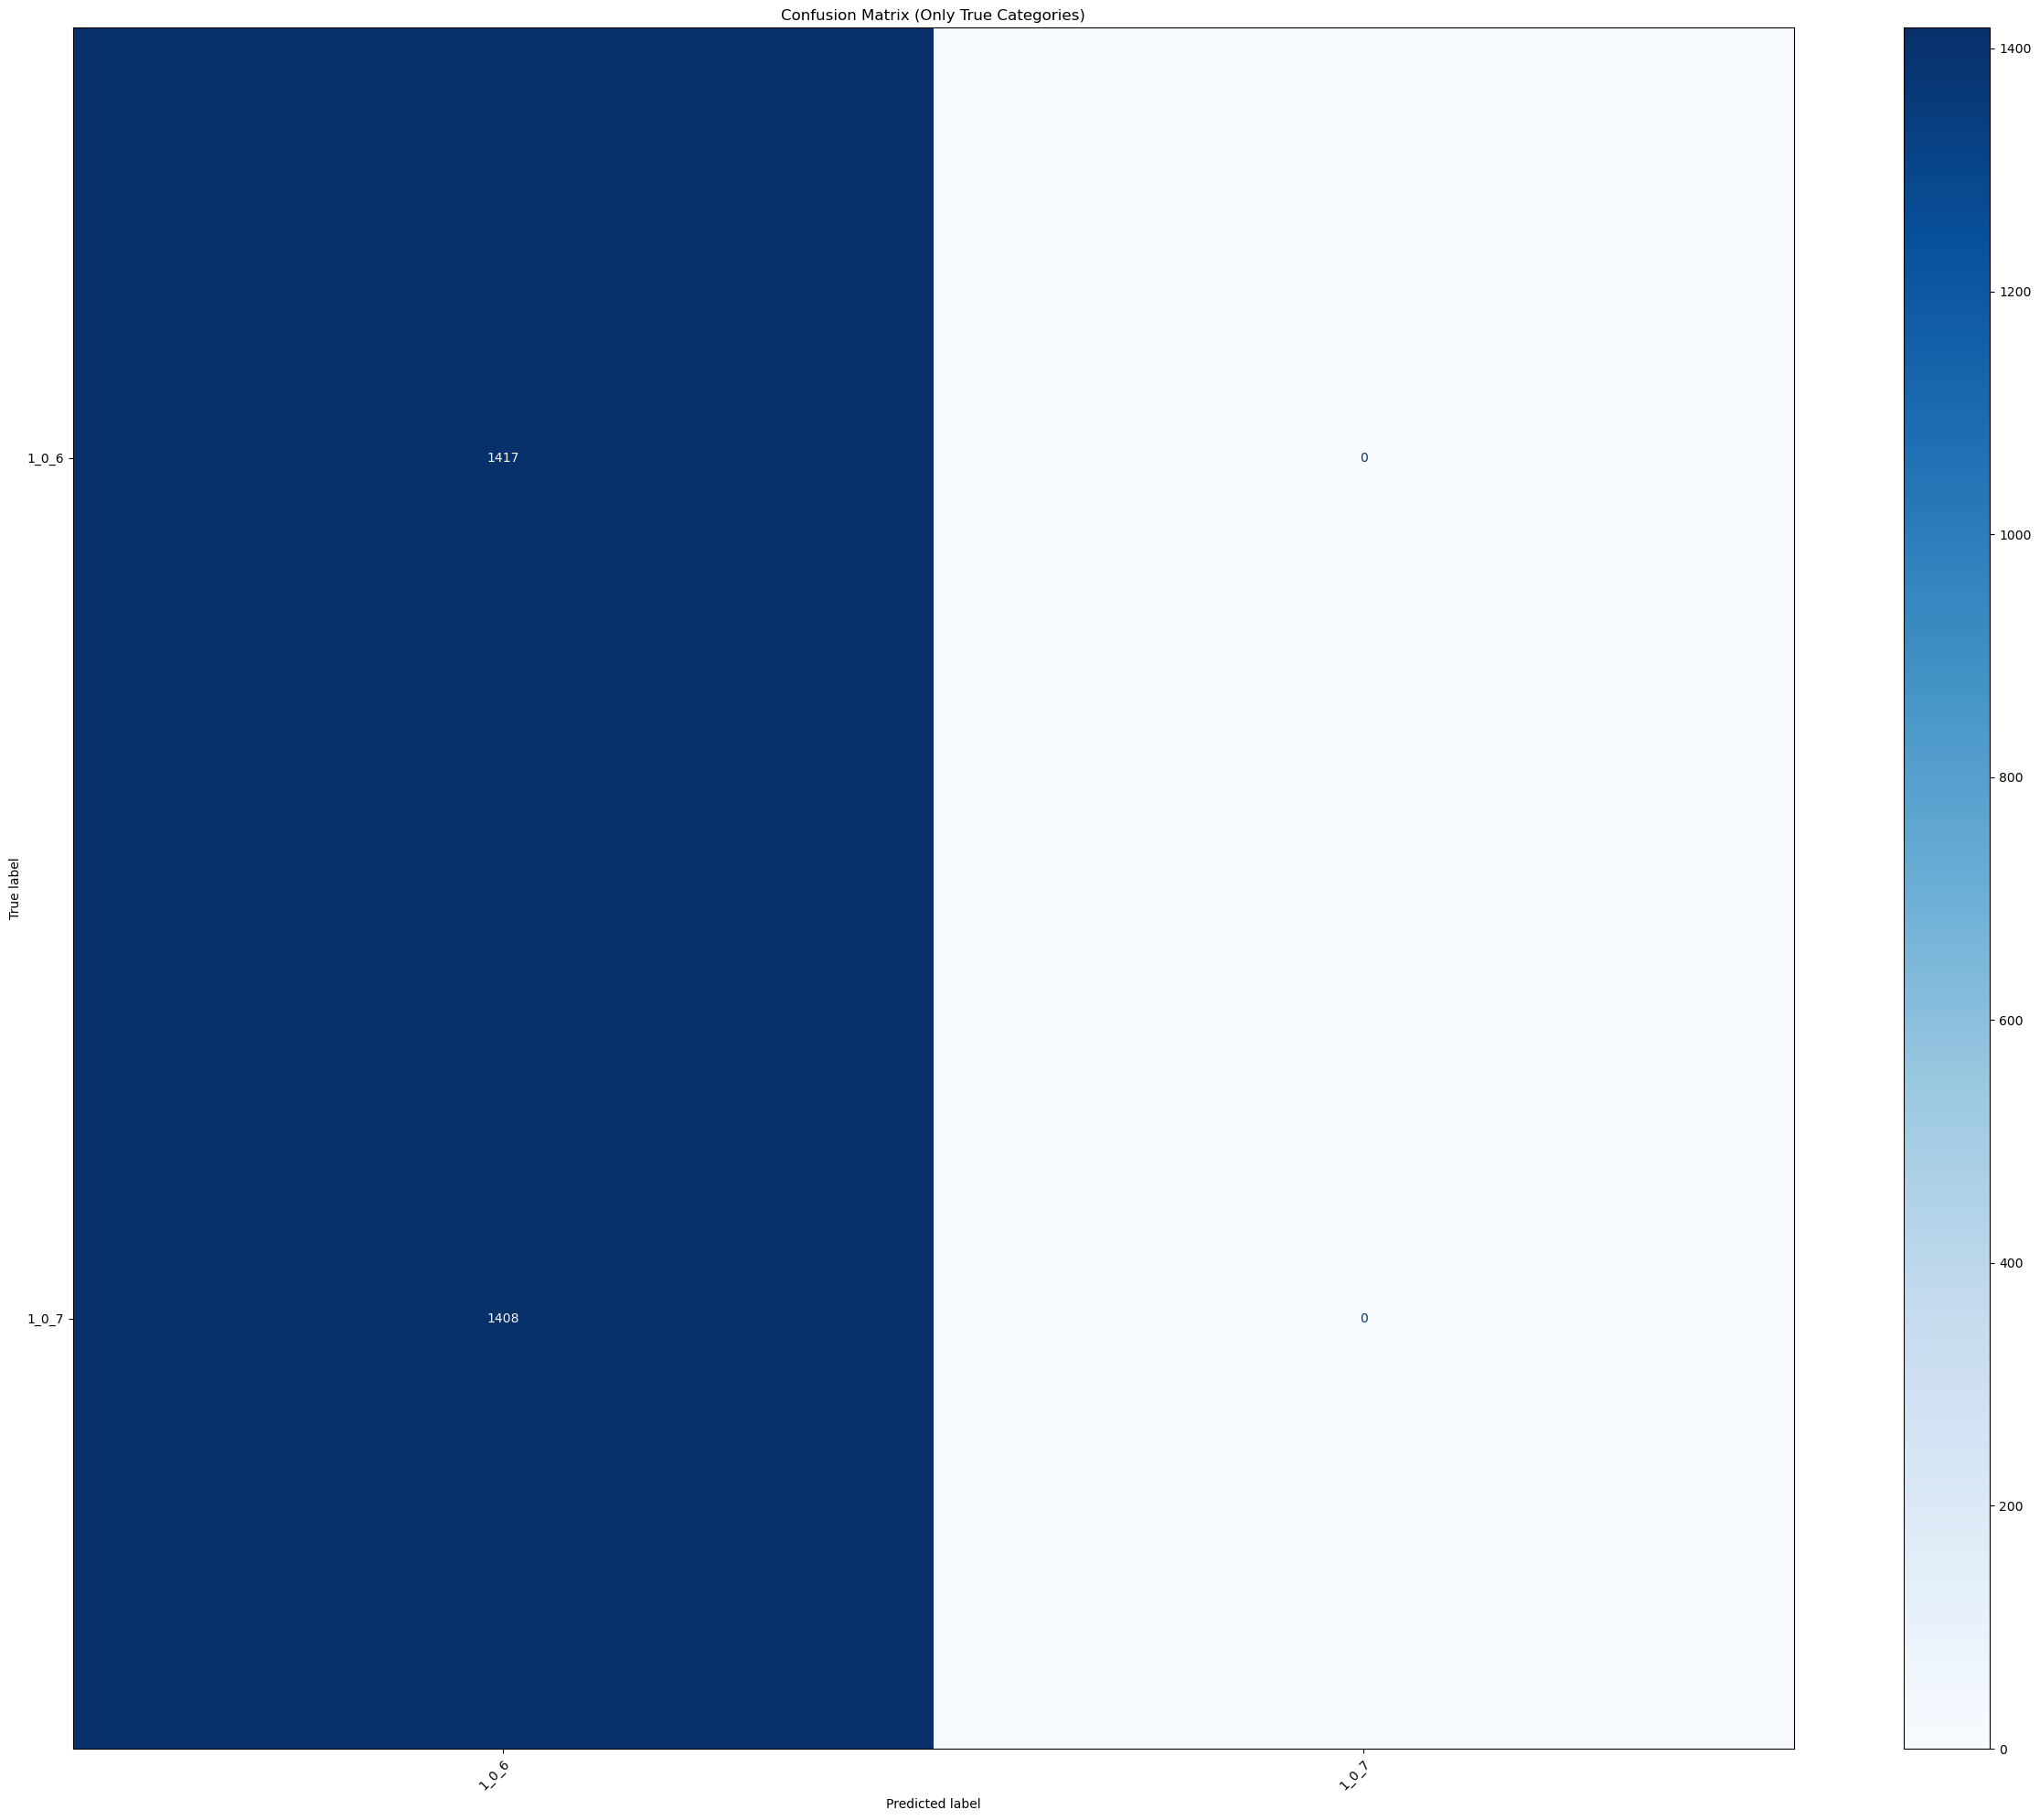

每个类别的预测正确次数和召回率:
1_0_6: 正确预测次数 = 1417, 召回率 = 1.0000
1_0_7: 正确预测次数 = 0, 召回率 = 0.0000

每个实际物种预测错误的前三类物种的次数:
实际类别 1_0_6 没有预测错误（在真实类别中）。
实际类别 1_0_7 预测错误的前三类:
  预测为 1_0_6: 1408 次

没有预测到 y_test 中未出现的类别。

平均测试损失: 0.0834
类别准确率（仅真实类别）: 0.5016
预测到未知类别的样本数: 0


In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, recall_score, ConfusionMatrixDisplay
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader, device, criterion):
    model.eval()
    test_losses = []
    all_outputs_rounded = []
    all_y_true = []

    # 数据收集阶段
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            test_losses.append(loss.item())
            
            # 自定义四舍五入：小数部分 < 1/3 舍，大于或等于1/3进位
            x_floor = torch.floor(outputs)
            remainder = outputs - x_floor
            outputs_custom = torch.where(remainder < (0.5), x_floor, x_floor + 1)
            outputs_custom = outputs_custom.int().cpu().numpy()
            
            y_batch_int = y_batch.int().cpu().numpy()

            all_outputs_rounded.append(outputs_custom)
            all_y_true.append(y_batch_int)

    all_outputs_rounded = np.vstack(all_outputs_rounded)
    all_y_true = np.vstack(all_y_true)

    # 将多维标签转换为字符串形式
    y_true_labels = ["_".join(map(str, y)) for y in all_y_true]
    y_pred_labels = ["_".join(map(str, y)) for y in all_outputs_rounded]

    # 获取测试集中真实出现的唯一类别
    true_categories = list(set(y_true_labels))

    # 使用 LabelEncoder 只对真实类别进行 fit
    encoder = LabelEncoder()
    encoder.fit(true_categories)

    # 转换 y_true_labels
    y_true_encoded = encoder.transform(y_true_labels)

    # 处理 y_pred_labels：不在真实类别中的预测标签标记为 -1（unknown）
    y_pred_encoded = []
    unknown_count = 0
    for label in y_pred_labels:
        if label in true_categories:
            y_pred_encoded.append(encoder.transform([label])[0])
        else:
            y_pred_encoded.append(-1)  # 标记为 'unknown'
            unknown_count += 1
    y_pred_encoded = np.array(y_pred_encoded)

    # **统计 y_test 的类别分布**
    category_counts = Counter(y_true_labels)
    print("y_test 类别分布:")
    for category, count in category_counts.items():
        print(f"{category}: {count}")

    # **计算平均测试损失**
    avg_test_loss = sum(test_losses) / len(test_losses)

    # **计算类别准确率（仅考虑预测标签在真实类别中的样本）**
    mask = y_pred_encoded != -1
    category_correct = (y_true_encoded[mask] == y_pred_encoded[mask]).sum()
    total_samples = mask.sum()
    category_acc = category_correct / total_samples if total_samples > 0 else 0

    # **绘制混淆矩阵（仅包含真实类别）**
    cm = confusion_matrix(y_true_encoded, y_pred_encoded, labels=range(len(encoder.classes_)))
    fig, ax = plt.subplots(figsize=(25, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.title("Confusion Matrix (Only True Categories)")
    plt.tight_layout()
    plt.show()

    # **计算每个类别的预测正确次数和召回率**
    recall_per_class = recall_score(y_true_encoded, y_pred_encoded, average=None, labels=range(len(encoder.classes_)), zero_division=0)
    print("每个类别的预测正确次数和召回率:")
    for i, category in enumerate(encoder.classes_):
        correct_count = cm[i, i]
        recall = recall_per_class[i]
        print(f"{category}: 正确预测次数 = {correct_count}, 召回率 = {recall:.4f}")

    # **统计每个实际物种预测错误的前三类物种的次数（仅在真实类别中）**
    print("\n每个实际物种预测错误的前三类物种的次数:")
    for i, category in enumerate(encoder.classes_):
        error_indices = np.where((y_true_encoded == i) & (y_pred_encoded != i) & (y_pred_encoded != -1))[0]
        if len(error_indices) > 0:
            error_preds = y_pred_encoded[error_indices]
            error_counts = Counter(error_preds)
            top3_errors = error_counts.most_common(3)
            print(f"实际类别 {category} 预测错误的前三类:")
            for err_category, count in top3_errors:
                err_category_label = encoder.classes_[err_category]
                print(f"  预测为 {err_category_label}: {count} 次")
        else:
            print(f"实际类别 {category} 没有预测错误（在真实类别中）。")

    # **统计预测中出现的额外类别（不在测试集中）**
    extra_categories = set(y_pred_labels) - set(true_categories)
    if extra_categories:
        print("\n预测中出现的额外类别（不在 y_test 中）：")
        for category in extra_categories:
            count = y_pred_labels.count(category)
            print(f"{category}: {count} 次")
    else:
        print("\n没有预测到 y_test 中未出现的类别。")

    # 输出结果
    print(f"\n平均测试损失: {avg_test_loss:.4f}")
    print(f"类别准确率（仅真实类别）: {category_acc:.4f}")
    print(f"预测到未知类别的样本数: {unknown_count}")

    return avg_test_loss, category_acc

# 使用示例
avg_test_loss, category_acc = evaluate_model(model, train_loader, device, criterion)

##### 前三维特征经过标准化处理的数据模型评估

y_test 类别分布:
1_0_6: 400
1_0_7: 443


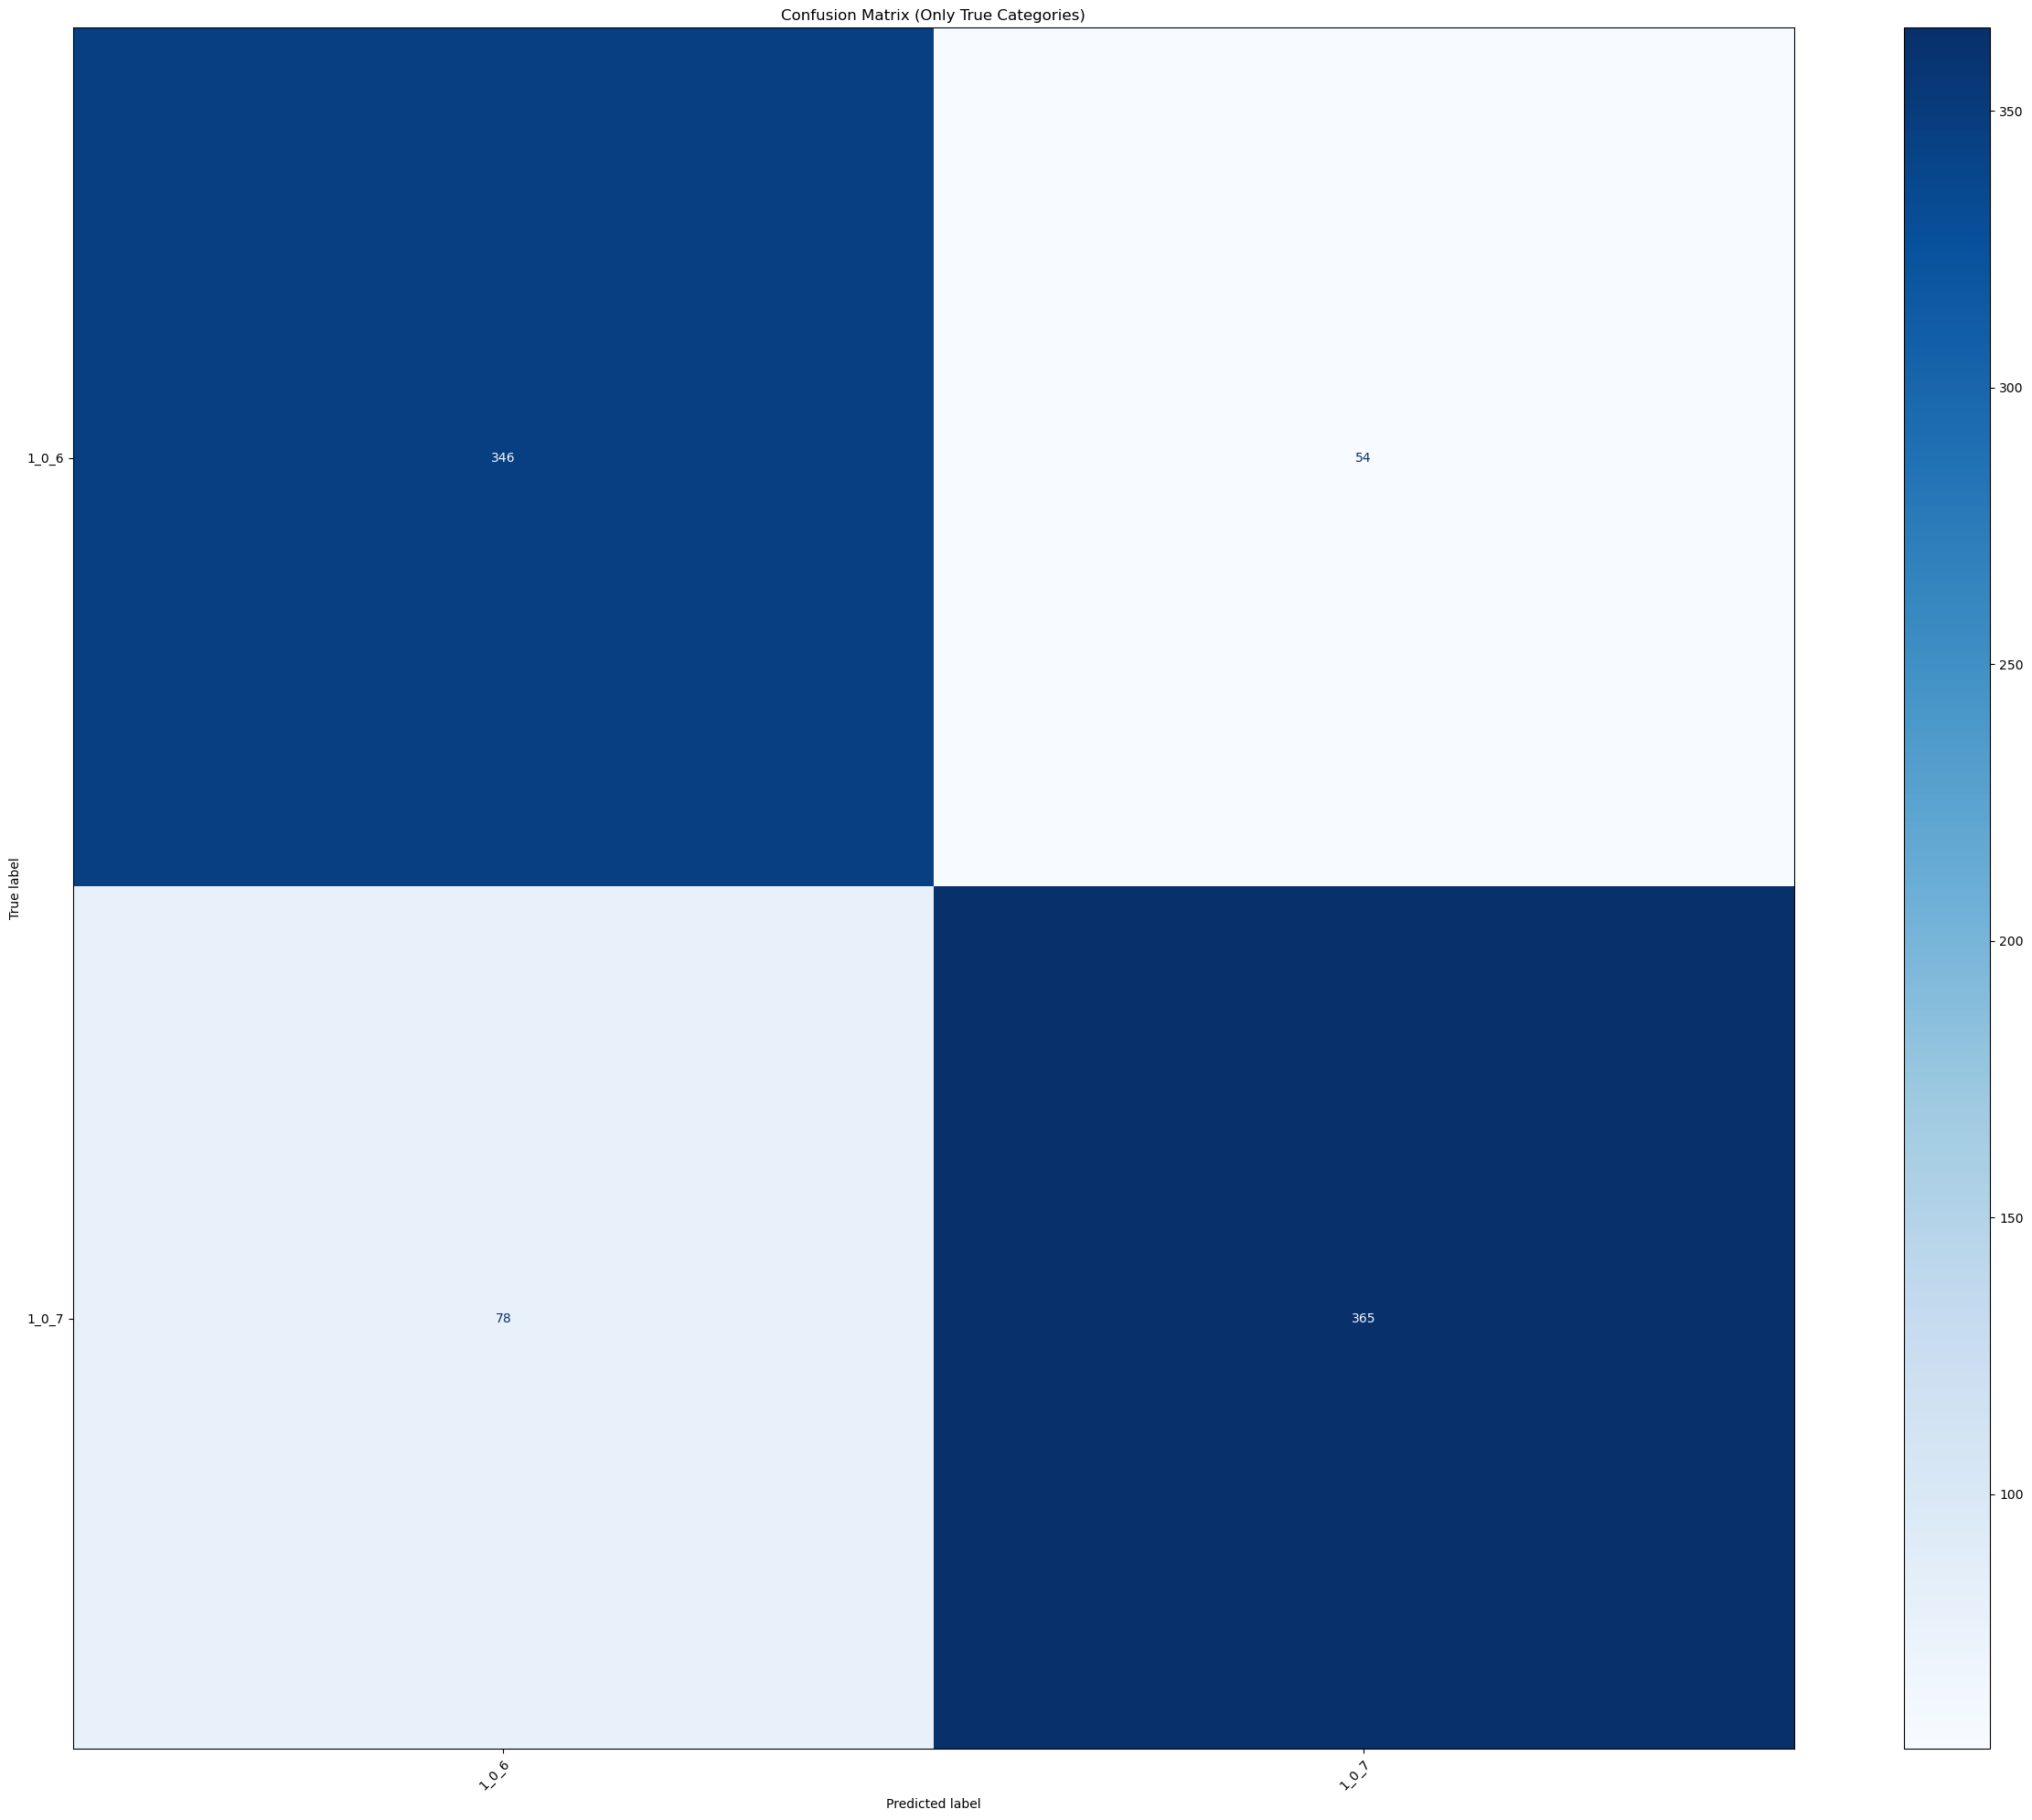

每个类别的预测正确次数和召回率:
1_0_6: 正确预测次数 = 346, 召回率 = 0.8650
1_0_7: 正确预测次数 = 365, 召回率 = 0.8239

每个实际物种预测错误的前三类物种的次数:
实际类别 1_0_6 预测错误的前三类:
  预测为 1_0_7: 54 次
实际类别 1_0_7 预测错误的前三类:
  预测为 1_0_6: 78 次

没有预测到 y_test 中未出现的类别。

平均测试损失: 0.1775
类别准确率（仅真实类别）: 0.8434
预测到未知类别的样本数: 0


In [67]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, recall_score, ConfusionMatrixDisplay
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, test_loader, device, criterion, y_scaler):
    """
    model: 训练好的模型
    test_loader: 测试数据 DataLoader
    device: 设备 (CPU 或 GPU)
    criterion: 损失函数 (例如 MSELoss, 或其他)
    y_scaler: 针对 y 的 StandardScaler，用于恢复标准化前的数值
    """
    model.eval()
    test_losses = []
    all_outputs_rounded = []
    all_y_true = []

    # 数据收集阶段
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()

            # 预测 (仍然是标准化空间下的值)
            outputs = model(x_batch)

            # 计算损失 (此时 outputs 与 y_batch 都是标准化过的)
            loss = criterion(outputs, y_batch)
            test_losses.append(loss.item())

            # ---- 1) 转回 CPU，并从标准化值恢复到原始数值 ----
            # outputs_std.shape = [batch_size, 3] (标准化后的预测)
            outputs_std = outputs.cpu().numpy()
            # y_batch_std.shape = [batch_size, 3] (标准化后的真实标签)
            y_batch_std = y_batch.cpu().numpy()

            # 用 y_scaler 恢复标准化：  -> 原始值
            outputs_original = y_scaler.inverse_transform(outputs_std)
            y_batch_original = y_scaler.inverse_transform(y_batch_std)

            # ---- 2) 自定义舍入逻辑（在原始值空间中操作）----
            # 这里的逻辑示例：若小数 < 0.5 就下取整，否则上取整
            # 也可以修改为 < 1/3 舍，否则进位，类似：
            # remainder < 1/3 -> floor, remainder >= 1/3 -> floor + 1
            x_floor = np.floor(outputs_original)
            remainder = outputs_original - x_floor
            outputs_custom = np.where(remainder < 0.5, x_floor, x_floor + 1).astype(int)
            
            y_batch_int = y_batch_original.astype(int)  # 将真实值也取整（若原本就是整数，可直接 .astype(int))

            # ---- 3) 累积预测与真实标签，以便后续评估 ----
            all_outputs_rounded.append(outputs_custom)
            all_y_true.append(y_batch_int)

    # ---- 将所有批次拼接在一起 ----
    all_outputs_rounded = np.vstack(all_outputs_rounded)  # shape = [N, 3]
    all_y_true = np.vstack(all_y_true)                    # shape = [N, 3]

    # ---- 后续评估：混淆矩阵、召回率、准确率等 ----
    y_true_labels = ["_".join(map(str, y)) for y in all_y_true]
    y_pred_labels = ["_".join(map(str, y)) for y in all_outputs_rounded]

    # 1) 获取测试集中真实出现的唯一类别
    true_categories = list(set(y_true_labels))

    # 2) 使用 LabelEncoder 只对真实类别进行 fit
    encoder = LabelEncoder()
    encoder.fit(true_categories)

    # 3) 转换 y_true_labels
    y_true_encoded = encoder.transform(y_true_labels)

    # 4) 处理 y_pred_labels：不在真实类别中的预测标签标记为 -1（unknown）
    y_pred_encoded = []
    unknown_count = 0
    for label in y_pred_labels:
        if label in true_categories:
            y_pred_encoded.append(encoder.transform([label])[0])
        else:
            y_pred_encoded.append(-1)  # 标记为 'unknown'
            unknown_count += 1
    y_pred_encoded = np.array(y_pred_encoded)

    # 5) 统计 y_test 的类别分布
    category_counts = Counter(y_true_labels)
    print("y_test 类别分布:")
    for category, count in category_counts.items():
        print(f"{category}: {count}")

    # 6) 计算平均测试损失
    avg_test_loss = sum(test_losses) / len(test_losses)

    # 7) 计算类别准确率（仅考虑预测标签在真实类别中的样本）
    mask = (y_pred_encoded != -1)
    category_correct = (y_true_encoded[mask] == y_pred_encoded[mask]).sum()
    total_samples = mask.sum()
    category_acc = category_correct / total_samples if total_samples > 0 else 0

    # 8) 绘制混淆矩阵（仅包含真实类别）
    cm = confusion_matrix(y_true_encoded, y_pred_encoded, labels=range(len(encoder.classes_)))
    fig, ax = plt.subplots(figsize=(25, 20))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.title("Confusion Matrix (Only True Categories)")
    plt.tight_layout()
    plt.show()

    # 9) 计算每个类别的预测正确次数和召回率
    recall_per_class = recall_score(y_true_encoded, y_pred_encoded,
                                    average=None, labels=range(len(encoder.classes_)), zero_division=0)
    print("每个类别的预测正确次数和召回率:")
    for i, category in enumerate(encoder.classes_):
        correct_count = cm[i, i]
        recall = recall_per_class[i]
        print(f"{category}: 正确预测次数 = {correct_count}, 召回率 = {recall:.4f}")

    # 10) 统计每个实际物种预测错误的前三类物种的次数（仅在真实类别中）
    print("\n每个实际物种预测错误的前三类物种的次数:")
    for i, category in enumerate(encoder.classes_):
        error_indices = np.where((y_true_encoded == i) & (y_pred_encoded != i) & (y_pred_encoded != -1))[0]
        if len(error_indices) > 0:
            error_preds = y_pred_encoded[error_indices]
            error_counts = Counter(error_preds)
            top3_errors = error_counts.most_common(3)
            print(f"实际类别 {category} 预测错误的前三类:")
            for err_category, count in top3_errors:
                err_category_label = encoder.classes_[err_category]
                print(f"  预测为 {err_category_label}: {count} 次")
        else:
            print(f"实际类别 {category} 没有预测错误（在真实类别中）。")

    # 11) 统计预测中出现的额外类别（不在测试集中）
    extra_categories = set(y_pred_labels) - set(true_categories)
    if extra_categories:
        print("\n预测中出现的额外类别（不在 y_test 中）：")
        for category in extra_categories:
            count = y_pred_labels.count(category)
            print(f"{category}: {count} 次")
    else:
        print("\n没有预测到 y_test 中未出现的类别。")

    # 12) 输出结果
    print(f"\n平均测试损失: {avg_test_loss:.4f}")
    print(f"类别准确率（仅真实类别）: {category_acc:.4f}")
    print(f"预测到未知类别的样本数: {unknown_count}")

    return avg_test_loss, category_acc

# 使用示例（假设你已经有 y_scaler）
avg_test_loss, category_acc = evaluate_model(model, test_loader, device, criterion, y_scaler)


### 2. 多输出模型评估 - 评估分类和回归任务


===== 状态分类评估 =====
准确率: 0.5370129321274617

===== 时间预测评估 =====
RMSE: 849.34
MAE: 386.94


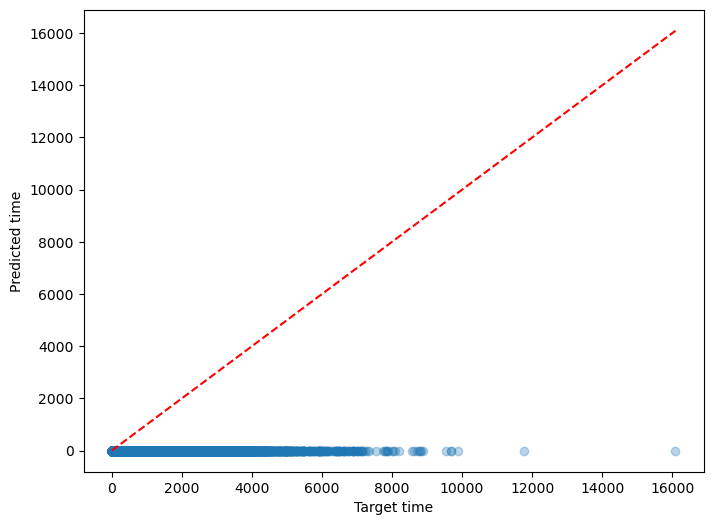

state_accuracy: 0.5370129321274617
time_rmse: 849.336216149921
time_mae: 386.9372283037189


In [38]:
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 初始化存储容器
state_preds = []
time_preds = []
state_targets = []
time_targets = []
model.eval()

with torch.no_grad():
    for x_batch, y_state, y_time in test_loader:
        x_batch = x_batch.to(device).float()

        # 前向传播
        state_pred, time_pred = model(x_batch)

        # 收集预测结果
        state_preds.extend(torch.argmax(state_pred, dim=1).cpu().numpy())  # 取类别索引
        time_preds.extend(time_pred.cpu().numpy())

        # 收集真实标签
        state_targets.extend(y_state.cpu().numpy())
        time_targets.extend(y_time.cpu().numpy())

# ====== 分类任务评估 ======
print("\n===== 状态分类评估 =====")
print("准确率:", accuracy_score(state_targets, state_preds))
# print(classification_report(
#     state_targets, 
#     state_preds,
#     target_names=state_encoder.classes_  # 使用之前保存的编码器类别名
# ))


# ====== 时间回归评估 ======
print("\n===== 时间预测评估 =====")
rmse = np.sqrt(mean_squared_error(time_targets, time_preds))
mae = mean_absolute_error(time_targets, time_preds)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# 时间预测散点图
plt.figure(figsize=(8, 6))
plt.scatter(time_targets, time_preds, alpha=0.3)
plt.plot([min(time_targets), max(time_targets)], 
         [min(time_targets), max(time_targets)], 'r--')
plt.xlabel("Target time")
plt.ylabel("Predicted time")
plt.show()


print("state_accuracy:", accuracy_score(state_targets, state_preds))
print("time_rmse:", rmse)
print("time_mae:", mae)




# 六. 模型深度调优训练

## 6.1.类权重法

### 1. 计算类权重矩阵 

#### 1.1 wi = min(1.0 / (n_i * recall_i),w_max)

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_class_weights(confusion_matrix, epsilon=1e-5, w_max=100.0):
    """
    根据混淆矩阵计算类权重。
    
    参数：
    - confusion_matrix: 混淆矩阵，shape=(num_classes, num_classes)
    - epsilon: 平滑参数，防止除零，默认值为 1e-5
    - w_max: 权重上限，默认值为 100.0
    
    返回：
    - weights: 每个类别的权重，shape=(num_classes,)
    """
    num_classes = confusion_matrix.shape[0]
    weights = np.zeros(num_classes)
    
    for i in range(num_classes):
        # 真阳性 (TP)
        TP = confusion_matrix[i, i]
        # 假阴性 (FN)，即真实为 i 但预测为其他类别的数量
        FN = np.sum(confusion_matrix[i, :]) - TP
        # 类别 i 的总样本数
        n_i = TP + FN
        
        if n_i == 0:
            # 如果类别 i 在测试集中没有样本，设置默认权重
            weights[i] = 1.0
        else:
            # 平滑召回率
            recall_i = (TP + epsilon) / (TP + FN + epsilon)
            # 计算权重
            weights[i] = 1.0 / (n_i * recall_i)
            # 限制权重上限
            weights[i] = min(weights[i], w_max)
    
    # 归一化权重，使其总和等于类别数（可选）
    weights = weights / np.sum(weights) * num_classes
    
    return weights

# 使用你的混淆矩阵计算权重
class_weights = calculate_class_weights(final_cm)
print("Class Weights:", class_weights)

Class Weights: [1.52685859e-04 1.07132179e-05 1.18317457e-05 8.71165937e-06
 1.22906094e-05 1.31663895e-05 5.45088527e-02 5.45088527e-02
 5.45088527e+00 5.45088527e+00 1.32270936e-05 4.61548284e-05
 1.52814277e-05 2.29510958e-05 3.52351988e-05 2.95280892e-05
 4.82806489e-05 1.09017495e-02 2.19528202e-05 1.02653205e-04
 1.80492885e-04 2.40127101e-04 4.12945836e-04 5.54515286e-05
 5.45088527e+00 2.32943809e-04 5.45083855e-02 7.07907098e-04
 5.45088527e+00 5.45088527e+00 1.81695584e-02 1.26764746e-03
 8.65219753e-04 3.65831204e-04 3.04518716e-04 4.69903868e-04
 2.72542998e-02 5.45088527e+00 5.45083209e-02 5.45083192e-02
 3.89348695e-03 5.45088527e+00 5.45088527e+00 5.45083531e-02]


#### 1.2 wi 手动设定

In [44]:
import numpy as np

# 假设 final_cm 是合并后的混淆矩阵
# final_cm = ...

# 找出对角线上为零的类别索引
zero_recall_classes = np.where(np.diag(final_cm) == 0)[0]
print("Classes with zero recall:", zero_recall_classes)

Classes with zero recall: [ 8  9 24 28 29 37 41 42]


In [53]:
# 设置大权重值
large_weight = 1000000000000000000

# 初始化类别权重数组，所有类别权重初始为1
num_state_classes = len(state_encoder.classes_)
class_weights = np.ones(num_state_classes)

class_weights[6] = large_weight

# 为零召回率的类别设置大权重
# for cls in zero_recall_classes:
#     class_weights[cls] = large_weight

# 转换为 PyTorch 张量
#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)

Class weights: [1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+18 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00
 1.e+00 1.e+00 1.e+00 1.e+00]


### 2.加权损失函数代码

In [54]:
import torch
import torch.nn as nn

# 将权重转换为 tensor，并移动到与模型相同的设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# 定义加权交叉熵损失函数
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor,reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

返回继续执行上述的训练模型代码